In [3]:
# %%
# Cell 1: Imports & Setup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from scipy import stats
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

# Configuration
SAVE_DIR = "Saved_files_new"
plt.style.use('default')
sns.set_palette("husl")

print(f"Visualization setup complete. Using save directory: {SAVE_DIR}")


Visualization setup complete. Using save directory: Saved_files_new


## Data Loading Functions


In [4]:
# %%
# Cell 2: Enhanced Data Loading Functions with Topic-Specific N-grams
def try_read_csv(file_path, sep_choices=(';', ',')):
    """Try to read CSV with different separators for robustness."""
    for sep in sep_choices:
        try:
            df = pd.read_csv(file_path, sep=sep, encoding='utf-8')
            if len(df.columns) == 1 and ',' in df.columns[0]:
                continue
            return df
        except Exception:
            continue
    raise ValueError(f"Could not load {file_path} with any separator.")

def load_complete_analysis_data(date_string, save_dir="Saved_files_new"):
    """
    Load analyzed DataFrame with enhanced file pattern matching.
    Matches the actual file naming convention from the method detection pipeline.
    Now includes topic-specific n-grams loading.
    """
    print(f"Loading complete analysis data for {date_string}...")
    print(f"Searching in directory: {save_dir}")
    
    if not os.path.exists(save_dir):
        print(f"❌ Directory {save_dir} does not exist!")
        return None
    
    try:
        # Primary file patterns (matching refactored method detection pipeline)
        possible_files = [
            f"enhanced_method_analysis_{date_string}.csv",
            f"semantic_scholar_{date_string}_all_results.csv",
            f"semantic_scholar_{date_string}_enhanced_analysis.csv",
            f"semantic_scholar_{date_string}_results.csv",
            f"{date_string}_enhanced_analysis.csv",
            f"{date_string}_results.csv"
        ]
        
        df_filename = None
        print("  Checking for main analysis file...")
        for base in possible_files:
            potential_path = os.path.join(save_dir, base)
            if os.path.exists(potential_path):
                df_filename = potential_path
                print(f"  ✅ Found: {base}")
                break
            else:
                print(f"  ❌ Not found: {base}")
        
        if df_filename is None:
            print(f"\n📁 Available CSV files in {save_dir}:")
            csv_files = [f for f in os.listdir(save_dir) if f.endswith('.csv')]
            for f in sorted(csv_files):
                print(f"    📄 {f}")
            raise FileNotFoundError(f"No analyzed CSV file found for {date_string}")
        
        # Load main DataFrame
        df_analyzed = try_read_csv(df_filename)
        print(f"  ✅ Loaded DataFrame: {df_analyzed.shape}")
        print(f"  📊 Columns: {list(df_analyzed.columns)}")
        
        # Load topic metadata
        topic_keywords = topic_names = method_groups = None
        
        topic_file_patterns = [
            f"topics_{date_string}.json",
            f"topic_names_{date_string}.json", 
            f"semantic_scholar_{date_string}_topic_names.json",
            f"method_variant_groups_{date_string}.json",
            f"{date_string}_topics.json",
            f"{date_string}_topic_names.json"
        ]
        
        print("  Checking for topic metadata...")
        for pattern in topic_file_patterns:
            topic_path = os.path.join(save_dir, pattern)
            if os.path.exists(topic_path):
                print(f"  ✅ Found topic file: {pattern}")
                try:
                    with open(topic_path, 'r', encoding='utf-8') as f:
                        topic_data = json.load(f)
                        
                    if isinstance(topic_data, dict):
                        if 'topics' in topic_data:
                            topic_keywords = topic_data['topics']
                            topic_names = topic_data.get('topic_names', None)
                        elif 'topic_names' in topic_data:
                            topic_names = topic_data['topic_names']
                        else:
                            # Assume it's directly topic names or method groups
                            if any('topic' in str(k).lower() for k in topic_data.keys()):
                                topic_names = topic_data
                            else:
                                method_groups = topic_data
                    break
                except Exception as e:
                    print(f"    ⚠️  Error loading {pattern}: {e}")
                    continue
        
        # Try to load term frequencies
        term_freq_patterns = [
            f"term_frequencies_{date_string}.json",
            f"{date_string}_term_frequencies.json",
            "term_frequencies.json"
        ]
        
        term_frequencies_file = None
        for pattern in term_freq_patterns:
            freq_path = os.path.join(save_dir, pattern)
            if os.path.exists(freq_path):
                term_frequencies_file = pattern
                print(f"  ✅ Found term frequencies: {pattern}")
                break
        
        if not term_frequencies_file:
            print("  ⚠️  No term frequencies file found")
        
        # ADDED: Try to load topic-specific TF-IDF n-grams
        topic_ngram_patterns = [
            f"topic_specific_tfidf_ngrams_{date_string}.json",
            f"topic_tfidf_ngrams_{date_string}.json",
            f"{date_string}_topic_ngrams.json",
            f"topic_ngrams_{date_string}.json",
            f"semantic_scholar_{date_string}_topic_ngrams.json"
        ]
        
        topic_specific_tfidf_ngrams = None
        print("  Checking for topic-specific n-grams...")
        for pattern in topic_ngram_patterns:
            ngram_path = os.path.join(save_dir, pattern)
            if os.path.exists(ngram_path):
                print(f"  ✅ Found topic n-grams: {pattern}")
                try:
                    with open(ngram_path, 'r', encoding='utf-8') as f:
                        topic_specific_tfidf_ngrams = json.load(f)
                    print(f"    📊 Loaded n-grams for {len(topic_specific_tfidf_ngrams)} topics")
                    break
                except Exception as e:
                    print(f"    ⚠️  Error loading {pattern}: {e}")
                    continue
        
        if not topic_specific_tfidf_ngrams:
            print("  ⚠️  No topic-specific n-grams found")
        
        result = {
            'df_analyzed': df_analyzed,
            'topic_names': topic_names,
            'topic_keywords': topic_keywords,
            'method_groups': method_groups,
            'term_frequencies_file': term_frequencies_file,
            'topic_specific_tfidf_ngrams': topic_specific_tfidf_ngrams,
        }
        
        print(f"✅ Successfully loaded analysis data!")
        return result
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

# %%
# Helper Function: Access Topic-Specific N-grams
def get_topic_ngrams(topic_id, ngram_type='keywords', top_n=10, topic_specific_tfidf_ngrams=None):
    """
    Get top n-grams for a specific topic.
    
    Parameters:
    - topic_id: Topic identifier (int or str)
    - ngram_type: Type of n-grams ('keywords', 'bigrams', 'trigrams')
    - top_n: Number of top n-grams to return
    - topic_specific_tfidf_ngrams: The loaded n-grams data
    
    Returns:
    - List of tuples (term, score) or None if not found
    """
    if not topic_specific_tfidf_ngrams:
        print("❌ No topic-specific n-grams data available")
        return None
    
    topic_key = str(topic_id)
    if topic_key not in topic_specific_tfidf_ngrams:
        print(f"❌ Topic {topic_id} not found in n-grams data")
        return None
    
    topic_data = topic_specific_tfidf_ngrams[topic_key]
    if ngram_type not in topic_data:
        print(f"❌ N-gram type '{ngram_type}' not found for topic {topic_id}")
        print(f"Available types: {list(topic_data.keys())}")
        return None
    
    ngrams = topic_data[ngram_type]
    if isinstance(ngrams, dict):
        # Sort by score (assuming scores are values)
        sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True)
        return sorted_ngrams[:top_n]
    else:
        print(f"❌ Unexpected n-grams format for topic {topic_id}")
        return None




## Plotting functions

### Global N-gram Frequency Plot

In [5]:
# %%
# Cell 3: Global N-gram Frequency Plot
def plot_term_frequencies(filename, n_terms=15, save=False, save_dir=SAVE_DIR):
    """
    Enhanced term frequency plotting with better error handling.
    """
    if not filename:
        print("❌ No term frequencies filename provided")
        return
        
    file_prefix = filename.replace('.json', '')
    
    possible_paths = [
        os.path.join(save_dir, filename),
        os.path.join(save_dir, f"{filename}.json") if not filename.endswith('.json') else os.path.join(save_dir, filename)
    ]
    
    filepath = None
    for path in possible_paths:
        if os.path.exists(path):
            filepath = path
            break
    
    if filepath is None:
        print(f"❌ Could not find term frequencies file: {filename}")
        json_files = [f for f in os.listdir(save_dir) if f.endswith('.json')]
        print(f"📁 Available JSON files:")
        for f in sorted(json_files):
            print(f"    📄 {f}")
        return
    
    print(f"📈 Loading term frequencies from: {os.path.basename(filepath)}")
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            frequencies = json.load(f)
    except Exception as e:
        print(f"❌ Error loading frequencies: {e}")
        return
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
    
    categories = ['keywords', 'bigrams', 'trigrams']
    titles = [f"Top {n_terms} Keywords", f"Top {n_terms} Bigrams", f"Top {n_terms} Trigrams"]
    colors = ['steelblue', 'darkgreen', 'darkred']
    
    for ax, cat, title, color in zip([ax1, ax2, ax3], categories, titles, colors):
        freq_dict = frequencies.get(cat, {})
        if not freq_dict:
            ax.text(0.5, 0.5, f'No {cat} data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title)
            continue
            
        top_terms = list(freq_dict.keys())[:n_terms]
        top_freqs = [freq_dict[t] for t in top_terms]
        
        bars = ax.barh(top_terms[::-1], top_freqs[::-1], color=color, alpha=0.7)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel("Number of Occurrences in Corpus")
        ax.invert_yaxis()
        
        # Add value labels on bars
        for bar, freq in zip(bars, top_freqs[::-1]):
            width = bar.get_width()
            ax.text(width + 0.01 * max(top_freqs), bar.get_y() + bar.get_height()/2, 
                   str(freq), ha='left', va='center', fontsize=9)
        
        for label in ax.get_yticklabels(): 
            label.set_fontsize(10)
    
    plt.suptitle("Global Term Frequency Analysis", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save:
        output_file = os.path.join(save_dir, f"{file_prefix}_plots.png")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"💾 Plot saved as: {output_file}")
    
    plt.show()


### Per-Topic N-gram Frequency Plot

In [6]:
# %%
# Cell 4: Per-Topic N-gram Frequency Plot
def plot_top_terms_for_topic(df, topic_idx, topic_name=None, text_col='processed_text',
                            n_keywords=10, n_bigrams=10, n_trigrams=10, save=False, 
                            prefix='', save_dir=SAVE_DIR):
    """
    Enhanced per-topic term frequency plotting.
    """
    if 'Primary_Topic_Index' in df.columns:
        topic_df = df[df['Primary_Topic_Index'] == topic_idx]
    elif 'Primary_Topic' in df.columns:
        topic_df = df[df['Primary_Topic'] == topic_idx]
    else:
        print("❌ No topic column found in DataFrame")
        return
    
    if topic_df.empty:
        print(f"❌ No documents found for topic {topic_idx}")
        return
    
    print(f"📊 Analyzing {len(topic_df)} documents for topic {topic_idx}")
    
    text_list = topic_df[text_col].fillna('').astype(str).tolist()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
    
    topic_display_name = topic_name or f"Topic {topic_idx}"
    titles = [
        f"Top {n_keywords} Keywords",
        f"Top {n_bigrams} Bigrams", 
        f"Top {n_trigrams} Trigrams"
    ]
    
    colors = ['steelblue', 'darkgreen', 'darkred']
    ngram_configs = [(1,1), (2,2), (3,3)]
    n_tops = [n_keywords, n_bigrams, n_trigrams]
    
    for (ngram, ax, title, color, n_top) in zip(ngram_configs, [ax1, ax2, ax3], titles, colors, n_tops):
        try:
            vec = CountVectorizer(ngram_range=ngram, stop_words='english', max_features=1000)
            mat = vec.fit_transform(text_list)
            terms = vec.get_feature_names_out()
            freqs = mat.sum(axis=0).A1
            
            top_idx = freqs.argsort()[::-1][:n_top]
            top_terms = [terms[i] for i in top_idx]
            top_freqs = [int(freqs[i]) for i in top_idx]
            
            bars = ax.barh(top_terms[::-1], top_freqs[::-1], color=color, alpha=0.7)
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel("Number of Occurrences (in Topic)")
            ax.invert_yaxis()
            
            # Add value labels
            for bar, freq in zip(bars, top_freqs[::-1]):
                width = bar.get_width()
                ax.text(width + 0.01 * max(top_freqs), bar.get_y() + bar.get_height()/2,
                       str(freq), ha='left', va='center', fontsize=9)
                       
            for label in ax.get_yticklabels(): 
                label.set_fontsize(10)
                
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)[:50]}...', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title, fontweight='bold')
    
    plt.suptitle(f'Term Analysis for {topic_display_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save:
        safe_name = str(topic_display_name).replace(' ', '_').replace('/', '_').replace('\\', '_')
        fig_name = f"{prefix}topic_{topic_idx}_{safe_name}_termfrequencies.png"
        fig_path = os.path.join(save_dir, fig_name)
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"💾 Per-topic plot saved as: {fig_path}")
    
    plt.show()


###  Method Importance Barplot

In [7]:
# %%
# Cell 5: Method Importance Barplot
def plot_method_importance(df, method_col='Primary_Method', min_count=2, include_low_conf=False,
                          figsize=(14, 8), max_methods=20):
    """
    Enhanced method importance plotting with better formatting.
    """
    if method_col not in df.columns:
        print(f"❌ Column '{method_col}' not found in DataFrame")
        print(f"📊 Available columns: {list(df.columns)}")
        return
    
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df.columns else None
    
    # Filter by confidence if column exists and include_low_conf is False
    if conf_col and not include_low_conf:
        df_use = df[~df[conf_col].str.lower().str.contains('low', na=False)]
        conf_info = f" (excluding low confidence)"
    else:
        df_use = df
        conf_info = ""
    
    # Get method counts
    method_counts = df_use[method_col].value_counts()
    method_counts = method_counts[method_counts >= min_count]
    method_counts = method_counts.head(max_methods)  # Limit display
    
    if method_counts.empty:
        print(f"❌ No methods found with min_count >= {min_count}")
        return
    
    print(f"📊 Plotting {len(method_counts)} methods{conf_info}")
    
    plt.figure(figsize=figsize)
    bars = plt.bar(range(len(method_counts)), method_counts.values, 
                   color='mediumseagreen', alpha=0.7, edgecolor='darkgreen')
    
    plt.xticks(range(len(method_counts)), method_counts.index, 
               rotation=45, ha='right', fontsize=10)
    plt.ylabel('Number of Papers', fontsize=12)
    plt.title(f'Method Importance (Papers per Method){conf_info}', 
              fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, method_counts.values)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(count), ha='center', va='bottom', fontsize=9)
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return method_counts


### Topic Importance Barplot

In [8]:
# %%
# Cell 6: Topic Importance Barplot
def get_topic_name(topic_idx, topic_names):
    """Helper function to get topic name with fallback."""
    if not topic_names:
        return f"Topic {topic_idx}"
    return topic_names.get(str(topic_idx), f"{topic_idx}")

def plot_topic_importance_with_names(df, topic_names=None, figsize=(14, 8), max_topics=15):
    """
    Enhanced topic importance plotting with better formatting.
    """
    # Determine topic column
    topic_col = None
    if 'Primary_Topic' in df.columns:
        topic_col = 'Primary_Topic'
    elif 'Primary_Topic_Index' in df.columns:
        topic_col = 'Primary_Topic_Index'
    else:
        print("❌ No topic column found in DataFrame!")
        print(f"📊 Available columns: {list(df.columns)}")
        return
    
    topic_counts = df[topic_col].value_counts().head(max_topics)
    
    if topic_counts.empty:
        print("❌ No topics found in DataFrame")
        return
    
    print(f"📊 Plotting {len(topic_counts)} topics")
    
    plt.figure(figsize=figsize)
    bars = plt.bar(range(len(topic_counts)), topic_counts.values, 
                   color='lightcoral', alpha=0.7, edgecolor='darkred')
    
    # Create topic labels
    topic_labels = [get_topic_name(t, topic_names) for t in topic_counts.index]
    
    plt.xticks(range(len(topic_counts)), topic_labels, rotation=45, ha='right', fontsize=10)
    plt.title('Topic Importance (Number of Papers per Topic)', fontsize=14, fontweight='bold')
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Number of Papers', fontsize=12)
    
    # Add value labels on bars
    for bar, count in zip(bars, topic_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom', fontsize=9)
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return topic_counts


###  Method Trends Over Time

In [9]:
# %%
# Cell 7: Enhanced Method Trends Over Time - With Citation/Venue Filtering and Proper Fraction Calculation
def plot_method_trends_over_time(df, method_col='Primary_Method', year_col='year', 
                               methods=None, include_low_conf=False, min_count=2, 
                               min_papers_per_year=20,top_n=10, window_smooth=1, figsize=(14, 8),
                               plot_type='line', value_type='fraction', start_year=None, 
                               end_year=None, min_citations=None, venues=None):
    """
    Enhanced method trends plotting with citation/venue filtering and proper fraction calculation.
    
    Parameters:
    - value_type: 'fraction' or 'count' - plot relative fraction of all papers or absolute counts
    - min_citations: Filter papers by minimum citation count (None = no filter)
    - venues: List of venues to include (None = all venues)
    - plot_type: 'line' or 'area'
    """
    if method_col not in df.columns:
        print(f"❌ Column '{method_col}' not found in DataFrame")
        return
    
    if year_col not in df.columns:
        print(f"❌ Column '{year_col}' not found in DataFrame")
        return
    
    # Start with copy of dataframe
    df_filtered = df.copy()
    
    # Apply year filtering first
    if start_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] >= start_year]
    if end_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Apply citation filtering
    if min_citations is not None:
        if 'citationCount' not in df_filtered.columns:
            print("⚠️  Citation filtering requested but 'citationCount' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['citationCount'] >= min_citations]
            print(f"📊 Citation filter: {len(df_filtered)}/{initial_count} papers (≥{min_citations} citations)")
    
    # Apply venue filtering
    if venues is not None:
        if 'venue' not in df_filtered.columns:
            print("⚠️  Venue filtering requested but 'venue' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['venue'].isin(venues)]
            print(f"📊 Venue filter: {len(df_filtered)}/{initial_count} papers (from {len(venues)} venues)")
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    # Remove papers without assigned methods (for fraction calculation base)
    df_filtered = df_filtered[df_filtered[method_col].notna() & (df_filtered[method_col] != '')]
    
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df_filtered.columns else None
    
    # Filter by confidence
    if conf_col and not include_low_conf:
        df_use = df_filtered[~df_filtered[conf_col].str.lower().str.contains('low', na=False)]
    else:
        df_use = df_filtered
    
    # Filter by methods
    if methods is not None:
        if isinstance(methods, str): 
            methods = [methods]
        df_use = df_use[df_use[method_col].isin(methods)]
        label = f"Methods: {', '.join(methods)}"
    else:
        value_counts = df_use[method_col].value_counts()
        methods = value_counts[value_counts >= min_count].head(top_n).index.tolist()
        label = f"Top {len(methods)} Methods"
        df_use = df_use[df_use[method_col].isin(methods)]
    
    if df_use.empty:
        print("❌ No matching method assignments to plot.")
        return
    
    print(f"📈 Plotting trends for: {label}")
    print(f"📊 Papers after all filtering: {len(df_use)}")
    
    # Calculate trends - KEY CHANGE: Use df_filtered (all papers) for total counts
    year_method_counts = df_use.groupby([year_col, method_col]).size().reset_index(name='count')
    year_totals = df_filtered.groupby(year_col).size().reset_index(name='total_count')  # All papers, not just selected methods
    
    # Apply minimum papers per year filter
    valid_years = year_totals[year_totals['total_count'] >= min_papers_per_year]
    print(f"📅 Years with ≥{min_papers_per_year} papers: {len(valid_years)}")
    
    merged = pd.merge(year_method_counts, valid_years, on=year_col)
    
    # FIXED: Calculate values based on value_type against ALL papers
    if value_type.lower() == 'count':
        merged['value'] = merged['count']
        ylabel = 'Number of Papers'
    else:  # fraction
        merged['value'] = merged['count'] / merged['total_count']  # Fraction of ALL papers
        ylabel = 'Fraction of All Papers'
    
    if window_smooth > 1:
        merged = merged.sort_values([method_col, year_col])
        merged['value'] = merged.groupby(method_col)['value'].transform(
            lambda x: x.rolling(window_smooth, min_periods=1).mean()
        )
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot type selection
    if plot_type.lower() == 'area':
        pivot = merged.pivot(index=year_col, columns=method_col, values='value').fillna(0)
        
        # FIXED: Don't normalize again for fractions - they're already fractions of total
        if value_type.lower() == 'fraction':
            pivot_norm = pivot  # Use as-is - already fractions of all papers
            ylabel = 'Fraction of All Papers'
        else:
            # For counts, show stacked absolute values
            pivot_norm = pivot
            ylabel = 'Number of Papers'
        
        pivot_norm.plot(kind='area', stacked=True, alpha=0.7, ax=ax)
        ax.get_legend().remove()
        
        # Add labels at the end of each area
        x_values = pivot_norm.index.values
        x_offset = (x_values[-1] - x_values[0]) * 0.01
        
        for i, method_name in enumerate(pivot_norm.columns):
            y_values = pivot_norm[method_name].values
            
            if i == 0:
                y_bottom = 0
                y_top = y_values[-1]
            else:
                y_bottom = pivot_norm.iloc[:, :i].sum(axis=1).iloc[-1]
                y_top = pivot_norm.iloc[:, :i+1].sum(axis=1).iloc[-1]
            
            y_mid = (y_bottom + y_top) / 2
            
            ax.text(x_values[-1] + x_offset, y_mid, method_name, 
                   fontsize=9, va='center', ha='left', 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # Line plot
        plot_data = merged.copy()
        plot_data[method_col] = plot_data[method_col].astype(str)
        all_methods = sorted(plot_data[method_col].unique())
        
        sns.lineplot(data=plot_data, x=year_col, y='value', hue=method_col, 
                    marker='o', linewidth=2, ax=ax, hue_order=all_methods, legend='full')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create title with filtering info
    title_parts = [f'Method Usage Trends Over Time ({value_type.capitalize()})']
    title_parts.append(f'{label}')
    
    filter_parts = []
    if start_year or end_year:
        filter_parts.append(f"Years: {start_year or 'start'}–{end_year or 'end'}")
    if min_citations is not None:
        filter_parts.append(f"Min citations: {min_citations}")
    if venues is not None:
        filter_parts.append(f"Venues: {len(venues)} selected")
    
    if filter_parts:
        title_parts.append(" | ".join(filter_parts))
    
    ax.set_title('\n'.join(title_parts), fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return merged


### Topic Trends Over Time

In [10]:
# %%
# Cell 8: Enhanced Topic Trends Over Time - With Citation/Venue Filtering and Proper Fraction Calculation
def plot_topic_trends_over_time(df, topic_col=None, year_col='year', topics=None, 
                               top_n=10, min_papers_per_year=20, window_smooth=1, 
                               topic_names=None, figsize=(14, 8), plot_type='line',
                               start_year=None, end_year=None, value_type='fraction',
                               min_citations=None, venues=None):
    """
    Enhanced topic trends plotting with citation/venue filtering and proper fraction calculation.
    
    Parameters:
    - value_type: 'fraction' or 'count' - plot relative fraction of all papers or absolute counts
    - min_citations: Filter papers by minimum citation count (None = no filter)
    - venues: List of venues to include (None = all venues)
    - plot_type: 'line' or 'area'
    """
    # Auto-detect topic column
    if topic_col is None:
        if 'Primary_Topic_Index' in df.columns:
            topic_col = 'Primary_Topic_Index'
        elif 'Primary_Topic' in df.columns:
            topic_col = 'Primary_Topic'
        else:
            print("❌ No topic column found!")
            return
    
    if year_col not in df.columns:
        print(f"❌ Column '{year_col}' not found in DataFrame")
        return
    
    # Start with copy of dataframe
    df_filtered = df.copy()
    
    # Apply year filtering first
    if start_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] >= start_year]
    if end_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Apply citation filtering
    if min_citations is not None:
        if 'citationCount' not in df_filtered.columns:
            print("⚠️  Citation filtering requested but 'citationCount' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['citationCount'] >= min_citations]
            print(f"📊 Citation filter: {len(df_filtered)}/{initial_count} papers (≥{min_citations} citations)")
    
    # Apply venue filtering
    if venues is not None:
        if 'venue' not in df_filtered.columns:
            print("⚠️  Venue filtering requested but 'venue' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['venue'].isin(venues)]
            print(f"📊 Venue filter: {len(df_filtered)}/{initial_count} papers (from {len(venues)} venues)")
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    # Remove papers without assigned topics (for fraction calculation base)
    df_filtered = df_filtered[df_filtered[topic_col].notna() & (df_filtered[topic_col] != '')]
    
    print(f"📅 Year range: {df_filtered[year_col].min()} - {df_filtered[year_col].max()}")
    
    # Filter by topics
    if topics is not None:
        if isinstance(topics, (str, int)): 
            topics = [topics]
        df_use = df_filtered[df_filtered[topic_col].isin(topics)]
        label = ", ".join([get_topic_name(t, topic_names) for t in topics])
    else:
        topic_counts = df_filtered[topic_col].value_counts().nlargest(top_n)
        topics = topic_counts.index.tolist()
        label = f"Top {top_n} Topics"
        df_use = df_filtered[df_filtered[topic_col].isin(topics)]
    
    if df_use.empty:
        print("❌ No matching topics to plot.")
        return
    
    print(f"📈 Plotting trends for: {label}")
    print(f"📊 Papers after all filtering: {len(df_use)}")
    
    # Calculate trends - KEY CHANGE: Use df_filtered (all papers) for total counts
    year_topic_counts = df_use.groupby([year_col, topic_col]).size().reset_index(name='count')
    year_totals = df_filtered.groupby(year_col).size().reset_index(name='total_count')  # All papers, not just selected topics
    
    # Apply minimum papers per year filter
    valid_years = year_totals[year_totals['total_count'] >= min_papers_per_year]
    print(f"📅 Years with ≥{min_papers_per_year} papers: {len(valid_years)}")
    
    if len(valid_years) == 0:
        max_papers = year_totals['total_count'].max()
        min_papers_per_year = max(1, max_papers // 4)
        print(f"🔧 Auto-adjusting threshold to {min_papers_per_year}")
        valid_years = year_totals[year_totals['total_count'] >= min_papers_per_year]
    
    merged = pd.merge(year_topic_counts, valid_years, on=year_col)
    
    # FIXED: Calculate values based on value_type against ALL papers
    if value_type.lower() == 'count':
        merged['value'] = merged['count']
        ylabel = 'Number of Papers'
    else:  # fraction
        merged['value'] = merged['count'] / merged['total_count']  # Fraction of ALL papers
        ylabel = 'Fraction of All Papers'
    
    if window_smooth > 1:
        merged = merged.sort_values([topic_col, year_col])
        merged['value'] = merged.groupby(topic_col)['value'].transform(
            lambda x: x.rolling(window_smooth, min_periods=1).mean()
        )
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot type selection
    if plot_type.lower() == 'area':
        pivot = merged.pivot(index=year_col, columns=topic_col, values='value').fillna(0)
        
        # FIXED: Don't normalize again for fractions - they're already fractions of total
        if value_type.lower() == 'fraction':
            pivot_norm = pivot  # Use as-is - already fractions of all papers
            ylabel = 'Fraction of All Papers'
        else:
            # For counts, show stacked absolute values
            pivot_norm = pivot
            ylabel = 'Number of Papers'
        
        # Create topic labels for columns
        if topic_names:
            column_labels = [get_topic_name(col, topic_names) for col in pivot_norm.columns]
            pivot_norm.columns = column_labels
        
        pivot_norm.plot(kind='area', stacked=True, alpha=0.7, ax=ax)
        ax.get_legend().remove()
        
        # Add labels at the end of each area
        x_values = pivot_norm.index.values
        x_offset = (x_values[-1] - x_values[0]) * 0.01
        
        for i, topic_name in enumerate(pivot_norm.columns):
            y_values = pivot_norm[topic_name].values
            
            if i == 0:
                y_bottom = 0
                y_top = y_values[-1]
            else:
                y_bottom = pivot_norm.iloc[:, :i].sum(axis=1).iloc[-1]
                y_top = pivot_norm.iloc[:, :i+1].sum(axis=1).iloc[-1]
            
            y_mid = (y_bottom + y_top) / 2
            
            ax.text(x_values[-1] + x_offset, y_mid, topic_name, 
                   fontsize=9, va='center', ha='left', 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # Line plot
        plot_data = merged.copy()
        plot_data[topic_col] = plot_data[topic_col].astype(str)
        all_topics = sorted(plot_data[topic_col].unique())
        
        sns.lineplot(data=plot_data, x=year_col, y='value', hue=topic_col, 
                    marker='o', linewidth=2, ax=ax, hue_order=all_topics, legend='full')
        
        # Replace legend with full topic names
        if topic_names:
            handles, labels = ax.get_legend_handles_labels()
            new_labels = []
            for label_item in labels:
                try:
                    topic_id = int(label_item)
                    full_name = get_topic_name(topic_id, topic_names)
                    new_labels.append(full_name)
                except (ValueError, KeyError):
                    new_labels.append(label_item)
            
            ax.legend(handles=handles, labels=new_labels, 
                     bbox_to_anchor=(1.05, 1), loc='upper left', title='Topics')
        else:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create title with filtering info
    title_parts = [f'Topic Trends Over Time ({value_type.capitalize()})']
    title_parts.append(f'{label}')
    
    filter_parts = []
    if start_year or end_year:
        filter_parts.append(f"Years: {start_year or 'start'}–{end_year or 'end'}")
    if min_citations is not None:
        filter_parts.append(f"Min citations: {min_citations}")
    if venues is not None:
        filter_parts.append(f"Venues: {len(venues)} selected")
    
    if filter_parts:
        title_parts.append(" | ".join(filter_parts))
    
    ax.set_title('\n'.join(title_parts), fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return merged


### Topic-Method Correlation Heatmap

In [11]:
# %%
# Cell 9: Topic-Method Correlation Heatmap
def plot_topic_method_heatmap(df, topic_col=None, method_col='Primary_Method',
                             top_n_methods=8, top_n_topics=8, include_low_conf=False,
                             figsize=(12, 8)):
    """
    Enhanced topic-method correlation heatmap.
    """
    # Auto-detect topic column
    if topic_col is None:
        if 'Primary_Topic' in df.columns:
            topic_col = 'Primary_Topic'
        elif 'Primary_Topic_Index' in df.columns:
            topic_col = 'Primary_Topic_Index'
        else:
            print("❌ No topic column found!")
            return
    
    if method_col not in df.columns:
        print(f"❌ Column '{method_col}' not found in DataFrame")
        return
    
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df.columns else None
    
    # Filter by confidence
    if conf_col and not include_low_conf:
        df_use = df[~df[conf_col].str.lower().str.contains('low', na=False)]
    else:
        df_use = df
    
    # Get top methods and topics
    top_methods = df_use[method_col].value_counts().head(top_n_methods).index
    top_topics = df_use[topic_col].value_counts().head(top_n_topics).index
    
    df_corr = df_use[df_use[method_col].isin(top_methods) & df_use[topic_col].isin(top_topics)]
    
    if df_corr.empty:
        print("❌ No sufficient data for topic-method correlation heatmap.")
        return
    
    print(f"📊 Creating heatmap for {len(top_topics)} topics and {len(top_methods)} methods")
    
    # Create pivot table
    pivot = df_corr.pivot_table(index=topic_col, columns=method_col, aggfunc='size', fill_value=0)
    
    plt.figure(figsize=figsize)
    sns.heatmap(pivot, annot=True, cmap='viridis', fmt='d', cbar_kws={'label': 'Number of Papers'})
    plt.title("Topic-Method Co-Occurrence Matrix", fontweight='bold', fontsize=14)
    plt.ylabel("Topic", fontsize=12)
    plt.xlabel("Method", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return pivot


### Weighted Method Importance

In [37]:
# %%
# Cell 10: Enhanced Weighted Method Importance with Numeric Topic Filtering

# %%
# Cell 10: Enhanced Score-Weighted Method Importance with Filtering

def plot_weighted_method_importance_filtered(df, 
                                           n_top=5, 
                                           plot_top_k=None, 
                                           method_label_prefix="Method_",
                                           weighting_method='score',     # NEW: 'score' or 'rank'
                                           # Topic Filtering by Number
                                           topic_numbers=None,
                                           min_citations=None,
                                           max_citations=None,
                                           venues_include=None,
                                           venues_exclude=None,
                                           min_year=None,
                                           max_year=None,
                                           # Visualization Parameters
                                           figsize=(14, 8),
                                           save_dir=None,
                                           show_filter_info=True):
    """
    Enhanced weighted method importance with score-based weighting and comprehensive filtering.
    
    Parameters:
    -----------
    weighting_method : str, default 'score'
        'score': Use actual confidence scores from Method_X_Score columns
        'rank': Use rank-based points (original behavior)
    topic_numbers : int or list of int, optional
        Filter by specific topic number(s). Single topic index or list of indices.
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with methods and their weighted scores
    """
    
    print("🔍 Starting Enhanced Method Importance Analysis with Score-based Weighting...")
    
    # =================================================================
    # STEP 1: Apply All Filters
    # =================================================================
    filtered_df = df.copy()
    original_count = len(filtered_df)
    filter_steps = []
    
    # Topic filtering by NUMBER (simplified)
    if topic_numbers is not None:
        topic_col = None
        # Look for numeric topic columns (flexible naming)
        for col in ['Primary_Topic_Index']:#, 'topic_idx', 'topic', 'Topic_Index', 'primary_topic_index']:
            if col in filtered_df.columns:
                topic_col = col
                break
        
        if topic_col is not None:
            # Convert single number to list
            if isinstance(topic_numbers, int):
                topic_numbers = [topic_numbers]
            
            # Filter by numeric topic indices
            mask = filtered_df[topic_col].isin(topic_numbers)
            filtered_df = filtered_df[mask]
            filter_steps.append(f"Topic numbers ({topic_numbers}): {len(filtered_df)} papers")
            
            if show_filter_info:
                print(f"  🎯 Filtering by topic numbers: {topic_numbers}")
                print(f"  📊 Found {len(filtered_df)} papers in selected topics")
        else:
            print("⚠️  Topic number filter requested but no numeric topic column found")
            print(f"     Available columns: {[col for col in filtered_df.columns if 'topic' in col.lower()]}")
    
    # Citation filtering
    if min_citations is not None or max_citations is not None:
        citation_col = None
        for col in ['citationCount', 'citation_count', 'citations']:
            if col in filtered_df.columns:
                citation_col = col
                break
        
        if citation_col is not None:
            if min_citations is not None:
                filtered_df = filtered_df[filtered_df[citation_col] >= min_citations]
                filter_steps.append(f"Min citations (≥{min_citations}): {len(filtered_df)} papers")
            
            if max_citations is not None:
                filtered_df = filtered_df[filtered_df[citation_col] <= max_citations]
                filter_steps.append(f"Max citations (≤{max_citations}): {len(filtered_df)} papers")
        else:
            print("⚠️  Citation filter requested but no citation column found")
    
    # Venue filtering
    if venues_include is not None or venues_exclude is not None:
        venue_col = None
        for col in ['venue', 'Venue', 'journal']:
            if col in filtered_df.columns:
                venue_col = col
                break
        
        if venue_col is not None:
            if venues_include is not None:
                mask = filtered_df[venue_col].str.lower().isin([v.lower() for v in venues_include])
                filtered_df = filtered_df[mask]
                filter_steps.append(f"Venues include ({len(venues_include)} venues): {len(filtered_df)} papers")
            
            if venues_exclude is not None:
                mask = ~filtered_df[venue_col].str.lower().isin([v.lower() for v in venues_exclude])
                filtered_df = filtered_df[mask]
                filter_steps.append(f"Venues exclude ({len(venues_exclude)} venues): {len(filtered_df)} papers")
        else:
            print("⚠️  Venue filter requested but no venue column found")
    
    # Year filtering
    if min_year is not None or max_year is not None:
        year_col = 'year'
        if filtered_df[year_col].dtype == 'object':
            filtered_df[year_col] = pd.to_numeric(filtered_df[year_col], errors='coerce')
        
        if min_year is not None:
            filtered_df = filtered_df[filtered_df[year_col] >= min_year]
            filter_steps.append(f"Min year (≥{min_year}): {len(filtered_df)} papers")
        
        if max_year is not None:
            filtered_df = filtered_df[filtered_df[year_col] <= max_year]
            filter_steps.append(f"Max year (≤{max_year}): {len(filtered_df)} papers")
        
    # Display filtering results
    if show_filter_info:
        print(f"\n📊 Filtering Results:")
        print(f"  Original papers: {original_count:,}")
        for step in filter_steps:
            print(f"  After {step}")
        print(f"  Final papers: {len(filtered_df):,} ({100*len(filtered_df)/original_count:.1f}% retained)")
    
    if len(filtered_df) == 0:
        print("❌ No papers remaining after filtering!")
        return None
    
    # =================================================================
    # STEP 2: Identify Method and Score Columns
    # =================================================================
    
    # Build method column names
    method_cols = []
    score_cols = []
    
    for i in range(1, n_top + 1):
        method_col = f"{method_label_prefix}{i}"
        score_col = f"{method_label_prefix}{i}_Score"
        
        if method_col in filtered_df.columns:
            method_cols.append(method_col)
            # Check if corresponding score column exists
            if score_col in filtered_df.columns:
                score_cols.append(score_col)
            else:
                score_cols.append(None)  # No score column available
    
    if not method_cols:
        print(f"❌ No method columns found with pattern '{method_label_prefix}*'")
        available_method_cols = [col for col in filtered_df.columns if 'method' in col.lower()]
        print(f"📊 Available method columns: {available_method_cols}")
        return None
    
    # Check for score columns if using score-based weighting
    if weighting_method == 'score':
        missing_score_cols = [i for i, col in enumerate(score_cols) if col is None]
        if missing_score_cols:
            print(f"⚠️  Score-based weighting requested but missing score columns for positions: {[i+1 for i in missing_score_cols]}")
            print(f"   Available score columns: {[col for col in filtered_df.columns if 'Score' in col]}")
            print("   Falling back to rank-based weighting")
            weighting_method = 'rank'
    
    print(f"📊 Using {weighting_method}-based weighting with columns: {method_cols}")
    
    # =================================================================
    # STEP 3: Calculate Weighted Method Importance with Score-based Weighting
    # =================================================================
    
    method_score_accumulator = {}
    total_papers_processed = 0
    total_scores_used = 0
    
    if weighting_method == 'score':
        print("📊 Using confidence score-based weighting...")
        
        for i, method_col in enumerate(method_cols):
            score_col = score_cols[i]
            
            for idx, row in filtered_df.iterrows():
                method = row[method_col]
                
                # Skip invalid methods
                if pd.isna(method) or method == "" or str(method).lower() in ['nan', 'none', 'low', 'lowconfidence']:
                    continue
                
                # Get confidence score
                if score_col is not None:
                    try:
                        confidence_score = float(row.get(score_col, 0))
                        if confidence_score <= 0:
                            continue  # Skip zero or negative scores
                    except (ValueError, TypeError):
                        continue  # Skip invalid scores
                else:
                    # Fallback: assign decreasing weights if no score column
                    confidence_score = (len(method_cols) - i) / len(method_cols)
                
                # Accumulate scores
                method_score_accumulator[method] = method_score_accumulator.get(method, 0) + confidence_score
                total_scores_used += confidence_score
                
            total_papers_processed = len(filtered_df)
    
    else:  # rank-based weighting (original behavior)
        print("📊 Using rank-based weighting...")
        points = np.arange(len(method_cols), 0, -1)  # [n_top, n_top-1, ..., 1]
        
        for i, method_col in enumerate(method_cols):
            pts = points[i]
            method_counts = filtered_df[method_col].value_counts()
            
            for method, count in method_counts.items():
                if pd.isna(method) or method == "" or str(method).lower() in ['nan', 'none', 'low', 'lowconfidence']:
                    continue
                method_score_accumulator[method] = method_score_accumulator.get(method, 0) + pts * count
                total_scores_used += pts * count
        
        total_papers_processed = len(filtered_df)
    
    if not method_score_accumulator:
        print("❌ No valid methods found for scoring")
        return None
    
    # Convert to DataFrame and sort
    result_df = pd.DataFrame(list(method_score_accumulator.items()), 
                           columns=["Method", "Weighted_Score"])
    result_df = result_df.sort_values("Weighted_Score", ascending=False)
    
    # Limit display if requested
    if plot_top_k is not None:
        result_df = result_df.head(plot_top_k)
    
    print(f"📊 Plotting top {len(result_df)} methods")
    
    # =================================================================
    # STEP 4: Create Enhanced Visualization
    # =================================================================
    
    plt.figure(figsize=figsize)
    
    # Create bars with enhanced styling
    bars = plt.bar(range(len(result_df)), result_df["Weighted_Score"], 
                   color="midnightblue", alpha=0.8, edgecolor='darkblue', linewidth=1.2)
    
    # Customize plot appearance
    plt.xticks(range(len(result_df)), result_df["Method"], 
               rotation=45, ha='right', fontsize=10)
    
    # Enhanced title with weighting method info
    weighting_info = "Score-weighted" if weighting_method == 'score' else "Rank-weighted"
    title_parts = [f"{weighting_info} Method Importance"]
    if topic_numbers is not None:
        title_parts.append(f"(Topic {topic_numbers})")
    if len(filtered_df) != original_count:
        title_parts.append(f"\n{len(filtered_df):,} of {original_count:,} papers")
    
    plt.title(" ".join(title_parts), fontsize=14, fontweight='bold')
    plt.xlabel("Method", fontsize=12)
    
    # Y-label depends on weighting method
    if weighting_method == 'score':
        plt.ylabel("Total Confidence Score", fontsize=12)
    else:
        plt.ylabel("Weighted Importance Score", fontsize=12)
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, result_df["Weighted_Score"])):
        if i < 25:  # Only label first 25 bars
            label_value = f'{score:.2f}' if weighting_method == 'score' else f'{int(score)}'
            plt.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_height() + max(result_df["Weighted_Score"]) * 0.01, 
                    label_value, ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Enhanced grid and styling
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Save if requested
    if save_dir is not None:
        from datetime import datetime
        weighting_suffix = "score" if weighting_method == 'score' else "rank"
        topic_suffix = f"_topic_{topic_numbers}" if topic_numbers is not None else ""
        save_path = os.path.join(save_dir, f"method_importance_{weighting_suffix}{topic_suffix}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved plot to: {save_path}")
    
    plt.show()
    
    # =================================================================
    # STEP 5: Display Enhanced Summary Statistics
    # =================================================================
    
    print(f"\n📈 Summary Statistics ({weighting_method}-based):")
    print(f"  Total methods identified: {len(method_score_accumulator)}")
    print(f"  Methods displayed: {len(result_df)}")
    print(f"  Papers processed: {total_papers_processed:,}")
    
    if weighting_method == 'score':
        print(f"  Score range: {result_df['Weighted_Score'].min():.3f} - {result_df['Weighted_Score'].max():.3f}")
        print(f"  Mean score: {result_df['Weighted_Score'].mean():.3f}")
        print(f"  Total confidence used: {total_scores_used:.2f}")
        print(f"  Average confidence per paper: {total_scores_used/total_papers_processed:.3f}")
        
        # Show confidence level distribution
        high_conf = (result_df['Weighted_Score'] > 1.0).sum()
        med_conf = ((result_df['Weighted_Score'] > 0.5) & (result_df['Weighted_Score'] <= 1.0)).sum()
        low_conf = (result_df['Weighted_Score'] <= 0.5).sum()
        print(f"  High confidence methods (>1.0): {high_conf}")
        print(f"  Medium confidence methods (0.5-1.0): {med_conf}")
        print(f"  Lower confidence methods (≤0.5): {low_conf}")
    else:
        print(f"  Score range: {result_df['Weighted_Score'].min():.0f} - {result_df['Weighted_Score'].max():.0f}")
        print(f"  Mean score: {result_df['Weighted_Score'].mean():.1f}")
        print(f"  Total points assigned: {total_scores_used:.0f}")
    
    return result_df


# =================================================================
# ENHANCED CONVENIENCE WRAPPER FUNCTIONS
# =================================================================

def plot_methods_by_topic_number(df, topic_number, weighting_method='score', **kwargs):
    """Convenience function to plot methods for a specific topic number with score weighting."""
    return plot_weighted_method_importance_filtered(df, 
                                                   topic_numbers=topic_number, 
                                                   weighting_method=weighting_method,
                                                   **kwargs)

def plot_methods_multiple_topics(df, topic_list, weighting_method='score', **kwargs):
    """Convenience function to plot methods for multiple topic numbers with score weighting."""
    return plot_weighted_method_importance_filtered(df, 
                                                   topic_numbers=topic_list,
                                                   weighting_method=weighting_method,
                                                   **kwargs)

def plot_methods_high_impact_by_topic(df, topic_number, min_citations=50, weighting_method='score', **kwargs):
    """Convenience function for high-impact papers in specific topic with score weighting."""
    return plot_weighted_method_importance_filtered(df, 
                                                   topic_numbers=topic_number, 
                                                   min_citations=min_citations,
                                                   weighting_method=weighting_method,
                                                   **kwargs)

def compare_weighting_methods(df, topic_numbers=None, **kwargs):
    """Compare score-based vs rank-based weighting side by side."""
    print("🔍 Comparing Weighting Methods...")
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Score-based plot
    plt.sca(ax1)
    result_score = plot_weighted_method_importance_filtered(df, 
                                                          topic_numbers=topic_numbers,
                                                          weighting_method='score',
                                                          show_filter_info=False,
                                                          **kwargs)
    ax1.set_title("Score-weighted Method Importance", fontweight='bold')
    
    # Rank-based plot  
    plt.sca(ax2)
    result_rank = plot_weighted_method_importance_filtered(df,
                                                         topic_numbers=topic_numbers,
                                                         weighting_method='rank',
                                                         show_filter_info=False,
                                                         **kwargs)
    ax2.set_title("Rank-weighted Method Importance", fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return result_score, result_rank


### Weighted Method Trends Over Time

In [51]:
# 
# Cell 11: Enhanced Score-Weighted Method Trends Over Time
"""Old version without GGT correction option
def plot_weighted_method_trends_over_time(df, n_top=5, methods=None, topics=None, 
                                        plot_top_k=None, year_col='year',
                                        method_label_prefix="Method_", 
                                        min_papers_per_year=20, window_smooth=1,
                                        topic_col='Primary_Topic_Index', topic_names=None,
                                        start_year=None, end_year=None, figsize=(14, 8),
                                        plot_type='line', value_type='fraction',
                                        min_citations=None, venues=None, log_scale=False,
                                        weighting_method='score'):  # NEW PARAMETER
    
    
    #Enhanced weighted method trends with score-based weighting and citation/venue filtering.
    #Parameters:
    #- weighting_method: 'score' (use actual confidence scores) or 'rank' (use rank-based points)
    #- value_type: 'fraction' or 'count' - plot relative fraction of all papers or absolute counts
    #- min_citations: Filter papers by minimum citation count (None = no filter)
    #- venues: List of venues to include (None = all venues)
    #- plot_type: 'line' or 'area'


    if year_col not in df.columns:
        print(f"❌ Column '{year_col}' not found in DataFrame")
        return
    
    df_filtered = df.copy()
    
    # Apply year filtering first
    if start_year is not None: 
        df_filtered = df_filtered[df_filtered[year_col] >= start_year]
    if end_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Apply citation filtering
    if min_citations is not None:
        if 'citationCount' not in df_filtered.columns:
            print("⚠️  Citation filtering requested but 'citationCount' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['citationCount'] >= min_citations]
            print(f"📊 Citation filter: {len(df_filtered)}/{initial_count} papers (≥{min_citations} citations)")
    
    # Apply venue filtering
    if venues is not None:
        if 'venue' not in df_filtered.columns:
            print("⚠️  Venue filtering requested but 'venue' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['venue'].isin(venues)]
            print(f"📊 Venue filter: {len(df_filtered)}/{initial_count} papers (from {len(venues)} venues)")
    
    # Apply topic filtering
    if topics is not None:
        if isinstance(topics, (str, int)): 
            topics = [topics]
        df_filtered = df_filtered[df_filtered[topic_col].isin(topics)]
        if topic_names:
            topic_label = ", ".join([topic_names.get(str(t), str(t)) for t in topics])
        else:
            topic_label = ", ".join(map(str, topics))
    else:
        topic_label = 'All Topics'
    
    # Identify method and score columns
    method_cols = []
    score_cols = []
    for i in range(1, n_top + 1):
        method_col = f"{method_label_prefix}{i}"
        score_col = f"{method_label_prefix}{i}_Score"
        
        if method_col in df_filtered.columns:
            method_cols.append(method_col)
            # Check if corresponding score column exists
            if score_col in df_filtered.columns:
                score_cols.append(score_col)
            else:
                score_cols.append(None)  # No score column available
    
    if not method_cols:
        print(f"❌ No method columns found with prefix '{method_label_prefix}'")
        return
    
    # Check for score columns if using score-based weighting
    if weighting_method == 'score':
        missing_score_cols = [i for i, col in enumerate(score_cols) if col is None]
        if missing_score_cols:
            print(f"⚠️  Score-based weighting requested but missing score columns for positions: {[i+1 for i in missing_score_cols]}")
            print(f"   Available columns: {[col for col in df_filtered.columns if 'Score' in col]}")
            print("   Falling back to rank-based weighting")
            weighting_method = 'rank'
    
    # Filter out papers with no methods assigned
    has_method_mask = df_filtered[method_cols].notna().any(axis=1)
    df_filtered = df_filtered[has_method_mask]
    
    if min_papers_per_year > 1:
        year_counts = df_filtered.groupby(year_col).size()
        valid_years = year_counts[year_counts >= min_papers_per_year].index
        df_filtered = df_filtered[df_filtered[year_col].isin(valid_years)]
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    # Build records with appropriate weighting
    records = []
    
    if weighting_method == 'score':
        print(f"📊 Using score-based weighting (confidence scores)")
        
        for i, method_col in enumerate(method_cols):
            score_col = score_cols[i]
            
            for idx, row in df_filtered.iterrows():
                method = row[method_col]
                year = row.get(year_col, np.nan)
                
                if pd.notna(method) and method != "" and pd.notna(year):
                    if str(method).lower() not in ['nan', 'none', 'lowconfidence']:
                        
                        # Get confidence score
                        if score_col is not None:
                            confidence_score = row.get(score_col, 0)
                            # Ensure score is numeric and positive
                            try:
                                confidence_score = float(confidence_score)
                                if confidence_score <= 0:
                                    continue  # Skip zero or negative scores
                            except (ValueError, TypeError):
                                continue  # Skip invalid scores
                        else:
                            # Fallback: assign decreasing weights if no score column
                            confidence_score = (len(method_cols) - i) / len(method_cols)
                        
                        records.append({
                            'year': year, 
                            'method': method, 
                            'points': confidence_score,
                            'source': 'score'
                        })
    
    else:  # rank-based weighting
        print(f"📊 Using rank-based weighting (positional points)")
        points = np.arange(len(method_cols), 0, -1)  # [n_top, n_top-1, ..., 1]
        
        for i, method_col in enumerate(method_cols):
            pts = points[i]
            
            for idx, row in df_filtered.iterrows():
                method = row[method_col]
                year = row.get(year_col, np.nan)
                
                if pd.notna(method) and method != "" and pd.notna(year):
                    if str(method).lower() not in ['nan', 'none', 'lowconfidence']:
                        records.append({
                            'year': year, 
                            'method': method, 
                            'points': pts,
                            'source': 'rank'
                        })
    
    if not records:
        print("❌ No method records found")
        return
    
    trend_df = pd.DataFrame(records)
    agg = trend_df.groupby(['year', 'method'])['points'].sum().reset_index()
    
    # Calculate values based on weighting method and value type
    if value_type.lower() == 'count':
        if weighting_method == 'score':
            agg['value'] = agg['points']  # Use raw confidence scores
            ylabel = 'Total Confidence Score'
        else:
            agg['value'] = agg['points'] / n_top  # Normalize by max points per paper
            ylabel = 'Weighted Points'
    else:  # fraction
        # Calculate actual total points assigned per year
        year_actual_totals = trend_df.groupby('year')['points'].sum().reset_index(name='actual_total_points')
        agg = pd.merge(agg, year_actual_totals, on='year')
        agg['value'] = agg['points'] / agg['actual_total_points']  # Fraction of actual assigned points
        
        if weighting_method == 'score':
            ylabel = 'Fraction of Total Confidence (Score-weighted)'
        else:
            ylabel = 'Fraction of Total Assigned Points (Rank-weighted)'
    
    # Method selection
    method_totals = agg.groupby('method')['points'].sum().sort_values(ascending=False)
    
    if methods is not None:
        if isinstance(methods, str): 
            methods = [methods]
        show_methods = [m for m in methods if m in method_totals.index]
    elif plot_top_k is not None:
        show_methods = method_totals.head(plot_top_k).index.tolist()
    else:
        show_methods = method_totals.head(8).index.tolist()
    
    plot_df = agg[agg['method'].isin(show_methods)]
    
    if plot_df.empty:
        print("❌ No data to plot after method selection")
        return
    
    # Apply smoothing
    if window_smooth > 1:
        plot_df = plot_df.sort_values(['method', 'year'])
        plot_df['value'] = plot_df.groupby('method')['value'].transform(
            lambda x: x.rolling(window_smooth, min_periods=1).mean()
        )
        print(f"📊 Applied {window_smooth}-year rolling average smoothing")
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot type selection
    if plot_type.lower() == 'area':
        pivot = plot_df.pivot(index='year', columns='method', values='value').fillna(0)
        
        if value_type.lower() == 'fraction':
            pivot_norm = pivot  # Use as-is - already fractions
        else:
            pivot_norm = pivot
        
        pivot_norm.plot(kind='area', stacked=True, alpha=0.7, ax=ax)
        ax.get_legend().remove()
        
        # Add labels at the end of each area
        x_values = pivot_norm.index.values
        x_offset = (x_values[-1] - x_values[0]) * 0.01
        
        for i, method in enumerate(pivot_norm.columns):
            y_values = pivot_norm[method].values
            
            if i == 0:
                y_bottom = 0
                y_top = y_values[-1]
            else:
                y_bottom = pivot_norm.iloc[:, :i].sum(axis=1).iloc[-1]
                y_top = pivot_norm.iloc[:, :i+1].sum(axis=1).iloc[-1]
            
            y_mid = (y_bottom + y_top) / 2
            
            ax.text(x_values[-1] + x_offset, y_mid, method, 
                   fontsize=9, va='center', ha='left',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # Line plot
        sns.lineplot(data=plot_df, x='year', y='value', hue='method', style='method',
                    markers=True, dashes=False, linewidth=2, ax=ax)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        if log_scale:
            ax.set_yscale('log')
    
    # Create enhanced title with weighting method info
    weighting_info = "Score-weighted" if weighting_method == 'score' else "Rank-weighted"
    title_parts = [f"{weighting_info} Method Usage Over Time ({value_type.capitalize()})"]
    title_parts.append(f"Topics: {topic_label}")
    
    filter_parts = []
    if start_year or end_year:
        filter_parts.append(f"Years: {start_year or 'start'}–{end_year or 'end'}")
    if min_citations is not None:
        filter_parts.append(f"Min citations: {min_citations}")
    if venues is not None:
        filter_parts.append(f"Venues: {len(venues)} selected")
    if window_smooth > 1:
        filter_parts.append(f"Smoothing: {window_smooth}yr")
    
    if filter_parts:
        title_parts.append(" | ".join(filter_parts))
    
    ax.set_title('\n'.join(title_parts), fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Print summary statistics
    if weighting_method == 'score':
        print(f"\n📊 Score-based Weighting Summary:")
        print(f"   Score range: {trend_df['points'].min():.3f} - {trend_df['points'].max():.3f}")
        print(f"   Mean confidence score: {trend_df['points'].mean():.3f}")
        print(f"   Papers with high confidence (>0.1): {(trend_df['points'] > 0.1).sum()}/{len(trend_df)} assignments")
    else:
        print(f"\n📊 Rank-based Weighting Summary:")
        print(f"   Point range: {trend_df['points'].min():.0f} - {trend_df['points'].max():.0f}")
        print(f"   Total method assignments: {len(trend_df)}")
    
    plt.show()
    return plot_df
    """

# New version with GGT correction option
def plot_weighted_method_trends_over_time(df, n_top=5, methods=None, topics=None, 
                                        plot_top_k=None, year_col='year',
                                        method_label_prefix="Method_", 
                                        min_papers_per_year=20, window_smooth=1,
                                        topic_col='Primary_Topic_Index', topic_names=None,
                                        start_year=None, end_year=None, figsize=(14, 8),
                                        plot_type='line', value_type='fraction',
                                        min_citations=None, venues=None, log_scale=False,
                                        weighting_method='score',  
                                        ggt_correction=False, overall_growth_rate=None):
    """
    Enhanced weighted method trends with score-based weighting, citation/venue filtering, and GGT correction.
    
    Parameters:
    - weighting_method: 'score' (use actual confidence scores) or 'rank' (use rank-based points)
    - value_type: 'fraction' or 'count' - plot relative fraction of all papers or absolute counts
    - min_citations: Filter papers by minimum citation count (None = no filter)
    - venues: List of venues to include (None = all venues)
    - plot_type: 'line' or 'area'
    - ggt_correction: Boolean - apply GGT correction to remove publication inflation bias
    - overall_growth_rate: Background growth rate for GGT correction (calculated if None)
    """
    if year_col not in df.columns:
        print(f"❌ Column '{year_col}' not found in DataFrame")
        return
    
    df_filtered = df.copy()
    
    # Apply year filtering first
    if start_year is not None: 
        df_filtered = df_filtered[df_filtered[year_col] >= start_year]
    if end_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Apply citation filtering
    if min_citations is not None:
        if 'citationCount' not in df_filtered.columns:
            print("⚠️  Citation filtering requested but 'citationCount' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['citationCount'] >= min_citations]
            print(f"📊 Citation filter: {len(df_filtered)}/{initial_count} papers (≥{min_citations} citations)")
    
    # Apply venue filtering
    if venues is not None:
        if 'venue' not in df_filtered.columns:
            print("⚠️  Venue filtering requested but 'venue' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['venue'].isin(venues)]
            print(f"📊 Venue filter: {len(df_filtered)}/{initial_count} papers (from {len(venues)} venues)")
    
    # Apply topic filtering
    if topics is not None:
        if isinstance(topics, (str, int)): 
            topics = [topics]
        df_filtered = df_filtered[df_filtered[topic_col].isin(topics)]
        if topic_names:
            topic_label = ", ".join([topic_names.get(str(t), str(t)) for t in topics])
        else:
            topic_label = ", ".join(map(str, topics))
    else:
        topic_label = 'All Topics'
    
    # Calculate GGT correction if requested
    if ggt_correction:
        if overall_growth_rate is None:
            print("🔍 Calculating background publication growth for GGT correction...")
            yearly_totals = df_filtered.groupby(year_col).size()
            years = yearly_totals.index.values
            totals = yearly_totals.values
            
            # Remove years with very few papers
            valid_mask = totals >= 10
            if valid_mask.sum() > 5:  # Need at least 5 years
                years_clean = years[valid_mask]
                totals_clean = totals[valid_mask]
                slope, intercept, r_value, p_value, std_err = stats.linregress(years_clean, totals_clean)
                overall_growth_rate = slope / np.mean(totals_clean)
                
                # Cap at reasonable values
                if overall_growth_rate > 0.15:  # >15% seems excessive
                    overall_growth_rate = 0.05  # Use 5% default
                elif overall_growth_rate < 0:
                    overall_growth_rate = 0.02  # Minimum 2%
                    
                print(f"📊 Calculated background growth: {overall_growth_rate:.1%}/year (R²={r_value**2:.3f})")
            else:
                overall_growth_rate = 0.05  # Default 5%
                print(f"📊 Using default background growth: {overall_growth_rate:.1%}/year")
        else:
            print(f"📊 Using provided background growth: {overall_growth_rate:.1%}/year")
    
    # Identify method and score columns
    method_cols = []
    score_cols = []
    for i in range(1, n_top + 1):
        method_col = f"{method_label_prefix}{i}"
        score_col = f"{method_label_prefix}{i}_Score"
        
        if method_col in df_filtered.columns:
            method_cols.append(method_col)
            # Check if corresponding score column exists
            if score_col in df_filtered.columns:
                score_cols.append(score_col)
            else:
                score_cols.append(None)  # No score column available
    
    if not method_cols:
        print(f"❌ No method columns found with prefix '{method_label_prefix}'")
        return
    
    # Check for score columns if using score-based weighting
    if weighting_method == 'score':
        missing_score_cols = [i for i, col in enumerate(score_cols) if col is None]
        if missing_score_cols:
            print(f"⚠️  Score-based weighting requested but missing score columns for positions: {[i+1 for i in missing_score_cols]}")
            print(f"   Available columns: {[col for col in df_filtered.columns if 'Score' in col]}")
            print("   Falling back to rank-based weighting")
            weighting_method = 'rank'
    
    # Filter out papers with no methods assigned
    has_method_mask = df_filtered[method_cols].notna().any(axis=1)
    df_filtered = df_filtered[has_method_mask]
    
    if min_papers_per_year > 1:
        year_counts = df_filtered.groupby(year_col).size()
        valid_years = year_counts[year_counts >= min_papers_per_year].index
        df_filtered = df_filtered[df_filtered[year_col].isin(valid_years)]
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    # Build records with appropriate weighting
    records = []
    
    if weighting_method == 'score':
        correction_info = "GGT-corrected" if ggt_correction else "uncorrected"
        print(f"📊 Using score-based weighting (confidence scores, {correction_info})")
        
        for i, method_col in enumerate(method_cols):
            score_col = score_cols[i]
            
            for idx, row in df_filtered.iterrows():
                method = row[method_col]
                year = row.get(year_col, np.nan)
                
                if pd.notna(method) and method != "" and pd.notna(year):
                    if str(method).lower() not in ['nan', 'none', 'lowconfidence']:
                        
                        # Get confidence score
                        if score_col is not None:
                            confidence_score = row.get(score_col, 0)
                            # Ensure score is numeric and positive
                            try:
                                confidence_score = float(confidence_score)
                                if confidence_score <= 0:
                                    continue  # Skip zero or negative scores
                            except (ValueError, TypeError):
                                continue  # Skip invalid scores
                        else:
                            # Fallback: assign decreasing weights if no score column
                            confidence_score = (len(method_cols) - i) / len(method_cols)
                        
                        # Apply GGT correction if requested
                        if ggt_correction:
                            # Calculate years since base year for correction
                            base_year = df_filtered[year_col].min()
                            years_elapsed = year - base_year
                            
                            # Apply exponential decay correction
                            growth_factor = (1 + overall_growth_rate) ** years_elapsed
                            confidence_score_corrected = confidence_score / growth_factor
                        else:
                            confidence_score_corrected = confidence_score
                        
                        records.append({
                            'year': year, 
                            'method': method, 
                            'points': confidence_score_corrected,
                            'source': 'score',
                            'original_points': confidence_score,
                            'ggt_corrected': ggt_correction
                        })
    
    else:  # rank-based weighting
        correction_info = "GGT-corrected" if ggt_correction else "uncorrected"
        print(f"📊 Using rank-based weighting (positional points, {correction_info})")
        points = np.arange(len(method_cols), 0, -1)  # [n_top, n_top-1, ..., 1]
        
        for i, method_col in enumerate(method_cols):
            pts = points[i]
            
            for idx, row in df_filtered.iterrows():
                method = row[method_col]
                year = row.get(year_col, np.nan)
                
                if pd.notna(method) and method != "" and pd.notna(year):
                    if str(method).lower() not in ['nan', 'none', 'lowconfidence']:
                        
                        # Apply GGT correction if requested
                        if ggt_correction:
                            base_year = df_filtered[year_col].min()
                            years_elapsed = year - base_year
                            growth_factor = (1 + overall_growth_rate) ** years_elapsed
                            pts_corrected = pts / growth_factor
                        else:
                            pts_corrected = pts
                        
                        records.append({
                            'year': year, 
                            'method': method, 
                            'points': pts_corrected,
                            'source': 'rank',
                            'original_points': pts,
                            'ggt_corrected': ggt_correction
                        })
    
    if not records:
        print("❌ No method records found")
        return
    
    trend_df = pd.DataFrame(records)
    agg = trend_df.groupby(['year', 'method'])['points'].sum().reset_index()
    
    # Calculate values based on weighting method and value type
    if value_type.lower() == 'count':
        if weighting_method == 'score':
            agg['value'] = agg['points']  # Use raw confidence scores
            ylabel = 'Total Confidence Score'
            if ggt_correction:
                ylabel += ' (GGT-Corrected)'
        else:
            agg['value'] = agg['points'] / n_top  # Normalize by max points per paper
            ylabel = 'Weighted Points'
            if ggt_correction:
                ylabel += ' (GGT-Corrected)'
    else:  # fraction
        # Calculate actual total points assigned per year
        year_actual_totals = trend_df.groupby('year')['points'].sum().reset_index(name='actual_total_points')
        agg = pd.merge(agg, year_actual_totals, on='year')
        agg['value'] = agg['points'] / agg['actual_total_points']  # Fraction of actual assigned points
        
        if weighting_method == 'score':
            ylabel = 'Fraction of Total Confidence (Score-weighted)'
        else:
            ylabel = 'Fraction of Total Assigned Points (Rank-weighted)'
        
        if ggt_correction:
            ylabel += ' - GGT Corrected'
    
    # Method selection
    method_totals = agg.groupby('method')['points'].sum().sort_values(ascending=False)
    
    if methods is not None:
        if isinstance(methods, str): 
            methods = [methods]
        show_methods = [m for m in methods if m in method_totals.index]
    elif plot_top_k is not None:
        show_methods = method_totals.head(plot_top_k).index.tolist()
    else:
        show_methods = method_totals.head(8).index.tolist()
    
    plot_df = agg[agg['method'].isin(show_methods)]
    
    if plot_df.empty:
        print("❌ No data to plot after method selection")
        return
    
    # Apply smoothing
    if window_smooth > 1:
        plot_df = plot_df.sort_values(['method', 'year'])
        plot_df['value'] = plot_df.groupby('method')['value'].transform(
            lambda x: x.rolling(window_smooth, min_periods=1).mean()
        )
        print(f"📊 Applied {window_smooth}-year rolling average smoothing")
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot type selection
    if plot_type.lower() == 'area':
        pivot = plot_df.pivot(index='year', columns='method', values='value').fillna(0)
        
        if value_type.lower() == 'fraction':
            pivot_norm = pivot  # Use as-is - already fractions
        else:
            pivot_norm = pivot
        
        pivot_norm.plot(kind='area', stacked=True, alpha=0.7, ax=ax)
        ax.get_legend().remove()
        
        # Add labels at the end of each area
        x_values = pivot_norm.index.values
        x_offset = (x_values[-1] - x_values[0]) * 0.01
        
        for i, method in enumerate(pivot_norm.columns):
            y_values = pivot_norm[method].values
            
            if i == 0:
                y_bottom = 0
                y_top = y_values[-1]
            else:
                y_bottom = pivot_norm.iloc[:, :i].sum(axis=1).iloc[-1]
                y_top = pivot_norm.iloc[:, :i+1].sum(axis=1).iloc[-1]
            
            y_mid = (y_bottom + y_top) / 2
            
            ax.text(x_values[-1] + x_offset, y_mid, method, 
                   fontsize=9, va='center', ha='left',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # Line plot
        sns.lineplot(data=plot_df, x='year', y='value', hue='method', style='method',
                    markers=True, dashes=False, linewidth=2, ax=ax)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        if log_scale:
            ax.set_yscale('log')
    
    # Create enhanced title with weighting method and GGT info
    weighting_info = "Score-weighted" if weighting_method == 'score' else "Rank-weighted"
    ggt_info = " (GGT-Corrected)" if ggt_correction else ""
    title_parts = [f"{weighting_info} Method Usage Over Time{ggt_info} ({value_type.capitalize()})"]
    title_parts.append(f"Topics: {topic_label}")
    
    filter_parts = []
    if start_year or end_year:
        filter_parts.append(f"Years: {start_year or 'start'}–{end_year or 'end'}")
    if min_citations is not None:
        filter_parts.append(f"Min citations: {min_citations}")
    if venues is not None:
        filter_parts.append(f"Venues: {len(venues)} selected")
    if window_smooth > 1:
        filter_parts.append(f"Smoothing: {window_smooth}yr")
    if ggt_correction:
        filter_parts.append(f"Background growth: {overall_growth_rate:.1%}/yr")
    
    if filter_parts:
        title_parts.append(" | ".join(filter_parts))
    
    ax.set_title('\n'.join(title_parts), fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add GGT correction annotation if applied
    if ggt_correction:
        ax.text(0.02, 0.98, f"GGT Correction Applied\nBackground growth: {overall_growth_rate:.1%}/year", 
                transform=ax.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    
    # Print summary statistics with GGT info
    if weighting_method == 'score':
        print(f"\n📊 Score-based Weighting Summary:")
        print(f"   Score range: {trend_df['points'].min():.3f} - {trend_df['points'].max():.3f}")
        print(f"   Mean confidence score: {trend_df['points'].mean():.3f}")
        print(f"   Papers with high confidence (>0.1): {(trend_df['points'] > 0.1).sum()}/{len(trend_df)} assignments")
        
        if ggt_correction:
            original_range = f"{trend_df['original_points'].min():.3f} - {trend_df['original_points'].max():.3f}"
            print(f"   Original score range (before GGT): {original_range}")
            print(f"   Background growth correction: {overall_growth_rate:.1%}/year")
    else:
        print(f"\n📊 Rank-based Weighting Summary:")
        print(f"   Point range: {trend_df['points'].min():.0f} - {trend_df['points'].max():.0f}")
        print(f"   Total method assignments: {len(trend_df)}")
        
        if ggt_correction:
            print(f"   Background growth correction: {overall_growth_rate:.1%}/year")
    
    plt.show()
    return plot_df


### Weighted Topic-Method Correlation Heatmap

In [14]:
# %%
# Cell 12: Enhanced Weighted Topic-Method Correlation Heatmap
def plot_weighted_topic_method_heatmap(df, n_top=5, topics=None, 
                                     topic_col='Primary_Topic_Index',
                                     method_label_prefix="Method_",
                                     plot_top_topics=8, plot_top_methods=8, 
                                     topic_names=None, start_year=None, end_year=None, 
                                     year_col='year', min_papers_per_year=10,
                                     figsize=(12, 10)):
    """
    Enhanced weighted topic-method correlation heatmap.
    """
    df_filtered = df.copy()
    
    # Validate columns
    if topic_col not in df_filtered.columns:
        if 'Primary_Topic' in df_filtered.columns:
            topic_col = 'Primary_Topic'
        else:
            print(f"❌ No topic column found")
            return
    
    # Year filtering
    if year_col in df_filtered.columns and (start_year is not None or end_year is not None):
        if start_year is not None:
            df_filtered = df_filtered[df_filtered[year_col] >= start_year]
        if end_year is not None:
            df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Topic filtering
    if topics is not None:
        if isinstance(topics, (str, int)): 
            topics = [topics]
        df_filtered = df_filtered[df_filtered[topic_col].isin(topics)]
        if topic_names:
            topic_label = ", ".join([topic_names.get(str(t), str(t)) for t in topics])
        else:
            topic_label = ", ".join(map(str, topics))
    else:
        topic_label = 'All Topics'
    
    # Minimum papers per year filtering
    if year_col in df_filtered.columns and min_papers_per_year > 1:
        year_counts = df_filtered.groupby(year_col).size()
        valid_years = year_counts[year_counts >= min_papers_per_year].index
        df_filtered = df_filtered[df_filtered[year_col].isin(valid_years)]
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    print(f"📊 Creating heatmap from {len(df_filtered)} papers")
    
    # Build method columns
    method_cols = []
    for i in range(1, n_top + 1):
        col_name = f"{method_label_prefix}{i}"
        if col_name in df_filtered.columns:
            method_cols.append(col_name)
    
    if not method_cols:
        print(f"❌ No method columns found")
        return
    
    # Build topic-method pairs
    records = []
    points = np.arange(len(method_cols), 0, -1)
    
    for i, col in enumerate(method_cols):
        pts = points[i]
        for idx, row in df_filtered.iterrows():
            topic = row[topic_col]
            method = row[col]
            if pd.notna(method) and method != "" and pd.notna(topic):
                if str(method).lower() not in ['nan', 'none', 'lowconfidence']:
                    records.append({'topic_num': topic, 'method': method, 'points': pts})
    
    if not records:
        print("❌ No valid topic-method pairs found")
        return
    
    hdf = pd.DataFrame(records)
    
    # Add topic names
    if topic_names:
        hdf['topic'] = hdf['topic_num'].apply(lambda t: topic_names.get(str(t), str(t)))
    else:
        hdf['topic'] = hdf['topic_num'].astype(str)
    
    # Clean up topic labels
    hdf['topic'] = hdf['topic'].astype(str).str.replace('_', ' ', regex=False)
    
    # Get top topics and methods by total points
    topic_points = hdf.groupby('topic')['points'].sum().sort_values(ascending=False)
    method_points = hdf.groupby('method')['points'].sum().sort_values(ascending=False)
    
    top_topic_labels = topic_points.head(plot_top_topics).index
    top_method_names = method_points


### Methology Life Cycle

#### Old version

In [15]:
import pandas as pd
import numpy as np
from scipy import stats
def classify_technology_lifecycle_characteristics_full(df, canonical_methods=None, time_window=5, min_publications=2):
    """
    Klassifiser ALLE metoder i emerging/growing/mature/declining basert på 
    publikasjonstrender og score-weighted importance
    """
    
    method_temporal_profiles = {}
    total_methods = len(canonical_methods)
    processed_count = 0
    
    print(f"📊 Processing {total_methods} canonical methods")
    print(f"📊 Min publications threshold: {min_publications}")
    
    # Gå gjennom ALLE metodene (fjern [:5] begrensningen)
    for method_idx, method in enumerate(canonical_methods):
        # Progress update hver 10. metode
        if method_idx % 10 == 0 or method_idx < 10:
            print(f"\n🔍 Processing method {method_idx+1}/{total_methods}: {method}")
        
        try:
            # Beregn årlige scores for denne metoden
            method_scores_by_year = calculate_method_yearly_score_safe(df, method)
            
            if len(method_scores_by_year) < 3 or method_scores_by_year.sum() < min_publications:
                if method_idx < 10:  # Bare vis warning for første 10
                    print(f"  ⚠️ Insufficient data: {method_scores_by_year.sum():.2f} total score")
                continue
                
            if method_idx < 10:  # Detaljert logging for første 10
                print(f"  📊 Found {len(method_scores_by_year)} years, total score: {method_scores_by_year.sum():.2f}")
            
            # Beregn trendkarakteristikker
            growth_metrics = calculate_growth_trend(method_scores_by_year, method='linear_regression')
            peak_ratio = method_scores_by_year.max() / method_scores_by_year.mean() if method_scores_by_year.mean() > 0 else 0
            total_weighted_importance = method_scores_by_year.sum()
            
            # Klassifisering
            growth_rate = growth_metrics['growth_rate']
            r_squared = growth_metrics['r_squared']
            trend_type = growth_metrics.get('trend_type', 'linear')
            
            lifecycle_stage = classify_lifecycle_stage_refined(
                growth_rate, r_squared, trend_type, total_weighted_importance, peak_ratio
            )
            
            method_temporal_profiles[method] = {
                'lifecycle_stage': lifecycle_stage,
                'growth_rate': growth_rate,
                'r_squared': r_squared,
                'trend_type': trend_type,
                'peak_ratio': peak_ratio,
                'total_importance': total_weighted_importance,
                'yearly_scores': method_scores_by_year
            }
            
            processed_count += 1
            
            if method_idx < 10:  # Detaljert logging for første 10
                print(f"  ✅ Stage: {lifecycle_stage}, Growth: {growth_rate:.4f}, R²: {r_squared:.3f}")
            
        except Exception as e:
            if method_idx < 10:
                print(f"  ❌ Error processing {method}: {e}")
            continue
    
    print(f"\n✅ Processing complete! Successfully analyzed {processed_count}/{total_methods} methods")
    return method_temporal_profiles

def classify_lifecycle_stage_refined(growth_rate, r_squared, trend_type, total_importance, peak_ratio):
    """Raffinerte kriterier basert på observerte mønstre"""
    
    # Empirisk baserte terskler fra dine resultater
    very_high_importance = 100   # Artificial neural network nivå
    high_importance = 35         # Dynamic programming/Loss of load nivå  
    medium_importance = 15       # Over fault tree analysis
    high_peak_ratio = 6.0        # Tydelig vekstperiode
    strong_growth = 0.05          # Betydelig årlig vekst
    
    # Klassifiseringslogikk basert på observerte mønstre
    if total_importance > very_high_importance and growth_rate > strong_growth:
        return 'Emerging'  # Høy aktivitet og fortsatt vekst
    elif peak_ratio > high_peak_ratio and growth_rate > 0.03:
        return 'Growing'   # Tydelig vekstmønster
    elif total_importance > high_importance and r_squared > 0.4:
        return 'Mature'    # Høy viktighet og stabil trend
    else:
        return 'Declining' # Alt annet

# Kjør full analyse
print("🚀 Starting FULL lifecycle analysis...")
results_full = classify_technology_lifecycle_characteristics_full(
    df, 
    canonical_methods=sorted(unique_methods),  # Alle 86 metoder
    min_publications=2
)

# Detaljert analyse av resultater
print(f"\n📊 COMPREHENSIVE LIFECYCLE ANALYSIS RESULTS")
print("="*70)

if results_full:
    # Kategoriser resultater
    lifecycle_counts = {}
    stage_examples = {}
    
    for method, profile in results_full.items():
        stage = profile['lifecycle_stage']
        lifecycle_counts[stage] = lifecycle_counts.get(stage, 0) + 1
        
        if stage not in stage_examples:
            stage_examples[stage] = []
        stage_examples[stage].append({
            'method': method,
            'importance': profile['total_importance'],
            'growth_rate': profile['growth_rate'],
            'r_squared': profile['r_squared'],
            'peak_ratio': profile['peak_ratio']
        })
    
    # Summary statistics
    print(f"📈 LIFECYCLE STAGE SUMMARY:")
    total_analyzed = sum(lifecycle_counts.values())
    for stage in ['Emerging', 'Growing', 'Mature', 'Declining']:
        count = lifecycle_counts.get(stage, 0)
        percentage = (count/total_analyzed)*100 if total_analyzed > 0 else 0
        print(f"  {stage:>10}: {count:>2} methods ({percentage:>5.1f}%)")
    
    print(f"\nTotal methods analyzed: {total_analyzed}")
    
    # Top examples per category
    print(f"\n🏆 TOP EXAMPLES BY LIFECYCLE STAGE:")
    for stage in ['Emerging', 'Growing', 'Mature', 'Declining']:
        if stage in stage_examples:
            # Sort by importance for that stage
            examples = sorted(stage_examples[stage], 
                            key=lambda x: x['importance'], reverse=True)[:3]
            
            print(f"\n{stage.upper()} Technologies:")
            for i, ex in enumerate(examples, 1):
                print(f"  {i}. {ex['method']}")
                print(f"     Importance: {ex['importance']:.1f}, Growth: {ex['growth_rate']:.3f}, "
                      f"R²: {ex['r_squared']:.3f}, Peak ratio: {ex['peak_ratio']:.2f}")

else:
    print("❌ No results generated")

# Save results til analyse
if results_full:
    print(f"\n💾 Saving results for further analysis...")
    
    # Lag DataFrame for videre analyse
    results_df = pd.DataFrame([
        {
            'method': method,
            'lifecycle_stage': profile['lifecycle_stage'],
            'growth_rate': profile['growth_rate'],
            'r_squared': profile['r_squared'],
            'total_importance': profile['total_importance'],
            'peak_ratio': profile['peak_ratio'],
            'years_active': len(profile['yearly_scores'])
        }
        for method, profile in results_full.items()
    ])
    
    print(f"📊 Results DataFrame shape: {results_df.shape}")
    print(f"📊 Sample of results:")
    print(results_df.head(10)[['method', 'lifecycle_stage', 'total_importance', 'growth_rate']])


def calculate_method_yearly_score_safe(df, target_method):
    """
    Beregn årlige scores for en metode med sikker type-håndtering
    """
    yearly_scores = pd.Series(dtype=float)
    
    # Gå gjennom alle år
    for year in df['year'].unique():
        if pd.isna(year):
            continue
            
        year_data = df[df['year'] == year]
        year_score = 0.0
        
        # Gå gjennom alle metode-kolonner
        for i in range(1, 11):
            method_col = f'Method_{i}'
            score_col = f'Method_{i}_Score'
            
            if method_col in year_data.columns and score_col in year_data.columns:
                # Finn matches
                matches = year_data[method_col] == target_method
                
                if matches.any():
                    # Få scores og konverter til numerisk
                    method_scores = year_data.loc[matches, score_col]
                    
                    # Konverter til numerisk, håndter strings
                    numeric_scores = pd.to_numeric(method_scores, errors='coerce').fillna(0)
                    
                    # Hvis vi har confidence scores
                    if 'Method_Confidence' in year_data.columns:
                        confidence_scores = year_data.loc[matches, 'Method_Confidence']
                        numeric_confidence = pd.to_numeric(confidence_scores, errors='coerce').fillna(0.5)
                        year_score += (numeric_scores * numeric_confidence).sum()
                    else:
                        year_score += numeric_scores.sum()
        
        yearly_scores[year] = year_score
    
    # Fjern år med 0 score
    yearly_scores = yearly_scores[yearly_scores > 0].sort_index()
    
    return yearly_scores

def calculate_growth_trend(yearly_scores, method='linear_regression'):
    """
    Beregn growth trend - forenklet versjon
    """
    if len(yearly_scores) < 3:
        return {'growth_rate': 0, 'trend_type': 'insufficient_data', 'r_squared': 0}
    
    years = np.array(yearly_scores.index, dtype=float)
    scores = np.array(yearly_scores.values, dtype=float)
    
    # Håndter edge cases
    if np.all(scores <= 0) or np.isnan(scores).all():
        return {'growth_rate': 0, 'trend_type': 'no_activity', 'r_squared': 0}
    
    try:
        # Lineær regresjon
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, scores)
        
        return {
            'growth_rate': slope,
            'r_squared': r_value**2, 
            'trend_type': 'linear',
            'p_value': p_value,
            'relative_growth': slope / np.mean(scores) if np.mean(scores) > 0 else 0,
            'std_error': std_err
        }
    except Exception as e:
        print(f"    ⚠️ Regression error: {e}")
        return {'growth_rate': 0, 'trend_type': 'error', 'r_squared': 0}




🚀 Starting FULL lifecycle analysis...


NameError: name 'df' is not defined

In [59]:
def calculate_publication_inflation_correction(df):
    """
    Calculate publication inflation correction using GGT method
    Based on Nelis et al. (2022) - General Growth Tendency
    """
    
    print("🔍 CALCULATING PUBLICATION INFLATION CORRECTION")
    print("="*50)
    
    # Calculate total publications per year in your dataset
    yearly_totals = df['year'].value_counts().sort_index()
    print(f"Data spans from {yearly_totals.index.min()} to {yearly_totals.index.max()}")
    
    # Calculate overall publication growth rate
    years = yearly_totals.index.values
    total_pubs = yearly_totals.values
    
    # Remove years with very low counts (less than 10 papers)
    valid_mask = total_pubs >= 10
    years_clean = years[valid_mask]
    total_pubs_clean = total_pubs[valid_mask]
    
    print(f"Valid years for analysis: {len(years_clean)} (from {years_clean.min()} to {years_clean.max()})")
    print(f"Publication growth pattern:")
    for i, year in enumerate(years_clean[-10:]):  # Show last 10 years
        count = total_pubs_clean[-(10-i)]
        print(f"  {year}: {count} papers")
    
    # Calculate average annual growth rate of total publications
    if len(years_clean) > 5:
        slope, intercept, r_value, p_value, std_err = stats.linregress(years_clean, total_pubs_clean)
        overall_growth_rate = slope / np.mean(total_pubs_clean)  # Relative growth rate
        
        print(f"\n📈 Overall dataset growth characteristics:")
        print(f"  Average papers per year: {np.mean(total_pubs_clean):.1f}")
        print(f"  Annual absolute growth: {slope:.2f} papers/year")
        print(f"  Annual relative growth: {overall_growth_rate:.3f} ({overall_growth_rate*100:.1f}%)")
        print(f"  R²: {r_value**2:.3f}")
        
        # Use literature-based correction if our dataset growth is extreme
        # Nelis et al. found ~4-5% annual growth in major databases
        if overall_growth_rate > 0.1:  # >10% annual growth
            print(f"  ⚠️ High growth rate detected - using literature-based correction")
            overall_growth_rate = 0.05  # Use 5% as reasonable background growth
        
    else:
        overall_growth_rate = 0.05  # Default to literature value
        print(f"  Using default literature-based growth rate: 5%")
    
    return overall_growth_rate, yearly_totals

def calculate_ggt_corrected_growth(method_yearly_scores, overall_growth_rate):
    """
    Calculate GGT-corrected growth rate for a specific method
    Following Nelis et al. (2022) methodology
    """
    
    if len(method_yearly_scores) < 3:
        return {'growth_rate': 0, 'ggt_corrected_growth': 0, 'trend_type': 'insufficient_data'}
    
    years = np.array(method_yearly_scores.index)
    scores = np.array(method_yearly_scores.values)
    
    # Calculate raw growth rate
    slope, intercept, r_value, p_value, std_err = stats.linregress(years, scores)
    raw_growth_rate = slope / np.mean(scores) if np.mean(scores) > 0 else 0
    
    # Apply GGT correction: subtract background publication growth
    ggt_corrected_growth = raw_growth_rate - overall_growth_rate
    
    return {
        'growth_rate': raw_growth_rate,
        'ggt_corrected_growth': ggt_corrected_growth, 
        'overall_growth_rate': overall_growth_rate,
        'r_squared': r_value**2,
        'trend_type': 'ggt_corrected'
    }

def classify_lifecycle_stage_ggt_corrected(raw_growth, ggt_growth, total_importance, 
                                         peak_ratio, years_active):
    """
    Classify lifecycle stages using GGT-corrected growth rates
    This addresses the publication inflation bias you identified
    """
    
    print(f"    Raw growth: {raw_growth:.3f}, GGT-corrected: {ggt_growth:.3f}")
    
    # Use GGT-corrected growth for classification
    # Following Nelis et al. (2022) GGT classification:
    # Consistent strong growth: 15%<GGT<40%  
    # Consistent growth: 5%<GGT<15%
    # No consistent growth: -5%<GGT<5%
    # Consistent decrease: GGT<-10%
    
    # MATURE: High importance, long history, stable (corrected) growth
    if total_importance > 50 and years_active > 25 and abs(ggt_growth) < 0.05:
        return 'Mature'
    
    # EMERGING: Strong corrected growth (not just publication inflation)
    elif ggt_growth > 0.10 and total_importance > 10:  # 10% corrected growth
        return 'Emerging'
    
    # GROWING: Moderate corrected growth
    elif ggt_growth > 0.02 and total_importance > 15:  # 2% corrected growth
        return 'Growing'
    
    # DECLINING: Negative corrected growth or very low activity
    else:
        return 'Declining'

# Apply GGT correction to your analysis
print("🔧 APPLYING PUBLICATION INFLATION CORRECTION")
print("="*60)

# Step 1: Calculate background publication growth
overall_growth_rate, yearly_totals = calculate_publication_inflation_correction(df)

# Step 2: Recalculate all method growth rates with GGT correction
ggt_corrected_results = {}

print(f"\n🔄 Recalculating growth rates for {len(results_full)} methods...")

for method, profile in results_full.items():
    # Get original yearly scores
    yearly_scores = profile['yearly_scores']
    
    # Calculate GGT-corrected growth
    ggt_metrics = calculate_ggt_corrected_growth(yearly_scores, overall_growth_rate)
    
    # Apply corrected classification
    ggt_stage = classify_lifecycle_stage_ggt_corrected(
        ggt_metrics['growth_rate'],
        ggt_metrics['ggt_corrected_growth'],
        profile['total_importance'],
        profile['peak_ratio'], 
        len(yearly_scores)
    )
    
    # Store results
    ggt_corrected_results[method] = profile.copy()
    ggt_corrected_results[method].update({
        'lifecycle_stage': ggt_stage,
        'raw_growth_rate': ggt_metrics['growth_rate'],
        'ggt_corrected_growth': ggt_metrics['ggt_corrected_growth'],
        'overall_growth_correction': overall_growth_rate
    })

# Step 3: Show corrected results
print(f"\n📊 GGT-CORRECTED CLASSIFICATION RESULTS:")
print("="*50)

ggt_distribution = {}
for method, profile in ggt_corrected_results.items():
    stage = profile['lifecycle_stage']
    ggt_distribution[stage] = ggt_distribution.get(stage, 0) + 1

total_methods = len(ggt_corrected_results)
for stage in ['Emerging', 'Growing', 'Mature', 'Declining']:
    count = ggt_distribution.get(stage, 0)
    percentage = (count/total_methods)*100
    print(f"  {stage:>10}: {count:>2} methods ({percentage:>5.1f}%)")

# Step 4: Verify key methods
print(f"\n✅ KEY METHODS (GGT-corrected):")
key_methods = ['monte carlo simulation', 'artificial neural network', 'genetic algorithm ga', 
              'reinforcement learning', 'particle swarm optimization']

for method in key_methods:
    if method in ggt_corrected_results:
        profile = ggt_corrected_results[method]
        print(f"  {method}:")
        print(f"    Stage: {profile['lifecycle_stage']}")
        print(f"    Raw growth: {profile['raw_growth_rate']:.3f}")
        print(f"    GGT-corrected: {profile['ggt_corrected_growth']:.3f}")
        print(f"    Importance: {profile['total_importance']:.1f}")
        print(f"    Years active: {len(profile['yearly_scores'])}")

print(f"\n📝 INTERPRETATION:")
print(f"Background publication growth rate: {overall_growth_rate:.3f} ({overall_growth_rate*100:.1f}%)")
print(f"Methods with positive GGT-corrected growth are genuinely emerging/growing")
print(f"Methods with near-zero GGT-corrected growth are mature (stable after inflation correction)")
print(f"Methods with negative GGT-corrected growth are declining relative to field growth")


🔧 APPLYING PUBLICATION INFLATION CORRECTION
🔍 CALCULATING PUBLICATION INFLATION CORRECTION
Data spans from 1952 to 2025
Valid years for analysis: 59 (from 1960 to 2025)
Publication growth pattern:
  2016: 1277 papers
  2017: 1237 papers
  2018: 1550 papers
  2019: 1783 papers
  2020: 1875 papers
  2021: 1814 papers
  2022: 1903 papers
  2023: 2892 papers
  2024: 4194 papers
  2025: 277 papers

📈 Overall dataset growth characteristics:
  Average papers per year: 489.0
  Annual absolute growth: 33.30 papers/year
  Annual relative growth: 0.068 (6.8%)
  R²: 0.515

🔄 Recalculating growth rates for 79 methods...
    Raw growth: 0.121, GGT-corrected: 0.053
    Raw growth: 0.037, GGT-corrected: -0.031
    Raw growth: 0.073, GGT-corrected: 0.005
    Raw growth: 0.106, GGT-corrected: 0.038
    Raw growth: 0.149, GGT-corrected: 0.081
    Raw growth: 0.060, GGT-corrected: -0.008
    Raw growth: 0.041, GGT-corrected: -0.027
    Raw growth: 0.057, GGT-corrected: -0.011
    Raw growth: 0.215, GGT-co

#### New version

In [17]:
def calculate_publication_inflation_correction(df):
    """
    Calculate publication inflation correction using GGT method
    Based on Nelis et al. (2022) - General Growth Tendency
    """
    
    print("🔍 CALCULATING PUBLICATION INFLATION CORRECTION")
    print("="*50)
    
    # Calculate total publications per year in your dataset
    yearly_totals = df['year'].value_counts().sort_index()
    print(f"Data spans from {yearly_totals.index.min()} to {yearly_totals.index.max()}")
    
    # Calculate overall publication growth rate
    years = yearly_totals.index.values
    total_pubs = yearly_totals.values
    
    # Remove years with very low counts (less than 10 papers)
    valid_mask = total_pubs >= 10
    years_clean = years[valid_mask]
    total_pubs_clean = total_pubs[valid_mask]
    
    print(f"Valid years for analysis: {len(years_clean)} (from {years_clean.min()} to {years_clean.max()})")
    print(f"Publication growth pattern (last 10 years):")
    for i, year in enumerate(years_clean[-10:]):  # Show last 10 years
        count = total_pubs_clean[-(10-i)]
        print(f"  {year}: {count} papers")
    
    # Calculate average annual growth rate of total publications
    if len(years_clean) > 5:
        slope, intercept, r_value, p_value, std_err = stats.linregress(years_clean, total_pubs_clean)
        overall_growth_rate = slope / np.mean(total_pubs_clean)  # Relative growth rate
        
        print(f"\n📈 Overall dataset growth characteristics:")
        print(f"  Average papers per year: {np.mean(total_pubs_clean):.1f}")
        print(f"  Annual absolute growth: {slope:.2f} papers/year")
        print(f"  Annual relative growth: {overall_growth_rate:.3f} ({overall_growth_rate*100:.1f}%)")
        print(f"  R²: {r_value**2:.3f}")
        
        # Use literature-based correction if our dataset growth is extreme
        # Nelis et al. found ~4-5% annual growth in major databases
        if overall_growth_rate > 0.1:  # >10% annual growth
            print(f"  ⚠️ High growth rate detected - using literature-based correction")
            overall_growth_rate = 0.05  # Use 5% as reasonable background growth
        
    else:
        overall_growth_rate = 0.05  # Default to literature value
        print(f"  Using default literature-based growth rate: 5%")
    
    return overall_growth_rate, yearly_totals, r_value**2 if len(years_clean) > 5 else 0

def calculate_method_yearly_score_safe(df, target_method):
    """
    Beregn årlige scores for en metode med sikker type-håndtering
    """
    yearly_scores = pd.Series(dtype=float)
    
    # Gå gjennom alle år
    for year in df['year'].unique():
        if pd.isna(year):
            continue
            
        year_data = df[df['year'] == year]
        year_score = 0.0
        
        # Gå gjennom alle metode-kolonner
        for i in range(1, 11):
            method_col = f'Method_{i}'
            score_col = f'Method_{i}_Score'
            
            if method_col in year_data.columns and score_col in year_data.columns:
                # Finn matches
                matches = year_data[method_col] == target_method
                
                if matches.any():
                    # Få scores og konverter til numerisk
                    method_scores = year_data.loc[matches, score_col]
                    
                    # Konverter til numerisk, håndter strings
                    numeric_scores = pd.to_numeric(method_scores, errors='coerce').fillna(0)
                    
                    # Hvis vi har confidence scores
                    if 'Method_Confidence' in year_data.columns:
                        confidence_scores = year_data.loc[matches, 'Method_Confidence']
                        numeric_confidence = pd.to_numeric(confidence_scores, errors='coerce').fillna(0.5)
                        year_score += (numeric_scores * numeric_confidence).sum()
                    else:
                        year_score += numeric_scores.sum()
        
        yearly_scores[year] = year_score
    
    # Fjern år med 0 score
    yearly_scores = yearly_scores[yearly_scores > 0].sort_index()
    
    return yearly_scores

def calculate_ggt_corrected_growth(method_yearly_scores, overall_growth_rate):
    """
    Calculate GGT-corrected growth rate for a specific method
    Following Nelis et al. (2022) methodology
    """
    
    if len(method_yearly_scores) < 3:
        return {
            'raw_growth_rate': 0, 
            'ggt_corrected_growth': 0, 
            'r_squared': 0,
            'trend_type': 'insufficient_data',
            'p_value': 1.0,
            'relative_growth': 0,
            'std_error': 0
        }
    
    years = np.array(method_yearly_scores.index)
    scores = np.array(method_yearly_scores.values)
    
    # Håndter edge cases
    if np.all(scores <= 0) or np.isnan(scores).all():
        return {
            'raw_growth_rate': 0, 
            'ggt_corrected_growth': 0, 
            'r_squared': 0,
            'trend_type': 'no_activity',
            'p_value': 1.0,
            'relative_growth': 0,
            'std_error': 0
        }
    
    try:
        # Calculate raw growth rate through linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(years, scores)
        raw_growth_rate = slope / np.mean(scores) if np.mean(scores) > 0 else 0
        
        # Apply GGT correction: subtract background publication growth
        ggt_corrected_growth = raw_growth_rate - overall_growth_rate
        
        return {
            'raw_growth_rate': raw_growth_rate,
            'ggt_corrected_growth': ggt_corrected_growth,
            'r_squared': r_value**2,
            'trend_type': 'ggt_corrected',
            'p_value': p_value,
            'relative_growth': ggt_corrected_growth,  # Use corrected growth as relative measure
            'std_error': std_err,
            'overall_growth_correction': overall_growth_rate
        }
        
    except Exception as e:
        print(f"    ⚠️ Regression error: {e}")
        return {
            'raw_growth_rate': 0, 
            'ggt_corrected_growth': 0, 
            'r_squared': 0,
            'trend_type': 'error',
            'p_value': 1.0,
            'relative_growth': 0,
            'std_error': 0
        }

def classify_lifecycle_stage_ggt_corrected(ggt_growth, raw_growth, r_squared, total_importance, peak_ratio, years_active):
    """
    Classify lifecycle stages using GGT-corrected growth rates
    Following Nelis et al. (2022) GGT classification methodology
    """
    
    # Use empirically-determined thresholds based on your dataset
    very_high_importance = 100   # Methods with exceptional research activity
    high_importance = 35         # Established methods with significant activity
    medium_importance = 15       # Methods with moderate research interest
    
    # GGT thresholds following Nelis et al. methodology
    strong_growth_threshold = 0.10    # 10% corrected growth = strong emergence
    moderate_growth_threshold = 0.02  # 2% corrected growth = moderate growth
    stable_threshold = 0.05           # ±5% = stable (mature)
    declining_threshold = -0.05       # <-5% = declining
    
    # Classification logic using GGT-corrected growth
    
    # EMERGING: Strong positive GGT-corrected growth (genuine emergence, not just publication inflation)
    if ggt_growth > strong_growth_threshold and total_importance > medium_importance:
        return 'Emerging'
    
    # GROWING: Moderate positive GGT-corrected growth with good research activity
    elif ggt_growth > moderate_growth_threshold and total_importance > medium_importance and peak_ratio > 3.0:
        return 'Growing'
    
    # MATURE: High importance with stable GGT-corrected growth (near zero after correction)
    elif (total_importance > high_importance and 
          abs(ggt_growth) <= stable_threshold and 
          years_active > 20):
        return 'Mature'
    
    # DECLINING: Negative GGT-corrected growth or very low activity
    else:
        return 'Declining'

def classify_technology_lifecycle_ggt_integrated(df, canonical_methods=None, min_publications=2):
    """
    Integrated lifecycle analysis with GGT correction applied from the start
    """
    
    # Step 1: Calculate publication inflation correction
    print("🔧 STEP 1: CALCULATING PUBLICATION INFLATION CORRECTION")
    overall_growth_rate, yearly_totals, dataset_r_squared = calculate_publication_inflation_correction(df)
    
    # Step 2: Process methods with GGT correction
    print(f"\n🔧 STEP 2: PROCESSING {len(canonical_methods)} METHODS WITH GGT CORRECTION")
    print("="*70)
    
    method_temporal_profiles = {}
    processed_count = 0
    
    for method_idx, method in enumerate(canonical_methods):
        # Progress update
        if method_idx % 10 == 0 or method_idx < 10:
            print(f"\n🔍 Processing method {method_idx+1}/{len(canonical_methods)}: {method}")
        
        try:
            # Calculate yearly scores
            method_scores_by_year = calculate_method_yearly_score_safe(df, method)
            
            if len(method_scores_by_year) < 3 or method_scores_by_year.sum() < min_publications:
                if method_idx < 10:
                    print(f"  ⚠️ Insufficient data: {method_scores_by_year.sum():.2f} total score")
                continue
            
            # Calculate GGT-corrected growth metrics
            growth_metrics = calculate_ggt_corrected_growth(method_scores_by_year, overall_growth_rate)
            
            # Calculate additional characteristics
            peak_ratio = method_scores_by_year.max() / method_scores_by_year.mean() if method_scores_by_year.mean() > 0 else 0
            total_weighted_importance = method_scores_by_year.sum()
            #debug to check importance scores...
            print(f"Method: {method} -  Total importance: {total_weighted_importance:.2f}, Peak ratio: {peak_ratio:.2f}")
            years_active = len(method_scores_by_year)
            
            # Classify using GGT-corrected metrics
            lifecycle_stage = classify_lifecycle_stage_ggt_corrected(
                growth_metrics['ggt_corrected_growth'],
                growth_metrics['raw_growth_rate'],
                growth_metrics['r_squared'],
                total_weighted_importance,
                peak_ratio,
                years_active
            )
            
            # Store comprehensive results
            method_temporal_profiles[method] = {
                'lifecycle_stage': lifecycle_stage,
                'raw_growth_rate': growth_metrics['raw_growth_rate'],
                'ggt_corrected_growth': growth_metrics['ggt_corrected_growth'],
                'r_squared': growth_metrics['r_squared'],
                'trend_type': growth_metrics['trend_type'],
                'peak_ratio': peak_ratio,
                'total_importance': total_weighted_importance,
                'years_active': years_active,
                'yearly_scores': method_scores_by_year,
                'p_value': growth_metrics['p_value'],
                'std_error': growth_metrics['std_error'],
                'overall_growth_correction': overall_growth_rate
            }
            
            processed_count += 1
            
            if method_idx < 10:
                print(f"  ✅ Stage: {lifecycle_stage}")
                print(f"     Raw growth: {growth_metrics['raw_growth_rate']:.4f}, "
                      f"GGT-corrected: {growth_metrics['ggt_corrected_growth']:.4f}")
                print(f"     R²: {growth_metrics['r_squared']:.3f}, "
                      f"Importance: {total_weighted_importance:.1f}")
            
        except Exception as e:
            if method_idx < 10:
                print(f"  ❌ Error processing {method}: {e}")
            continue
    
    print(f"\n✅ Processing complete! Successfully analyzed {processed_count}/{len(canonical_methods)} methods")
    print(f"📊 Dataset growth correction: {overall_growth_rate:.1%} annually (R² = {dataset_r_squared:.3f})")
    
    return method_temporal_profiles, overall_growth_rate, dataset_r_squared

def analyze_ggt_results(results, overall_growth_rate):
    """
    Comprehensive analysis of GGT-corrected results
    """
    
    print(f"\n📊 GGT-CORRECTED LIFECYCLE ANALYSIS RESULTS")
    print("="*60)
    
    if not results:
        print("❌ No results generated")
        return None
    
    # Distribution analysis
    lifecycle_counts = {}
    stage_examples = {}
    
    for method, profile in results.items():
        stage = profile['lifecycle_stage']
        lifecycle_counts[stage] = lifecycle_counts.get(stage, 0) + 1
        
        if stage not in stage_examples:
            stage_examples[stage] = []
        stage_examples[stage].append({
            'method': method,
            'importance': profile['total_importance'],
            'raw_growth': profile['raw_growth_rate'],
            'ggt_growth': profile['ggt_corrected_growth'],
            'r_squared': profile['r_squared'],
            'peak_ratio': profile['peak_ratio']
        })
    
    # Summary statistics
    total_analyzed = sum(lifecycle_counts.values())
    print(f"📈 LIFECYCLE STAGE DISTRIBUTION:")
    for stage in ['Emerging', 'Growing', 'Mature', 'Declining']:
        count = lifecycle_counts.get(stage, 0)
        percentage = (count/total_analyzed)*100 if total_analyzed > 0 else 0
        print(f"  {stage:>10}: {count:>2} methods ({percentage:>5.1f}%)")
    
    print(f"\nTotal methods analyzed: {total_analyzed}")
    print(f"Background publication growth: {overall_growth_rate:.1%} annually")
    
    # Top examples per category with GGT metrics
    print(f"\n🏆 TOP EXAMPLES BY LIFECYCLE STAGE (GGT-Corrected):")
    for stage in ['Emerging', 'Growing', 'Mature', 'Declining']:
        if stage in stage_examples:
            examples = sorted(stage_examples[stage], 
                            key=lambda x: x['importance'], reverse=True)[:3]
            
            print(f"\n{stage.upper()} Technologies:")
            for i, ex in enumerate(examples, 1):
                print(f"  {i}. {ex['method']}")
                print(f"     Raw Growth: {ex['raw_growth']:.3f}, "
                      f"GGT-Corrected: {ex['ggt_growth']:.3f}")
                print(f"     Importance: {ex['importance']:.1f}, "
                      f"R²: {ex['r_squared']:.3f}")
    
    # Create results DataFrame
    results_df = pd.DataFrame([
        {
            'method': method,
            'lifecycle_stage': profile['lifecycle_stage'],
            'raw_growth_rate': profile['raw_growth_rate'],
            'ggt_corrected_growth': profile['ggt_corrected_growth'],
            'r_squared': profile['r_squared'],
            'total_importance': profile['total_importance'],
            'peak_ratio': profile['peak_ratio'],
            'years_active': profile['years_active'],
            'p_value': profile['p_value']
        }
        for method, profile in results.items()
    ])
    
    print(f"\n💾 Results DataFrame created with shape: {results_df.shape}")
    
    return results_df




In [47]:
#Method trend plots with and without GGT correction

def plot_ggt_corrected_trends(df, results_ggt, overall_growth_rate, 
                             methods=None, n_top_methods=8,
                             start_year=None, end_year=None, 
                             figsize=(16, 8), window_smooth=3,
                             min_papers_threshold=5):
    """
    Create side-by-side comparison of uncorrected vs. GGT-corrected method trends
    
    Parameters:
    - df: Original DataFrame with method data
    - results_ggt: Results from GGT analysis
    - overall_growth_rate: Background growth rate for correction
    - methods: Specific methods to plot (None = top methods by importance)
    - n_top_methods: Number of top methods to show if methods=None
    - window_smooth: Years for rolling average smoothing
    """
    
    # Select methods to plot
    if methods is None:
        # Get top methods by total importance
        method_importance = {method: profile['total_importance'] 
                           for method, profile in results_ggt.items()}
        top_methods = sorted(method_importance.items(), 
                           key=lambda x: x[1], reverse=True)[:n_top_methods]
        methods = [method for method, _ in top_methods]
        print(f"📊 Plotting top {n_top_methods} methods by importance")
    
    # Prepare data for both plots
    plot_data_raw = []
    plot_data_corrected = []
    
    print(f"🔍 Processing {len(methods)} methods for trend visualization...")
    
    for method in methods:
        if method not in results_ggt:
            print(f"⚠️ Method '{method}' not found in results")
            continue
            
        yearly_scores = results_ggt[method]['yearly_scores']
        
        if len(yearly_scores) < 3 or yearly_scores.sum() < min_papers_threshold:
            print(f"⚠️ Insufficient data for {method}")
            continue
        
        # Apply year filtering
        if start_year is not None:
            yearly_scores = yearly_scores[yearly_scores.index >= start_year]
        if end_year is not None:
            yearly_scores = yearly_scores[yearly_scores.index <= end_year]
            
        if len(yearly_scores) < 3:
            continue
        
        # Raw data for uncorrected plot
        for year, score in yearly_scores.items():
            plot_data_raw.append({
                'year': year,
                'method': method,
                'score': score,
                'type': 'raw'
            })
        
        # Calculate GGT-corrected scores
        # Apply exponential correction based on background growth
        corrected_scores = yearly_scores.copy()
        base_year = yearly_scores.index.min()
        
        for year in yearly_scores.index:
            years_elapsed = year - base_year
            # Divide by compound growth factor to remove background inflation
            growth_factor = (1 + overall_growth_rate) ** years_elapsed
            corrected_scores[year] = yearly_scores[year] / growth_factor
        
        # Normalize corrected scores to maintain comparable scale
        if corrected_scores.sum() > 0:
            corrected_scores = corrected_scores * (yearly_scores.sum() / corrected_scores.sum())
        
        # Add corrected data
        for year, score in corrected_scores.items():
            plot_data_corrected.append({
                'year': year,
                'method': method,  
                'score': score,
                'type': 'ggt_corrected'
            })
    
    if not plot_data_raw:
        print("❌ No data available for plotting")
        return
    
    # Create DataFrames
    df_raw = pd.DataFrame(plot_data_raw)
    df_corrected = pd.DataFrame(plot_data_corrected)
    
    # Apply smoothing if requested
    if window_smooth > 1:
        print(f"📊 Applying {window_smooth}-year rolling average smoothing")
        
        for df_plot in [df_raw, df_corrected]:
            df_plot = df_plot.sort_values(['method', 'year'])
            df_plot['score'] = df_plot.groupby('method')['score'].transform(
                lambda x: x.rolling(window_smooth, min_periods=1, center=True).mean()
            )
    
    # Create side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=False)
    
    # Plot 1: Uncorrected trends
    sns.lineplot(data=df_raw, x='year', y='score', hue='method', 
                style='method', markers=True, dashes=False, 
                linewidth=2.5, markersize=6, ax=ax1)
    
    ax1.set_title('Uncorrected Method Trends\n(Raw Publication Scores)', 
                  fontweight='bold', fontsize=12)
    ax1.set_ylabel('Annual Weighted Score', fontsize=11)
    ax1.set_xlabel('Year', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    # Plot 2: GGT-corrected trends  
    sns.lineplot(data=df_corrected, x='year', y='score', hue='method',
                style='method', markers=True, dashes=False, 
                linewidth=2.5, markersize=6, ax=ax2)
    
    ax2.set_title(f'GGT-Corrected Method Trends\n(Background Growth: {overall_growth_rate:.1%}/year)', 
                  fontweight='bold', fontsize=12)
    ax2.set_ylabel('GGT-Corrected Weighted Score', fontsize=11)
    ax2.set_xlabel('Year', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    # Add annotation about the correction
    correction_text = f"Correction removes {overall_growth_rate:.1%} annual\nbackground publication growth"
    ax2.text(0.02, 0.98, correction_text, transform=ax2.transAxes, 
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of changes
    print(f"\n📈 GGT CORRECTION IMPACT SUMMARY:")
    print(f"Background growth rate: {overall_growth_rate:.1%} annually")
    
    # Calculate trend changes for each method
    trend_changes = []
    for method in methods:
        if method not in results_ggt:
            continue
            
        raw_growth = results_ggt[method]['raw_growth_rate']
        ggt_growth = results_ggt[method]['ggt_corrected_growth']
        importance = results_ggt[method]['total_importance']
        
        trend_changes.append({
            'method': method,
            'raw_growth': raw_growth,
            'ggt_corrected_growth': ggt_growth,
            'growth_change': ggt_growth - raw_growth,
            'importance': importance
        })
    
    # Sort by importance and show changes
    trend_changes.sort(key=lambda x: x['importance'], reverse=True)
    
    print(f"\nMETHOD GROWTH RATE CHANGES (Top {min(5, len(trend_changes))}):")
    print(f"{'Method':<25} {'Raw':<8} {'GGT':<8} {'Change':<8} {'Impact'}")
    print("-" * 65)
    
    for change in trend_changes[:5]:
        impact = "📈" if change['ggt_corrected_growth'] > 0.05 else "📊" if abs(change['ggt_corrected_growth']) <= 0.05 else "📉"
        print(f"{change['method'][:24]:<25} {change['raw_growth']:>7.3f} {change['ggt_corrected_growth']:>7.3f} "
              f"{change['growth_change']:>7.3f} {impact}")
    
    return df_raw, df_corrected

def plot_ggt_correction_comparison_detailed(df, results_ggt, overall_growth_rate,
                                          methods=None, comparison_type='trends',
                                          figsize=(15, 10)):
    """
    Detailed comparison showing multiple aspects of GGT correction
    
    Parameters:
    - comparison_type: 'trends', 'growth_rates', or 'classifications'
    """
    
    if comparison_type == 'trends':
        return plot_ggt_corrected_trends(df, results_ggt, overall_growth_rate, 
                                       methods=methods, figsize=figsize)
    
    elif comparison_type == 'growth_rates':
        # Create growth rate comparison plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Extract growth rates
        methods_list = []
        raw_growth_rates = []
        ggt_growth_rates = []
        importances = []
        
        for method, profile in results_ggt.items():
            if methods is None or method in methods:
                methods_list.append(method[:20])  # Truncate long names
                raw_growth_rates.append(profile['raw_growth_rate'])
                ggt_growth_rates.append(profile['ggt_corrected_growth'])
                importances.append(profile['total_importance'])
        
        # Sort by importance
        sorted_indices = np.argsort(importances)[::-1][:15]  # Top 15
        
        methods_sorted = [methods_list[i] for i in sorted_indices]
        raw_sorted = [raw_growth_rates[i] for i in sorted_indices]
        ggt_sorted = [ggt_growth_rates[i] for i in sorted_indices]
        
        # Plot 1: Raw growth rates
        y_pos = np.arange(len(methods_sorted))
        ax1.barh(y_pos, raw_sorted, alpha=0.7, color='skyblue')
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(methods_sorted, fontsize=9)
        ax1.set_xlabel('Raw Growth Rate')
        ax1.set_title('Uncorrected Growth Rates', fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: GGT-corrected growth rates
        colors = ['green' if x > 0.05 else 'red' if x < -0.05 else 'gray' for x in ggt_sorted]
        ax2.barh(y_pos, ggt_sorted, alpha=0.7, color=colors)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(methods_sorted, fontsize=9)
        ax2.set_xlabel('GGT-Corrected Growth Rate')
        ax2.set_title(f'GGT-Corrected Growth Rates\n(Background: {overall_growth_rate:.1%}/year)', 
                     fontweight='bold')
        ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        ax2.axvline(x=overall_growth_rate, color='red', linestyle='--', alpha=0.5, 
                   label=f'Background Rate ({overall_growth_rate:.1%})')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    elif comparison_type == 'classifications':
        # Show classification changes
        original_classifications = {}
        ggt_classifications = {}
        
        for method, profile in results_ggt.items():
            # Calculate what classification would be without GGT correction
            raw_growth = profile['raw_growth_rate']
            importance = profile['total_importance']
            years_active = profile['years_active']
            peak_ratio = profile['peak_ratio']
            
            # Simple classification without GGT
            if importance > 100 and raw_growth > 0.05:
                original_class = 'Emerging'
            elif peak_ratio > 6.0 and raw_growth > 0.03:
                original_class = 'Growing'  
            elif importance > 35 and profile['r_squared'] > 0.4:
                original_class = 'Mature'
            else:
                original_class = 'Declining'
                
            original_classifications[method] = original_class
            ggt_classifications[method] = profile['lifecycle_stage']
        
        # Create classification comparison
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Count classifications
        stages = ['Emerging', 'Growing', 'Mature', 'Declining']
        
        orig_counts = [sum(1 for c in original_classifications.values() if c == stage) for stage in stages]
        ggt_counts = [sum(1 for c in ggt_classifications.values() if c == stage) for stage in stages]
        
        x = np.arange(len(stages))
        width = 0.35
        
        ax1.bar(x - width/2, orig_counts, width, label='Without GGT Correction', alpha=0.7)
        ax1.bar(x + width/2, ggt_counts, width, label='With GGT Correction', alpha=0.7)
        
        ax1.set_xlabel('Lifecycle Stage')
        ax1.set_ylabel('Number of Methods')
        ax1.set_title('Classification Comparison\n(Impact of GGT Correction)', fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(stages)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Show specific changes
        changes = []
        for method in ggt_classifications:
            if original_classifications[method] != ggt_classifications[method]:
                changes.append(f"{method}: {original_classifications[method]} → {ggt_classifications[method]}")
        
        if changes:
            ax2.text(0.1, 0.9, f"Classification Changes ({len(changes)} methods):", 
                    transform=ax2.transAxes, fontweight='bold', fontsize=12)
            
            change_text = "\n".join(changes[:10])  # Show first 10 changes
            if len(changes) > 10:
                change_text += f"\n... and {len(changes)-10} more"
                
            ax2.text(0.1, 0.85, change_text, transform=ax2.transAxes, 
                    fontsize=9, verticalalignment='top', 
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
        
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()

###  Data Loading and Setup

In [16]:
# %%
# Cell 13: Data Loading and Setup with Topic-Specific N-grams
def setup_analysis_data(date_string, save_dir=SAVE_DIR):
    """
    Complete data loading and validation setup with topic-specific n-grams.
    """
    print("="*60)
    print("🔍 LOADING ANALYSIS DATA")
    print("="*60)
    
    # Load main analysis data
    analysis_data = load_complete_analysis_data(date_string, save_dir)
    
    if analysis_data is None:
        print("❌ Failed to load analysis data!")
        return None
    
    df = analysis_data['df_analyzed']
    topic_names = analysis_data['topic_names']
    term_frequencies_file = analysis_data.get('term_frequencies_file')
    topic_specific_tfidf_ngrams = analysis_data.get('topic_specific_tfidf_ngrams')
    
    print(f"\n📊 DATA SUMMARY:")
    print(f"  Papers loaded: {len(df):,}")
    print(f"  Columns: {len(df.columns)}")
    print(f"  Date range: {df['year'].min() if 'year' in df.columns else 'N/A'} - {df['year'].max() if 'year' in df.columns else 'N/A'}")
    
    # Check for key columns
    key_columns = ['Primary_Method', 'Primary_Topic', 'Primary_Topic_Index', 'year']
    missing_columns = [col for col in key_columns if col not in df.columns]
    
    if missing_columns:
        print(f"  ⚠️  Missing columns: {missing_columns}")
    else:
        print(f"  ✅ All key columns present")
    
    # Method columns check
    method_cols = [col for col in df.columns if col.startswith('Method_')]
    print(f"  Method columns found: {len(method_cols)}")
    if method_cols:
        print(f"    Examples: {method_cols[:3]}")
    
    # Topic information
    if topic_names:
        print(f"  Topic names loaded: {len(topic_names)}")
        print(f"  Sample topics:")
        for i, (idx, name) in enumerate(list(topic_names.items())[:3]):
            print(f"    Topic {idx}: {name}")
    
    # Term frequencies
    if term_frequencies_file:
        print(f"  ✅ Term frequencies available: {term_frequencies_file}")
    else:
        print(f"  ⚠️  No term frequencies file found")
    
    # ENHANCED: Topic-specific n-grams info with detailed breakdown
    if topic_specific_tfidf_ngrams is not None:
        print(f"  ✅ Topic-specific TF-IDF n-grams available")
        print(f"    📈 Topics with n-grams: {len(topic_specific_tfidf_ngrams)}")
        
        # Show sample structure
        if topic_specific_tfidf_ngrams:
            sample_topic = list(topic_specific_tfidf_ngrams.keys())[0]
            sample_data = topic_specific_tfidf_ngrams[sample_topic]
            
            if isinstance(sample_data, dict):
                print(f"    📝 N-gram types available: {list(sample_data.keys())}")
                
                # Show counts for each n-gram type
                for ngram_type, ngrams in sample_data.items():
                    if isinstance(ngrams, dict):
                        print(f"      {ngram_type}: {len(ngrams)} terms")
            else:
                print(f"    📝 Structure: {type(sample_data)}")
    else:
        print(f"  ⚠️  No topic-specific TF-IDF n-grams found")
    
    print("\n" + "="*60)
    
    return {
        'df': df,
        'topic_names': topic_names,
        'term_frequencies_file': term_frequencies_file,
        'method_cols': method_cols,
        'topic_specific_tfidf_ngrams': topic_specific_tfidf_ngrams
    }




In [19]:
# Main data loading with corrected date string
#date_string = "2025_08_28_reliability_resilience_power_systems"  
#date_string = "2025_09_08_reliability_resilience_power_systems"  
#date_string = "2025_09_10_reliability_resilience_power_systems" 
#date_string = "2025_09_11_reliability_resilience_power_systems" 
date_string = "2025_09_12_reliability_resilience_power_systems" 
#date_string = "2025_09_17_reliability_resilience_power_systems" 

data = setup_analysis_data(date_string)

if data is None:
    print("❌ Cannot proceed without data. Please check your file paths and naming.")
else:
    df = data['df']
    topic_names = data['topic_names']
    
    # Enhanced topic names display
    if topic_names:
        print("\n📚 Loaded Topic Names:")
        for idx, name in topic_names.items():
            print(f"  Topic {idx}: {name}")
    
    term_frequencies_file = data['term_frequencies_file']
    method_cols = data['method_cols']
    topic_specific_tfidf_ngrams = data['topic_specific_tfidf_ngrams']
    
    # Show topic-specific n-grams structure if available
    if topic_specific_tfidf_ngrams:
        print("\n🔍 Topic-Specific N-grams Structure:")
        for topic_id, ngram_data in list(topic_specific_tfidf_ngrams.items())[:3]:
            topic_name = topic_names.get(str(topic_id), f"Topic {topic_id}") if topic_names else f"Topic {topic_id}"
            print(f"  Topic {topic_id} ({topic_name}):")
            if isinstance(ngram_data, dict):
                for ngram_type, terms in ngram_data.items():
                    if isinstance(terms, dict):
                        sample_terms = list(terms.keys())[:5]
                        print(f"    {ngram_type}: {len(terms)} terms - Sample: {sample_terms}")
    
    print("✅ Data setup complete! Ready for visualization.")

🔍 LOADING ANALYSIS DATA
Loading complete analysis data for 2025_09_12_reliability_resilience_power_systems...
Searching in directory: Saved_files_new
  Checking for main analysis file...
  ✅ Found: enhanced_method_analysis_2025_09_12_reliability_resilience_power_systems.csv
  ✅ Loaded DataFrame: (28934, 38)
  📊 Columns: ['paperId', 'title', 'abstract', 'venue', 'year', 'citationCount', 'fieldsOfStudy', 'authors', 'text', 'processed_text', 'Primary_Topic_Index', 'Primary_Score', 'Dominance_Ratio', 'Primary_Topic', 'Method_1', 'Method_1_Score', 'Method_2', 'Method_2_Score', 'Method_3', 'Method_3_Score', 'Method_4', 'Method_4_Score', 'Method_5', 'Method_5_Score', 'Method_6', 'Method_6_Score', 'Method_7', 'Method_7_Score', 'Method_8', 'Method_8_Score', 'Method_9', 'Method_9_Score', 'Method_10', 'Method_10_Score', 'Primary_Method', 'Primary_Method_Score', 'Method_Confidence', 'Total_Method_Score']
  Checking for topic metadata...
  ✅ Found topic file: topics_2025_09_12_reliability_resilienc

In [20]:
  # Show topic-specific n-grams structure if available
if topic_specific_tfidf_ngrams:
    print("\n🔍 Topic-Specific N-grams Structure:")
    for topic_id, ngram_data in list(topic_specific_tfidf_ngrams.items()):
        topic_name = topic_names.get(str(topic_id), f"Topic {topic_id}") if topic_names else f"Topic {topic_id}"
        print(f"  Topic {topic_id} ({topic_name}):")
        if isinstance(ngram_data, dict):
            for ngram_type, terms in ngram_data.items():
                if isinstance(terms, dict):
                    sample_terms = list(terms.keys())[:5]
                    print(f"    {ngram_type}: {len(terms)} terms - Sample: {sample_terms}")


🔍 Topic-Specific N-grams Structure:
  Topic 0 (Renewable Energy Systems):
    keywords: 15 terms - Sample: ['energy', 'wind', 'solar', 'storage', 'renewable']
    bigrams: 15 terms - Sample: ['renewable energy', 'energy storage', 'wind power', 'power generation', 'energy source']
    trigrams: 15 terms - Sample: ['renewable energy source', 'battery energy storage', 'renewable energy resource', 'solar power plant', 'particle swarm optimization']
  Topic 1 (Resilience Management):
    keywords: 15 terms - Sample: ['resilience', 'climate', 'study', 'energy', 'infrastructure']
    bigrams: 15 terms - Sample: ['climate change', 'supply chain', 'case study', 'decision making', 'renewable energy']
    trigrams: 15 terms - Sample: ['artificial intelligence ai', 'extreme weather event', 'nuclear power plant', 'decision making process', 'impact climate change']
  Topic 2 (Smart Monitoring Systems):
    keywords: 15 terms - Sample: ['design', 'data', 'monitoring', 'technology', 'reliability']
  

### Plots

In [21]:
#Print topic names, numbers, and top 5 ngrams from the topic_specific_tfidf_ngrams  
if topic_specific_tfidf_ngrams:
    print("\n🔍 Topic-Specific N-grams Structure:")
    for topic_id, ngram_data in list(topic_specific_tfidf_ngrams.items())[:3]:
        topic_name = topic_names.get(str(topic_id), f"Topic {topic_id}") if topic_names else f"Topic {topic_id}"
        print(f"  Topic {topic_id} ({topic_name}):")
        if isinstance(ngram_data, dict):
            for ngram_type, terms in ngram_data.items():
                if isinstance(terms, dict):
                    sample_terms = list(terms.keys())[:5]
                    print(f"    {ngram_type}: {len(terms)} terms - Sample: {sample_terms}")


🔍 Topic-Specific N-grams Structure:
  Topic 0 (Renewable Energy Systems):
    keywords: 15 terms - Sample: ['energy', 'wind', 'solar', 'storage', 'renewable']
    bigrams: 15 terms - Sample: ['renewable energy', 'energy storage', 'wind power', 'power generation', 'energy source']
    trigrams: 15 terms - Sample: ['renewable energy source', 'battery energy storage', 'renewable energy resource', 'solar power plant', 'particle swarm optimization']
  Topic 1 (Resilience Management):
    keywords: 15 terms - Sample: ['resilience', 'climate', 'study', 'energy', 'infrastructure']
    bigrams: 15 terms - Sample: ['climate change', 'supply chain', 'case study', 'decision making', 'renewable energy']
    trigrams: 15 terms - Sample: ['artificial intelligence ai', 'extreme weather event', 'nuclear power plant', 'decision making process', 'impact climate change']
  Topic 2 (Smart Monitoring Systems):
    keywords: 15 terms - Sample: ['design', 'data', 'monitoring', 'technology', 'reliability']
  

### Global Term Frequencies Visualization

📈 Loading term frequencies from: term_frequencies_2025_09_12_reliability_resilience_power_systems.json
💾 Plot saved as: Saved_files_new\term_frequencies_2025_09_12_reliability_resilience_power_systems_plots.png


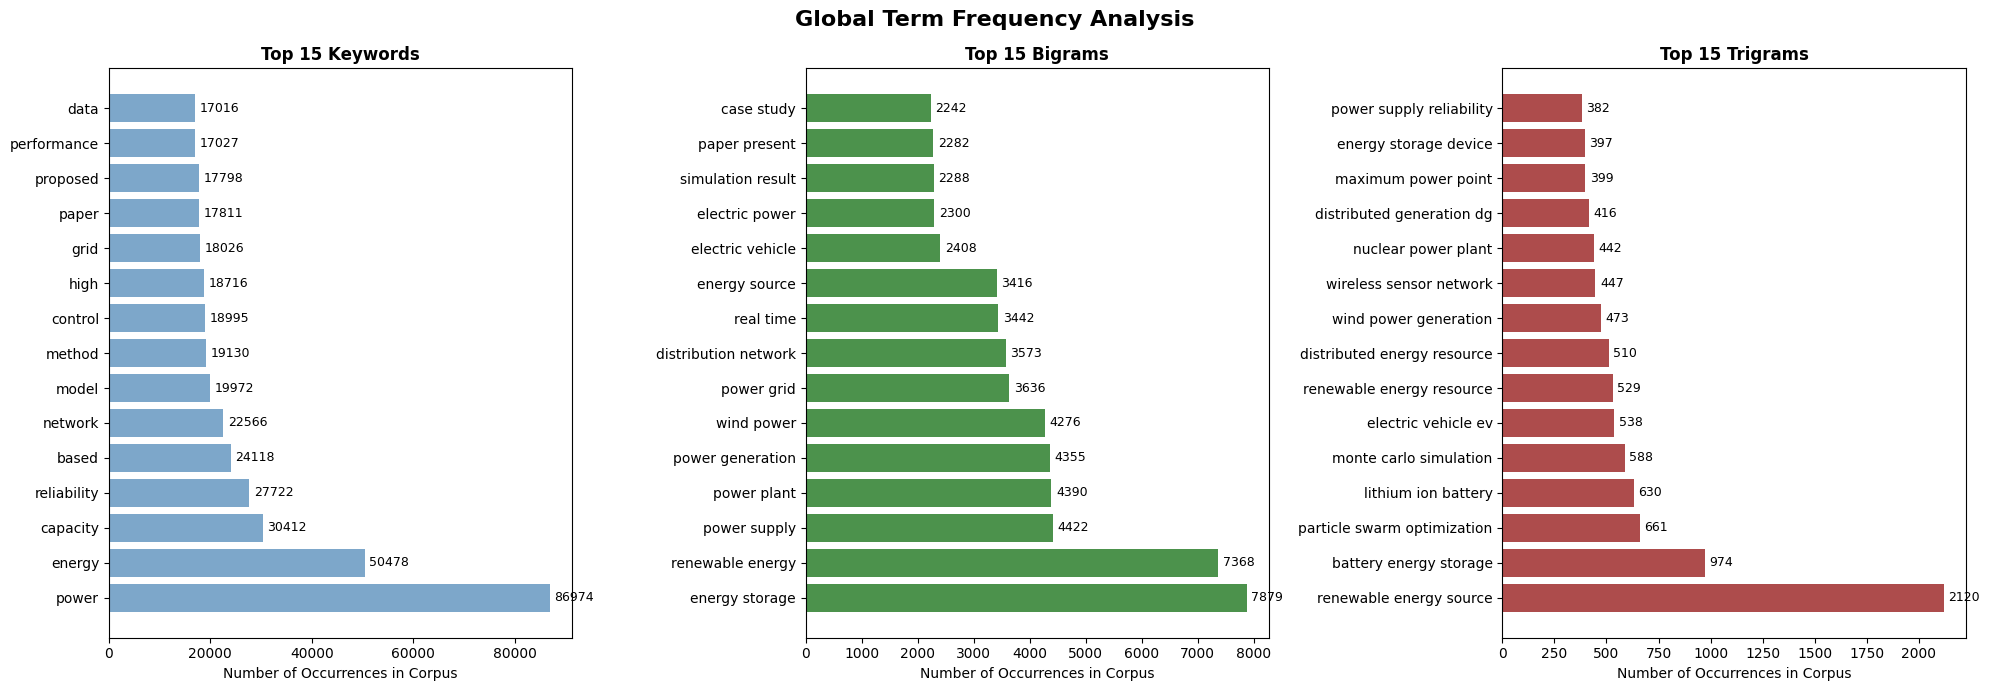

In [22]:
# %%
# Cell 14: Global Term Frequencies Visualization
if data and term_frequencies_file:
    plot_term_frequencies(term_frequencies_file, n_terms=15, save=True)
else:
    print("❌ Term frequencies not available")


### Per-Topic Analysis

📊 Analyzing 3311 documents for topic 7
💾 Per-topic plot saved as: Saved_files_new\topic_7_Wind_Power_Reliability_termfrequencies.png


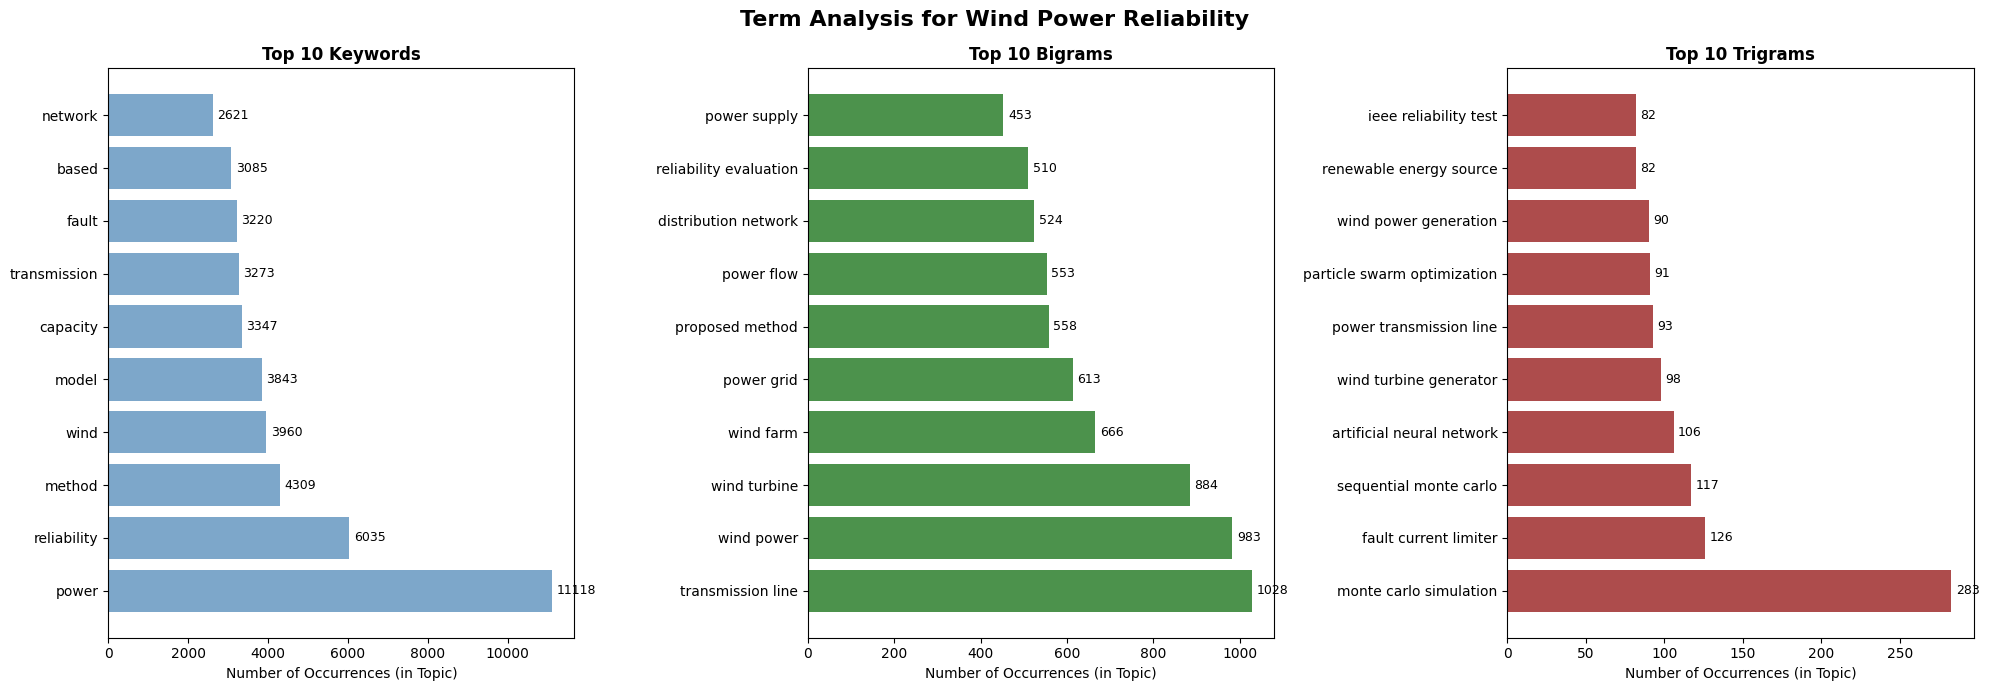

In [23]:
# %%
# Cell 15: Per-Topic Analysis
if data:
    topic_to_plot = 7
    name = topic_names.get(str(topic_to_plot), f"Topic {topic_to_plot}") if topic_names else f"Topic {topic_to_plot}"
    plot_top_terms_for_topic(df, topic_to_plot, topic_name=name, save=True)


### Method Importance

In [24]:
# Print a list of all unique methods present in the method columns of df
unique_methods = set()
for col in method_cols:
    if col.startswith('Method_') and not col.endswith('_Score'):
        unique_methods.update(df[col].dropna().unique())
# Remove invalid entries
unique_methods = [m for m in unique_methods if str(m).lower() not in ['nan', 'none', 'lowconfidence']]
print(f"Unique methods found ({len(unique_methods)}):")

for method in sorted(unique_methods):
    print(method)

Unique methods found (89):
High
Low
adaptive neuro-fuzzy
alternating direction method of multipliers
ant colony optimization
artificial neural network
autoregressive integrated moving average
contingency analysis
cost-benefit analysis
decision tree
deep reinforcement learning drl
demand response dr
differential evolution
differential protection
discrete wavelet
dynamic line rating
dynamic programming
dynamic reactive power
dynamic voltage restorer
economic dispatch
fast decoupled power flow
fault tree analysis
firefly algorithm
first order reliability method
fuzzy control
gated recurrent unit
gauss-seidel load flow
generation shift factors
genetic algorithm ga
hierarchical level ii
hierarchical level iii
incremental conductance
integer linear programming
interior point method
kalman filter
latin hypercube sampling
line outage distribution factor
linear regression
load frequency control
long short-term memory
loss of load probability
markov chain monte carlo
mean time between failures
m

📊 Plotting 15 methods


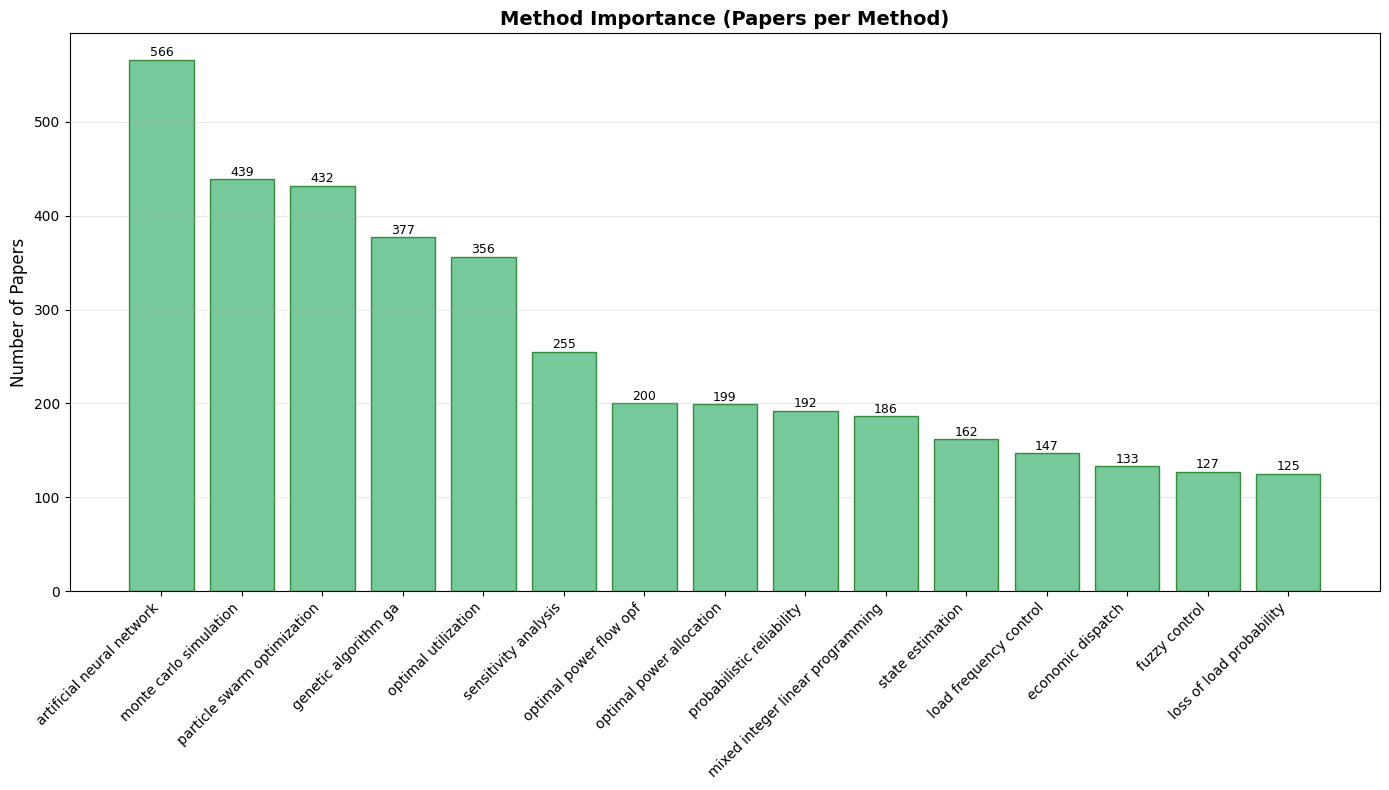

In [25]:
# %%
# Cell 16: Method Importance
if data:
    plot_method_importance(df, max_methods=15, include_low_conf=True
    )


### Topic Importance

In [26]:
print(topic_names)

{'0': 'Renewable Energy Systems', '1': 'Resilience Management', '2': 'Smart Monitoring Systems', '3': 'Power Control Systems', '4': 'Thermal Energy Systems', '5': 'Smart Grid Energy Management', '6': 'Battery Energy Storage', '7': 'Wind Power Reliability', '8': 'Cloud Computing and Sensor Networks', '9': 'Wireless Communication Systems'}


📊 Plotting 10 topics


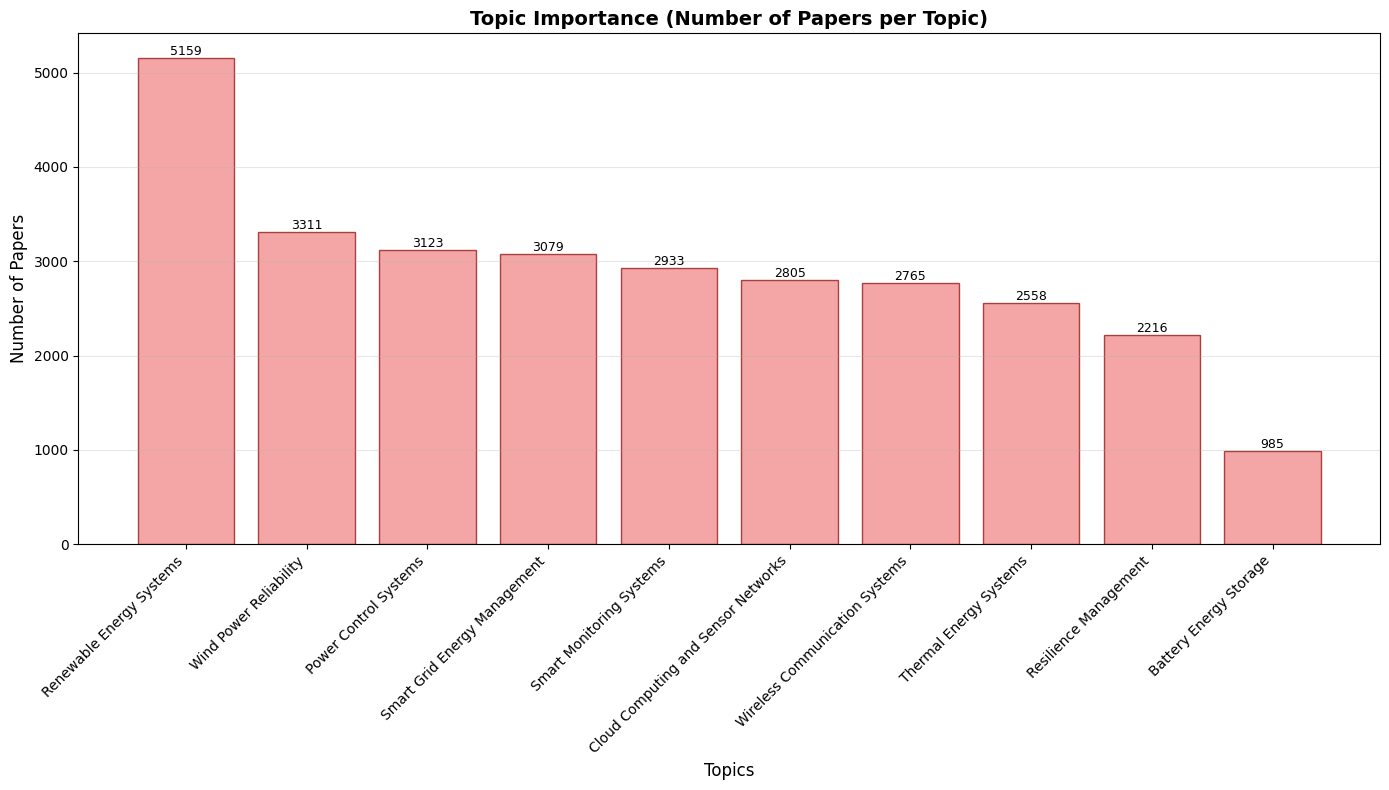

In [27]:
# %%
# Cell 17: Topic Importance
if data:
    plot_topic_importance_with_names(df, topic_names, max_topics=15)


### Method Trends Over Time

📈 Plotting trends for: Top 50 Methods
📊 Papers after all filtering: 6038
📅 Years with ≥20 papers: 23


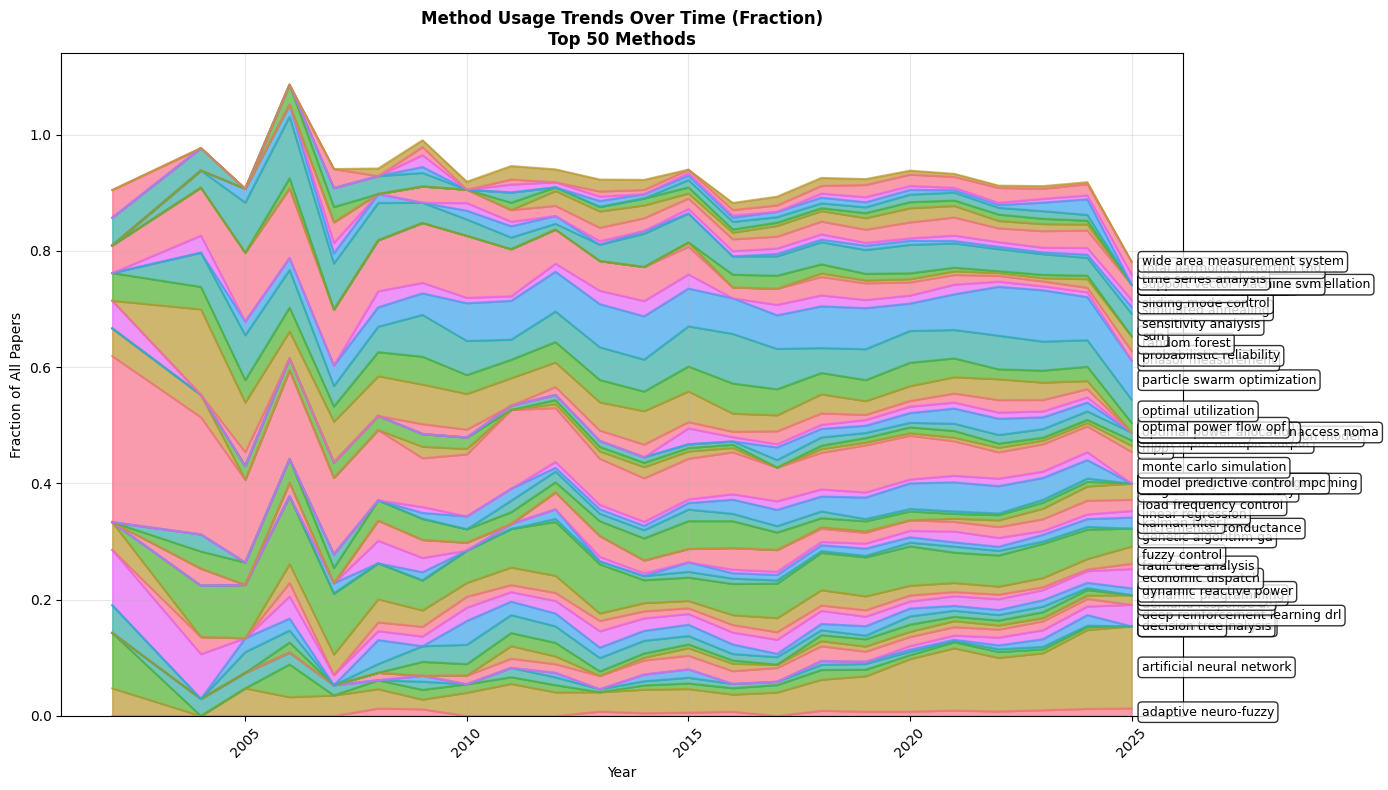

In [28]:
# %%
# Cell 18: Method Trends Over Time
if data:
    plot_method_trends_over_time(df, min_count=1,plot_type='area', window_smooth=2, top_n=50, include_low_conf=True)


### Topic Trends Over Time

In [29]:
#print a list of topic namesas a vertical list
print("\n📚 Loaded Topic Names:")
for idx, name in topic_names.items():
    print(f"  Topic {idx}: {name}")
# print(tolist(topic_names.keys()))


📚 Loaded Topic Names:
  Topic 0: Renewable Energy Systems
  Topic 1: Resilience Management
  Topic 2: Smart Monitoring Systems
  Topic 3: Power Control Systems
  Topic 4: Thermal Energy Systems
  Topic 5: Smart Grid Energy Management
  Topic 6: Battery Energy Storage
  Topic 7: Wind Power Reliability
  Topic 8: Cloud Computing and Sensor Networks
  Topic 9: Wireless Communication Systems


In [30]:
#Plot list of unique venues in the dataframe, skip venues that appear less than 5 times
#Group venues that contain "IEEE", "ACM", "Springer", "Elsevier", "Wiley" into a single group called "Major Publishers"
if 'venue' in df.columns:
    venue_counts = df['venue'].value_counts(dropna=True)
    
    # Define publisher patterns for better matching
    publisher_patterns = {
        'IEEE': ['ieee', 'institute of electrical'],
        'ACM': ['acm', 'association for computing'],
        'Springer': ['springer', 'lecture notes'],
        'Elsevier': ['elsevier', 'science direct'],
        'Wiley': ['wiley', 'john wiley']
    }
    
    def categorize_venue_enhanced(venue):
        if pd.isna(venue) or not isinstance(venue, str):
            return 'Other'
        
        venue_lower = venue.lower()
        
        # Check each publisher with multiple patterns
        for publisher, patterns in publisher_patterns.items():
            if any(pattern in venue_lower for pattern in patterns):
                return f'{publisher}'
        
        # Group small venues
        if venue_counts.get(venue, 0) < 5:
            return 'Small Venues'
        else:
            return venue
    
    df['venue_category'] = df['venue'].apply(categorize_venue_enhanced)
    unique_venues = df['venue_category'].value_counts()
    
    print("\n🏛️ Enhanced Venue Categories:")
    for venue, count in unique_venues.head(10).items():
        print(f"  {venue}: {count} papers")



🏛️ Enhanced Venue Categories:
  Other: 7814 papers
  Small Venues: 6515 papers
  IEEE: 6306 papers
  Energies: 562 papers
  Journal of Physics: Conference Series: 248 papers
  Sustainability: 219 papers
  arXiv.org: 192 papers
  Frontiers in Energy Research: 150 papers
  ECS Meeting Abstracts: 149 papers
  Applied Sciences: 129 papers


📅 Year range: 1980 - 2024
📈 Plotting trends for: Top 10 Topics
📊 Papers after all filtering: 28336
📅 Years with ≥1 papers: 45


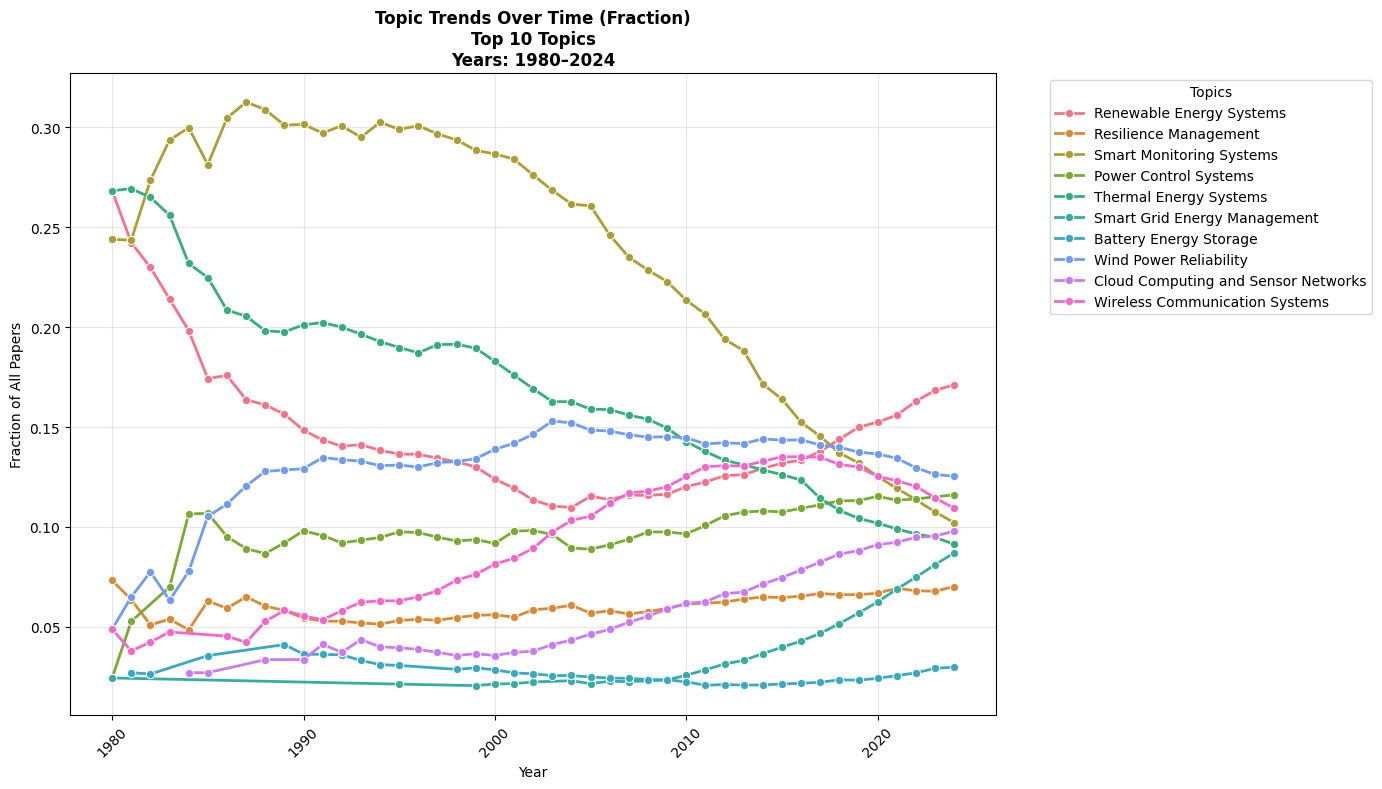

📊 Citation filter: 9411/28336 papers (≥5 citations)
📅 Year range: 1980 - 2024
📈 Plotting trends for: Renewable Energy Systems, Power Control Systems, Thermal Energy Systems, Smart Grid Energy Management, Battery Energy Storage, Wind Power Reliability
📊 Papers after all filtering: 5831
📅 Years with ≥20 papers: 34


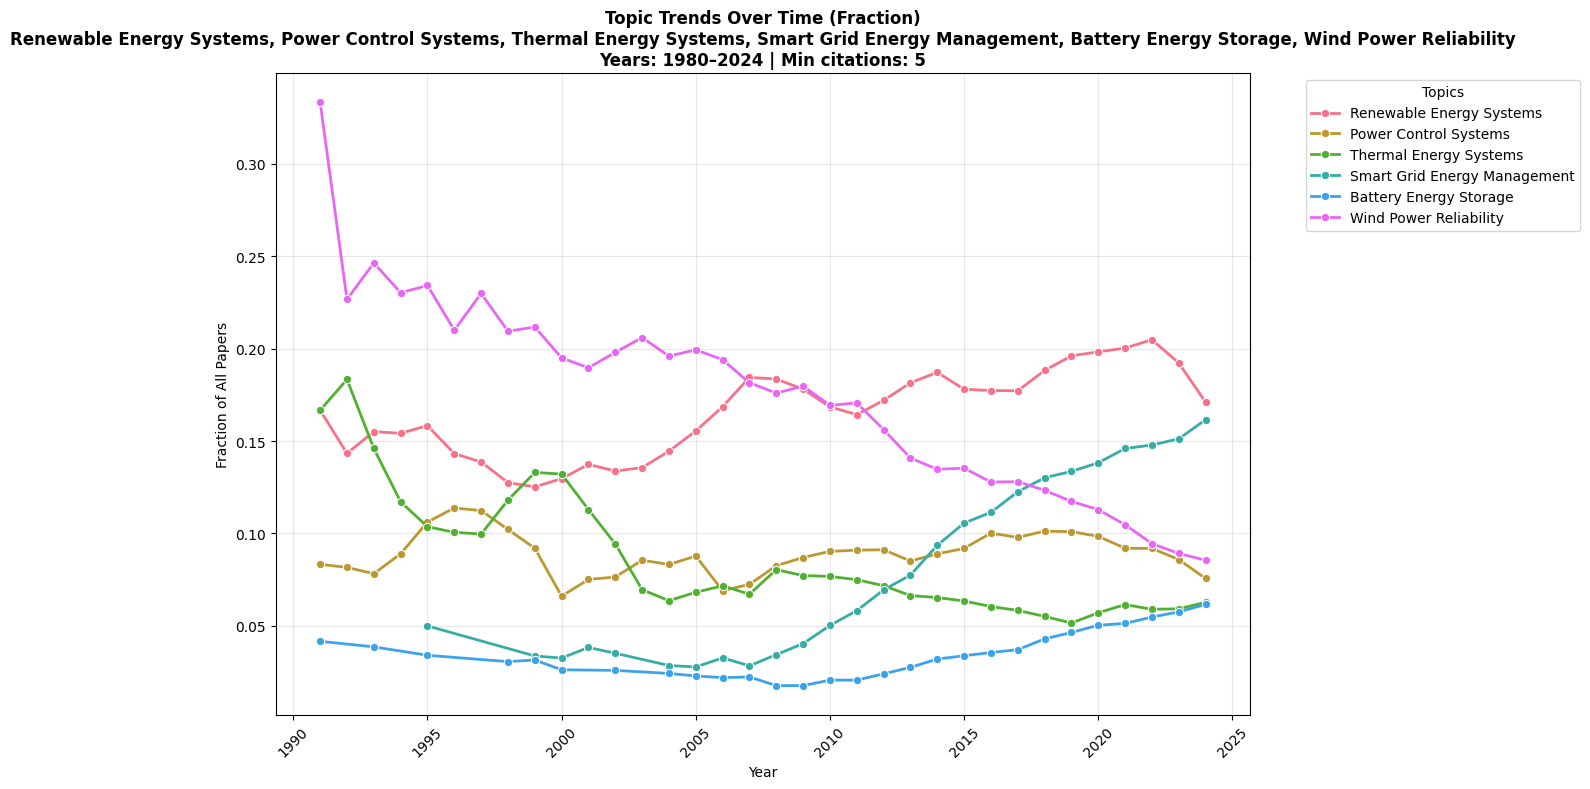

,year,Primary_Topic_Index,count,total_count,value
0,1991,0,4,24,0.166667
5,1992,0,3,25,0.143333
9,1993,0,5,28,0.155079
14,1994,0,5,33,0.154188
18,1995,0,7,40,0.158351
...,...,...,...,...,...
165,2020,7,89,794,0.112889
171,2021,7,61,702,0.104727
177,2022,7,44,573,0.094538
183,2023,7,33,481,0.089182


In [38]:
# %%
# Cell 19: Topic Trends Over Time

result = plot_topic_trends_over_time(
    df, 
    topic_col='Primary_Topic_Index',  # ✅ Explicitly use the Index column
    #topics=[0,3,7,8],  # List of topic indices to plot decreasing
    #topics=[4,5,6,9],  # List of topic indices to plot increasing
    #topics=[1,2], # Listof topic indices to plot stable
    topic_names=topic_names, 
    min_papers_per_year=1,
    plot_type='line', # 'line' or 'area'
    value_type='fraction',  # 'fraction' or 'count'
    window_smooth=20,
    start_year=1980,
    end_year=2024
)
"""
# %%
# Example 1: Fraction-based area plot (default behavior)
plot_topic_trends_over_time(
    df, 
    topic_col='Primary_Topic_Index',
    topics=[0,1,2,3,4],
    topic_names=topic_names, 
    plot_type='area',
    y_axis='fraction',  # Shows percentages
    start_year=2000,
    end_year=2024
)

# Example 2: Absolute count-based area plot
plot_topic_trends_over_time(
    df, 
    topic_col='Primary_Topic_Index',
    topics=[0,1,2,3,4],
    topic_names=topic_names, 
    plot_type='area',
    y_axis='count',  # Shows absolute numbers
    start_year=2000,
    end_year=2024
)
"""
#Line plot with full topic names in legend
plot_topic_trends_over_time(
    df, 
    topic_col='Primary_Topic_Index',
    topics=[0,3,4,5,6,7],
    topic_names=topic_names, 
    plot_type='line',
    value_type='fraction',
    start_year=1980,
    window_smooth=5,
    min_citations=5,
    end_year=2024
)

### Weighted Method Importance

🔍 Starting Enhanced Method Importance Analysis with Score-based Weighting...

📊 Filtering Results:
  Original papers: 28,934
  After Min citations (≥5): 9486 papers
  After Min year (≥1980): 9411 papers
  After Max year (≤2024): 9411 papers
  Final papers: 9,411 (32.5% retained)
📊 Using score-based weighting with columns: ['Method_1', 'Method_2', 'Method_3', 'Method_4', 'Method_5', 'Method_6', 'Method_7', 'Method_8', 'Method_9', 'Method_10']
📊 Using confidence score-based weighting...
📊 Plotting top 25 methods


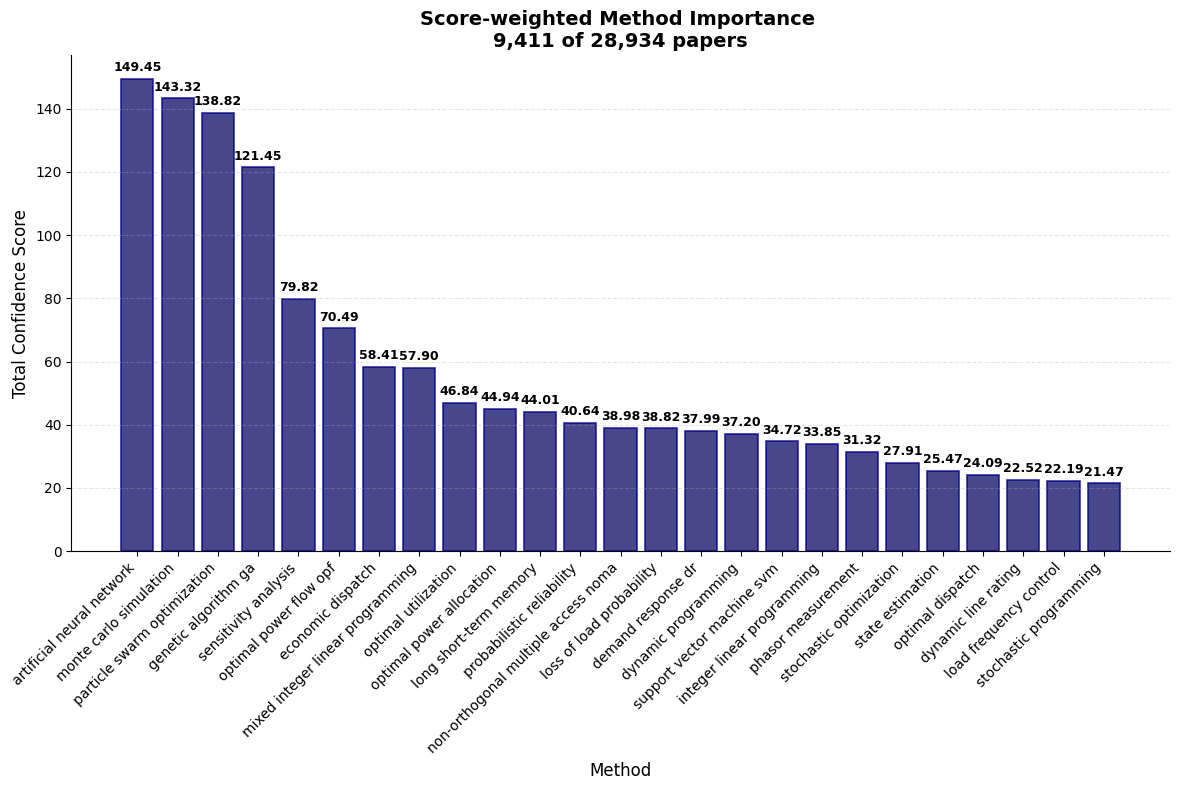


📈 Summary Statistics (score-based):
  Total methods identified: 85
  Methods displayed: 25
  Papers processed: 9,411
  Score range: 21.471 - 149.449
  Mean score: 55.705
  Total confidence used: 1981.10
  Average confidence per paper: 0.211
  High confidence methods (>1.0): 25
  Medium confidence methods (0.5-1.0): 0
  Lower confidence methods (≤0.5): 0


,Method,Weighted_Score
19,artificial neural network,149.449445
3,monte carlo simulation,143.320395
41,particle swarm optimization,138.821108
20,genetic algorithm ga,121.454171
5,sensitivity analysis,79.818196
26,optimal power flow opf,70.494073
23,economic dispatch,58.408929
51,mixed integer linear programming,57.903930
9,optimal utilization,46.844711
27,optimal power allocation,44.939373


In [39]:
# %%
# Cell 20: Weighted Method Importance
"""def plot_weighted_method_importance_filtered(df, 
                                           n_top=5, 
                                           plot_top_k=None, 
                                           method_label_prefix="Method_",
                                           # NEW: Simplified Topic Filtering by Number
                                           topic_numbers=None,          # Filter by topic number(s) - list or single int
                                           min_citations=None,          # Minimum citation count
                                           max_citations=None,          # Maximum citation count
                                           venues_include=None,         # List of venues to include
                                           venues_exclude=None,         # List of venues to exclude
                                           min_year=None,              # Minimum publication year
                                           max_year=None,              # Maximum publication year
                                           # Visualization Parameters
                                           figsize=(14, 8),
                                           save_dir=None,
                                           show_filter_info=True):"""

#if data:
    #weighted_results = plot_weighted_method_importance_filtered(df, n_top=10, plot_top_k=25, figsize=(12,8), min_year=1980, max_year=2024, min_citations=5)


plot_weighted_method_importance_filtered(df, 
                                         n_top=10,
                                         plot_top_k=25,
                                         figsize=(12,8),
                                         min_year=1980,
                                         max_year=2024,
                                         min_citations=5,
                                         #topic_numbers=[7,4],
                                         weighting_method='score')
# score_result, rank_result = compare_weighting_methods(df, topic_numbers=[0, 1, 2])



### Weighted Method Trends

📊 Citation filter: 17987/28532 papers (≥1 citations)
📊 Using score-based weighting (confidence scores, uncorrected)

📊 Score-based Weighting Summary:
   Score range: 0.013 - 0.752
   Mean confidence score: 0.321
   Papers with high confidence (>0.1): 9530/11437 assignments


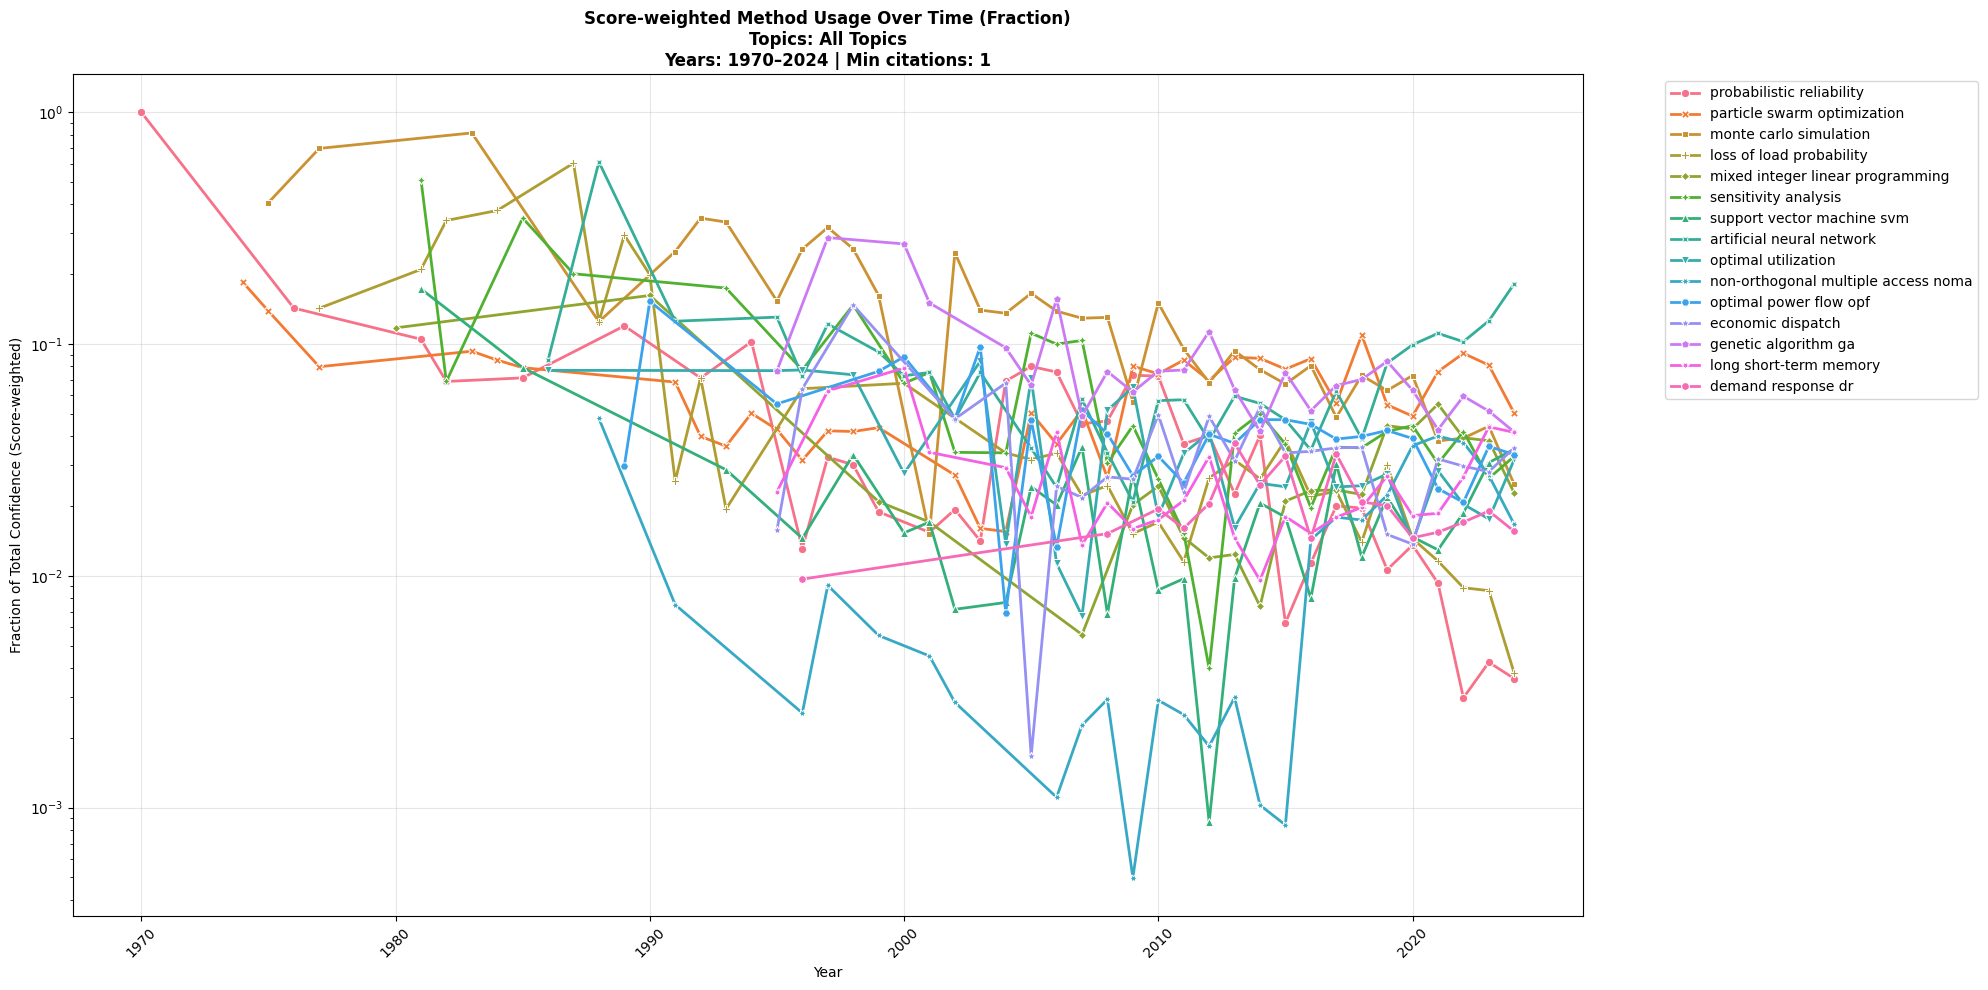

In [52]:
# %%
# Cell 21: Weighted Method Trends
plot_top_k=15
#adjust fig height to method count / 2 +3 and round up to nearest integer
#fig_height = min(int((plot_top_k / 3) + 5),20)
fig_height = 10

if data:
    plot_weighted_method_trends_over_time(
        df, n_top=10, plot_top_k=plot_top_k, 
        start_year=1970, end_year=2024, 
        min_papers_per_year=1,
        plot_type='line',
        value_type='fraction',
        min_citations=1, 
        window_smooth=0,
        #
        # methods=["monte carlo simulation","artificial neural network", "optimal power flow opf", "stochastic optimization","loss of load probability", "probabilistic reliability", "stochastic programming", "state estimation"],
        figsize=(20, fig_height),
        log_scale=True
        
    )


### Topic-Specific Method Trends

📊 Citation filter: 24142/24142 papers (≥0 citations)
📊 Using score-based weighting (confidence scores)

📊 Score-based Weighting Summary:
   Score range: 0.018 - 0.752
   Mean confidence score: 0.315
   Papers with high confidence (>0.1): 2299/2875 assignments


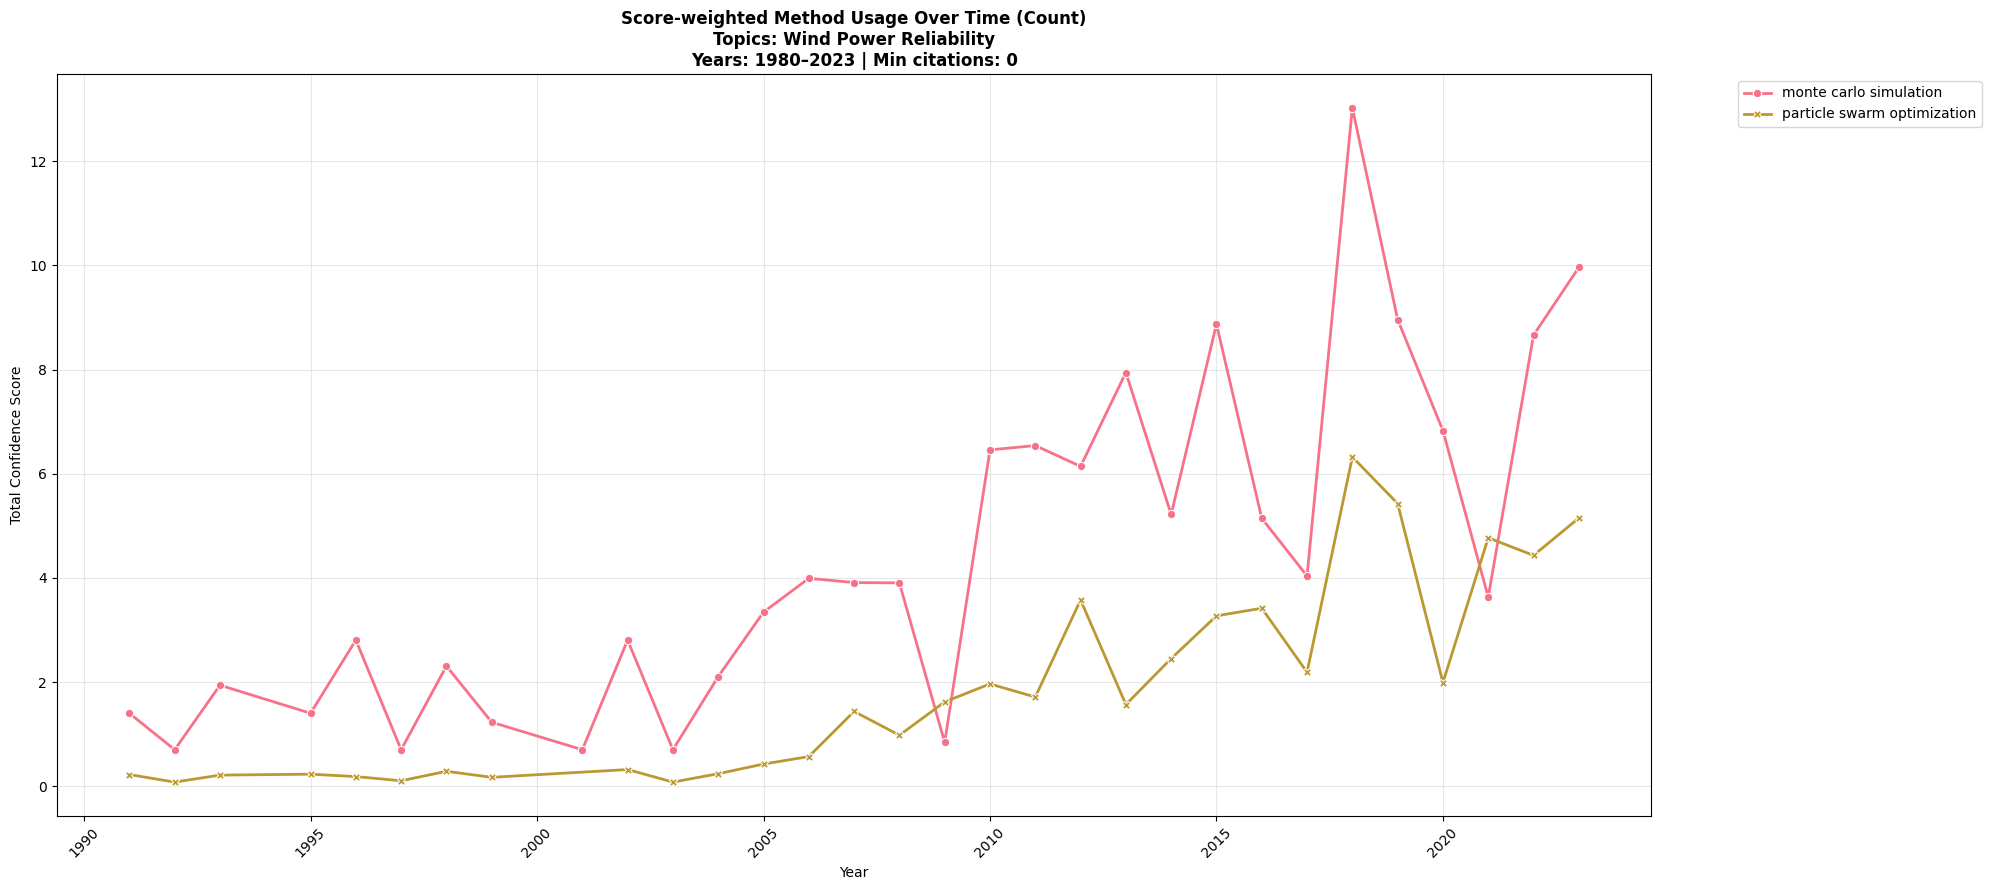

In [45]:
# %%
# Example usage with both weighting methods:
# plot_df_score = plot_weighted_method_trends_over_time(df, weighting_method='score')
# plot_df_rank = plot_weighted_method_trends_over_time(df, weighting_method='rank')


# Cell 22: Topic-Specific Method Trends
plot_top_k=10
#adjust fig height to method count / 2 +3 and round up to nearest integer
fig_height = int((plot_top_k / 4) + 7)
if data:
    plot_weighted_method_trends_over_time(
        df, n_top=10, 
        topics=[7], 
        topic_names=topic_names,
        start_year=1980, end_year=2023, 
        min_papers_per_year=1,
        min_citations=0, 
        plot_top_k=plot_top_k,
        plot_type='line', window_smooth=1,
        value_type='count',  # 'fraction' or 'count'
        weighting_method='score',
        log_scale=False,
        figsize=(20, fig_height),
        #min_citations=5,
        #venues=['IEEE Transactions on Power Systems', 'IEEE Transactions on Smart Grid', 'Electric Power Systems Research'],
        methods=['particle swarm optimization','monte carlo simulation']
        
    )


In [46]:
# GGT corrected growth analysis

# Run integrated analysis
results_ggt, background_growth, dataset_rsquared = classify_technology_lifecycle_ggt_integrated(
    df, 
    canonical_methods=sorted(unique_methods),
    min_publications=2
)

# Analyze results
results_df = analyze_ggt_results(results_ggt, background_growth)

# Key methods verification
print(f"\n✅ KEY METHODS VERIFICATION (GGT-Corrected):")
key_methods = ['monte carlo simulation', 'artificial neural network', 'genetic algorithm', 
              'reinforcement learning', 'particle swarm optimization']

for method in key_methods:
    if method in results_ggt:
        profile = results_ggt[method]
        print(f"\n📋 {method.upper()}:")
        print(f"    Classification: {profile['lifecycle_stage']}")
        print(f"    Raw Growth: {profile['raw_growth_rate']:.3f}")
        print(f"    GGT-Corrected Growth: {profile['ggt_corrected_growth']:.3f}")
        print(f"    Total Importance: {profile['total_importance']:.1f}")
        print(f"    Statistical Confidence: R² = {profile['r_squared']:.3f}, p = {profile['p_value']:.3f}")

print(f"\n📝 INTERPRETATION GUIDE:")
print(f"• Background growth correction: {background_growth:.1%} annually")
print(f"• Positive GGT values: Methods growing faster than field average")
print(f"• Near-zero GGT values: Methods growing at field average (mature)")
print(f"• Negative GGT values: Methods declining relative to field growth")
print(f"• Dataset reliability: R² = {dataset_rsquared:.3f} for overall growth trend")

🔧 STEP 1: CALCULATING PUBLICATION INFLATION CORRECTION
🔍 CALCULATING PUBLICATION INFLATION CORRECTION
Data spans from 1952 to 2025
Valid years for analysis: 59 (from 1960 to 2025)
Publication growth pattern (last 10 years):
  2016: 1277 papers
  2017: 1237 papers
  2018: 1550 papers
  2019: 1783 papers
  2020: 1875 papers
  2021: 1814 papers
  2022: 1903 papers
  2023: 2892 papers
  2024: 4194 papers
  2025: 277 papers

📈 Overall dataset growth characteristics:
  Average papers per year: 489.0
  Annual absolute growth: 33.30 papers/year
  Annual relative growth: 0.068 (6.8%)
  R²: 0.515

🔧 STEP 2: PROCESSING 89 METHODS WITH GGT CORRECTION

🔍 Processing method 1/89: High
  ⚠️ Insufficient data: 0.00 total score

🔍 Processing method 2/89: Low
  ⚠️ Insufficient data: 0.00 total score

🔍 Processing method 3/89: adaptive neuro-fuzzy
Method: adaptive neuro-fuzzy -  Total importance: 33.43, Peak ratio: 5.43
  ✅ Stage: Growing
     Raw growth: 0.1208, GGT-corrected: 0.0527
     R²: 0.386, Impo

📊 Citation filter: 16986/24338 papers (≥1 citations)
🔍 Calculating background publication growth for GGT correction...
📊 Calculated background growth: 7.9%/year (R²=0.719)
📊 Using score-based weighting (confidence scores, GGT-corrected)
📊 Applied 3-year rolling average smoothing

📊 Score-based Weighting Summary:
   Score range: 0.000 - 0.517
   Mean confidence score: 0.011
   Papers with high confidence (>0.1): 59/10287 assignments
   Original score range (before GGT): 0.016 - 0.752
   Background growth correction: 7.9%/year


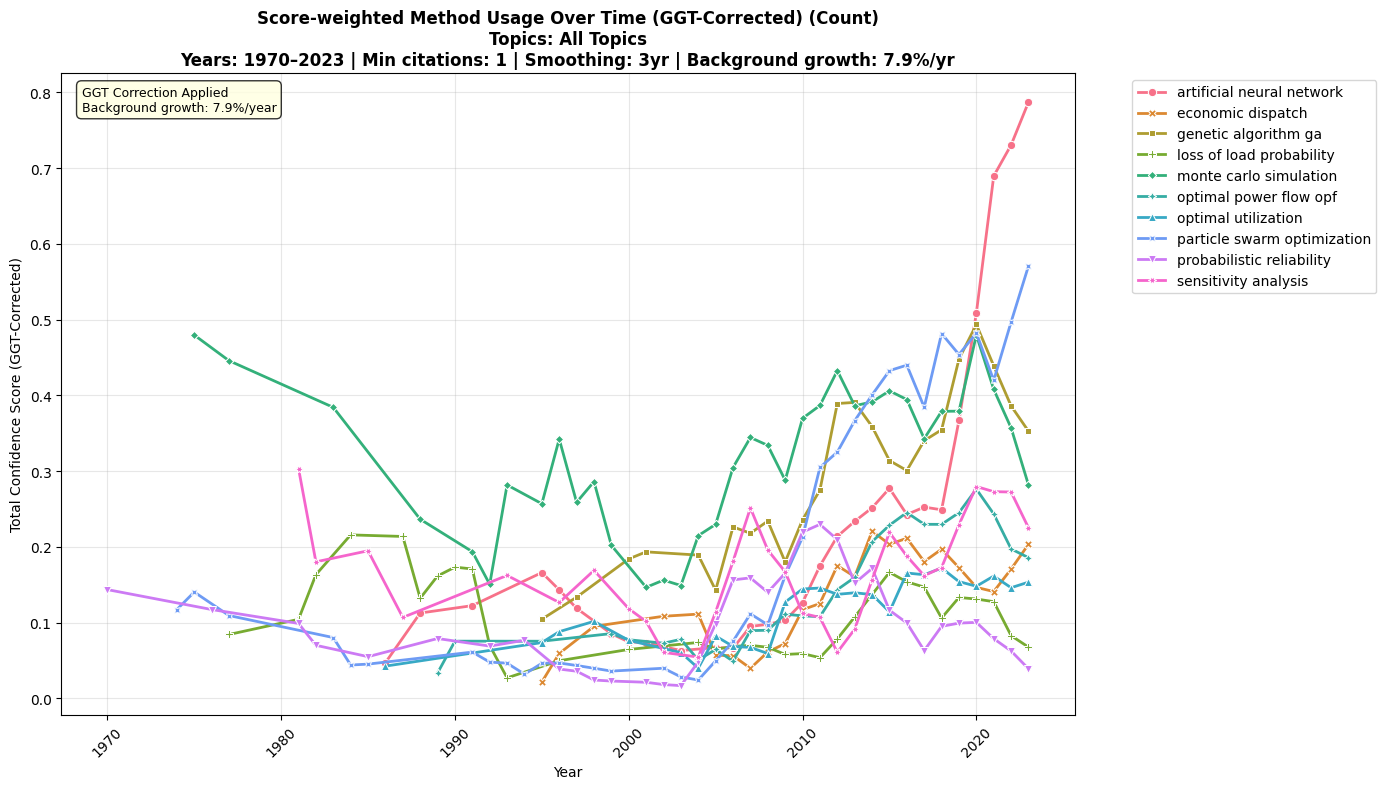

📊 Using score-based weighting (confidence scores, uncorrected)

📊 Score-based Weighting Summary:
   Score range: 0.016 - 0.752
   Mean confidence score: 0.329
   Papers with high confidence (>0.1): 14131/16583 assignments


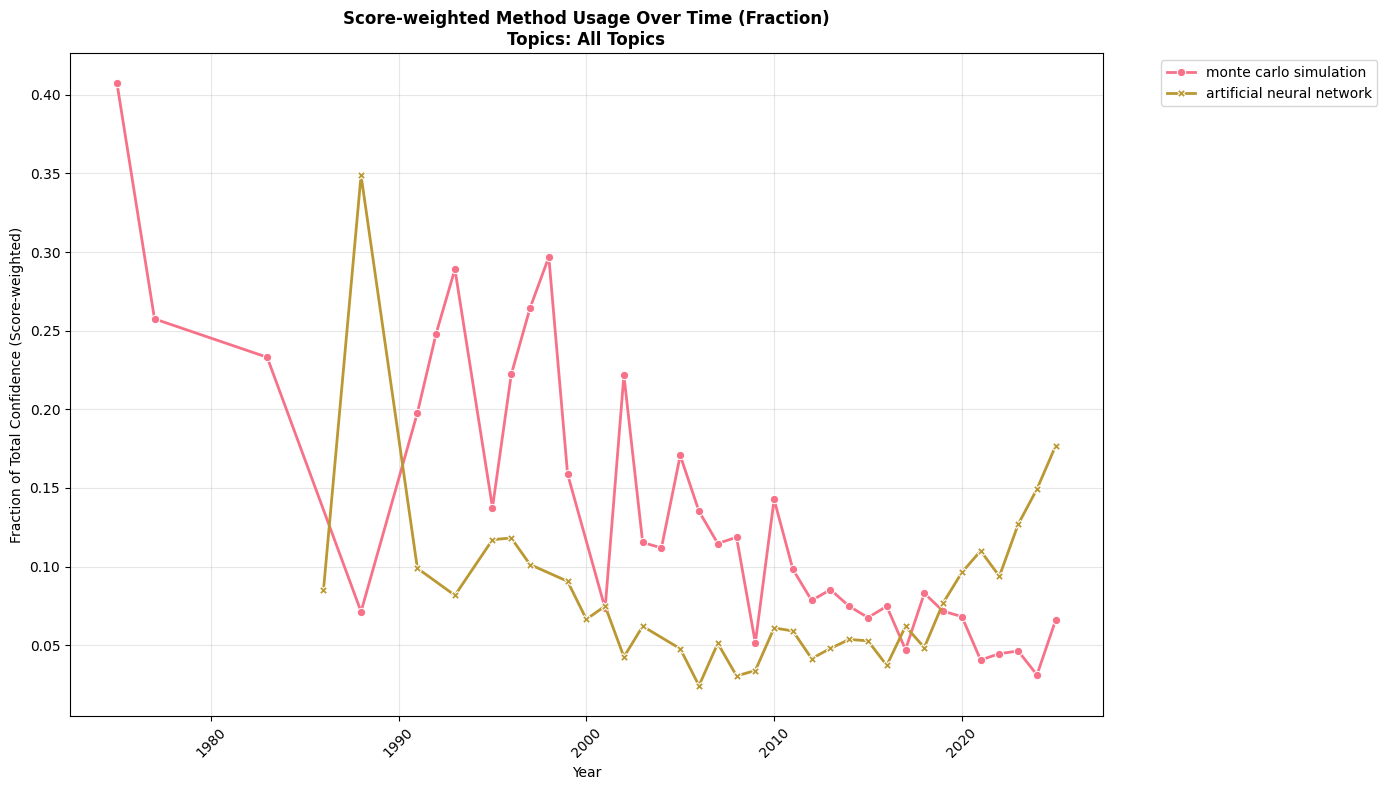

🔍 Calculating background publication growth for GGT correction...
📊 Calculated background growth: 6.8%/year (R²=0.515)
📊 Using score-based weighting (confidence scores, GGT-corrected)

📊 Score-based Weighting Summary:
   Score range: 0.004 - 0.702
   Mean confidence score: 0.113
   Papers with high confidence (>0.1): 6917/16148 assignments
   Original score range (before GGT): 0.016 - 0.752
   Background growth correction: 6.8%/year


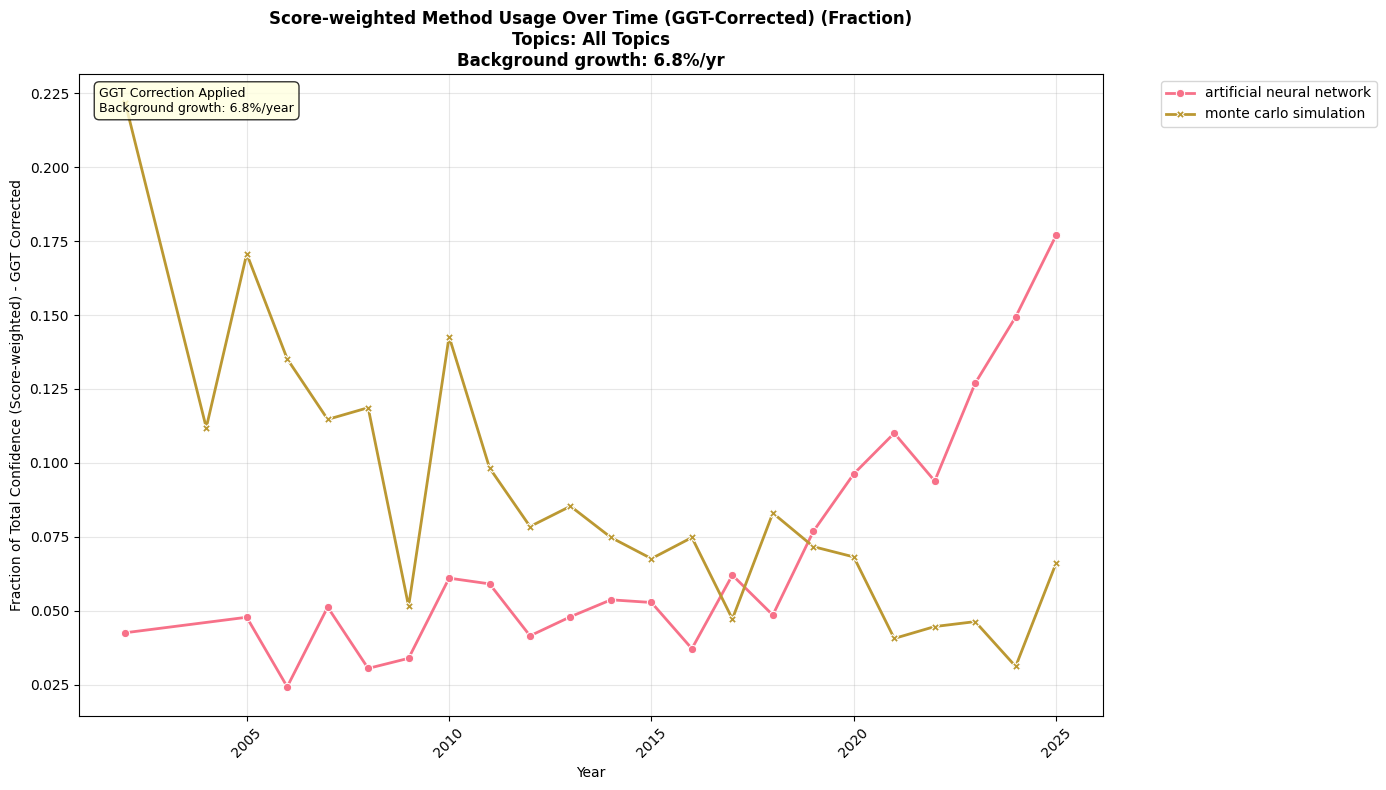

,year,method,points,actual_total_points,value
2,2002,artificial neural network,0.701726,16.478243,0.042585
15,2002,monte carlo simulation,3.652082,16.478243,0.221631
47,2004,monte carlo simulation,2.460371,21.985018,0.111911
68,2005,artificial neural network,1.364312,28.528759,0.047822
84,2005,monte carlo simulation,4.869486,28.528759,0.170687
103,2006,artificial neural network,0.822938,33.850821,0.024311
122,2006,monte carlo simulation,4.575892,33.850821,0.135178
143,2007,artificial neural network,1.772209,34.585414,0.051242
166,2007,monte carlo simulation,3.967276,34.585414,0.114710
193,2008,artificial neural network,1.162809,38.088980,0.030529


In [58]:
# 2. With GGT correction (auto-calculate background growth)
plot_df_ggt = plot_weighted_method_trends_over_time(df, plot_top_k=10,
                                                   start_year=1970, end_year=2023,
                                                   window_smooth=3,
                                                   min_papers_per_year=1,
                                                   min_citations=1,
                                                   ggt_correction=True,
                                                   value_type='count')


#Compare specific methods with and without GGT correction
key_methods = ['monte carlo simulation', 'artificial neural network', 'genetic algorithm']
 
# # Without GGT
plot_weighted_method_trends_over_time(df, methods=key_methods, ggt_correction=False,min_papers_per_year=1)
# 
# # With GGT
plot_weighted_method_trends_over_time(df, methods=key_methods, ggt_correction=True)

📊 Plotting top 15 methods by importance
🔍 Processing 15 methods for trend visualization...
📊 Applying 3-year rolling average smoothing


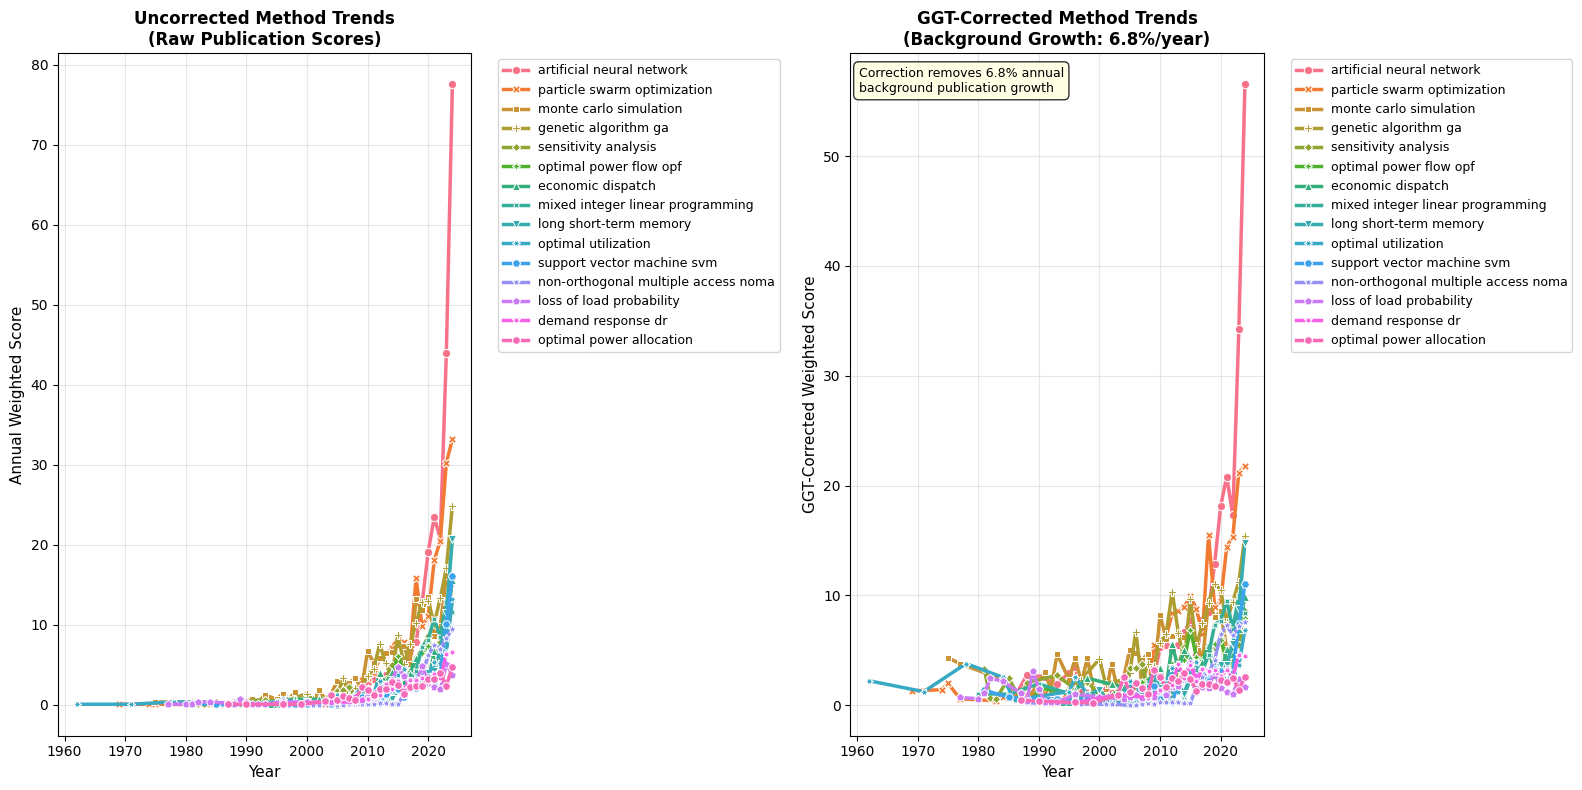


📈 GGT CORRECTION IMPACT SUMMARY:
Background growth rate: 6.8% annually

METHOD GROWTH RATE CHANGES (Top 5):
Method                    Raw      GGT      Change   Impact
-----------------------------------------------------------------
artificial neural networ    0.106   0.038  -0.068 📊
particle swarm optimizat    0.071   0.003  -0.068 📊
monte carlo simulation      0.061  -0.007  -0.068 📊
genetic algorithm ga        0.086   0.018  -0.068 📊
sensitivity analysis        0.066  -0.002  -0.068 📊


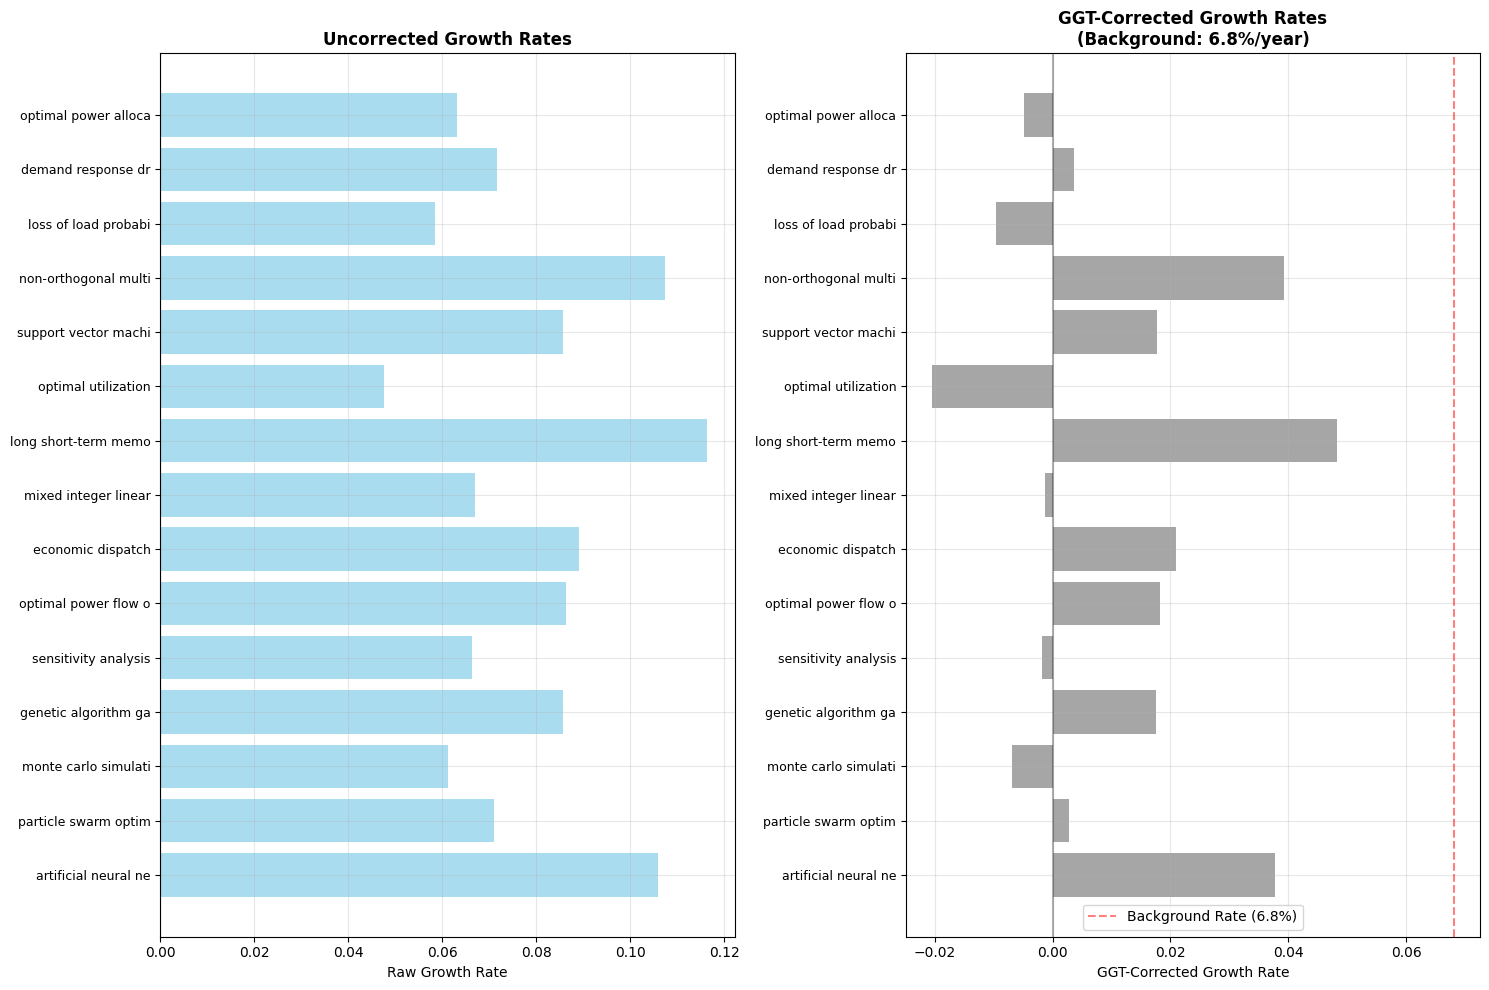

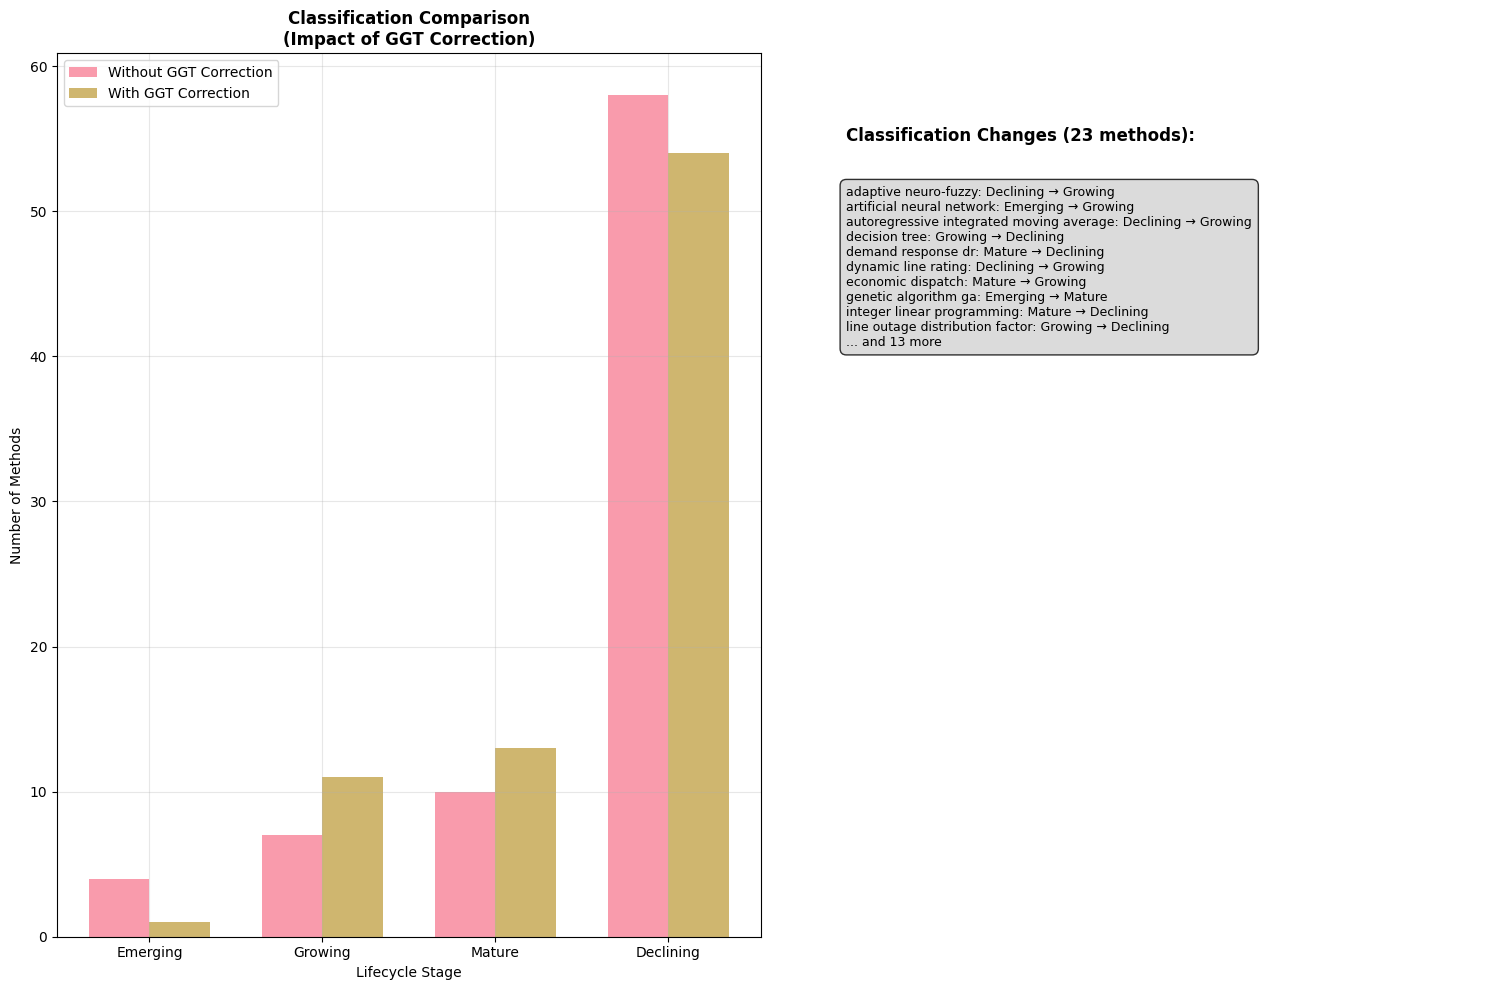

In [ ]:
#GGT correction visualizations vs non-corrected trends


# 1. Basic trend comparison
plot_ggt_corrected_trends(df, results_ggt, background_growth,n_top_methods=15,end_year=2024)#,methods=['monte carlo simulation', 'artificial neural network','genetic algorithm', 'reinforcement learning'])

# 2. Growth rate comparison  
plot_ggt_correction_comparison_detailed(df, results_ggt, background_growth,comparison_type='growth_rates')

# 3. Classification changes
plot_ggt_correction_comparison_detailed(df, results_ggt, background_growth,comparison_type='classifications')

### Basic Topic-Method Heatmap

📊 Creating heatmap for 5 topics and 25 methods


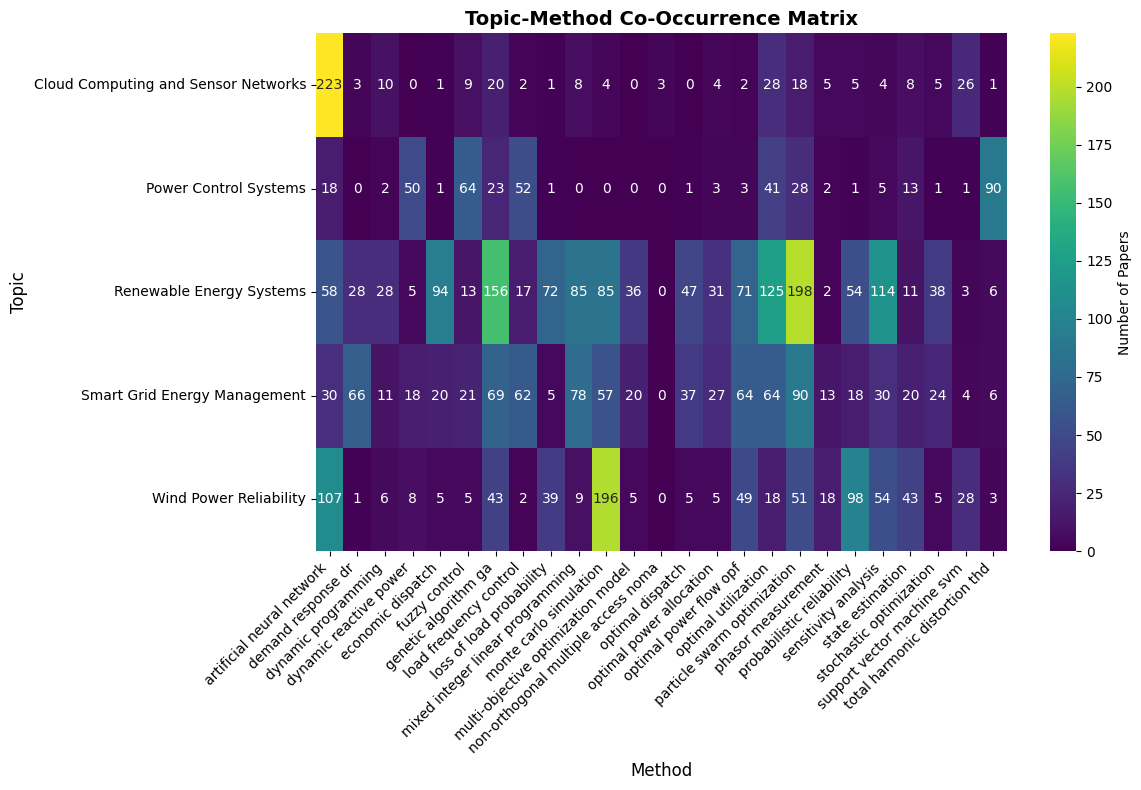

In [31]:
# %%
# Cell 23: Basic Topic-Method Heatmap
if data:
    plot_topic_method_heatmap(df, top_n_methods=25, top_n_topics=5)


In [32]:
# %%
# Cell 24: Advanced Weighted Heatmap
if data:
    pivot = plot_weighted_topic_method_heatmap(
        df, n_top=5, topics=[3,7,9], topic_names=topic_names,
        start_year=2000, end_year=2022, min_papers_per_year=5,
        plot_top_methods=8, plot_top_topics=8
    )

print("\n🎉 Visualization complete! All plots have been generated.")


📊 Creating heatmap from 6888 papers

🎉 Visualization complete! All plots have been generated.
